In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Cannot load cv2.


Setting environment for Precision WorkStation


No vtk
Cannot load cv2.
Cannot find cv2


In [2]:
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

In [3]:
# Does not work for the mxnet version on 3/30/2017
# model_dir_name = 'Sat16ClassFinetuned'
# model_name = 'Sat16ClassFinetuned'
# model_iteration = 10
# output_symbol_name = 'flatten_output'
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'saturation_mean_224.npy'))

# model_dir_name = 'vgg16-blue'
# model_name = 'vgg16-blue'
# model_iteration = 0
# output_symbol_name = 'fc7_output'
# output_dim = 4096
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'vgg_mean.npy'))

# model_dir_name = 'vgg19'
# model_name = 'vgg19'
# model_iteration = 0
# output_symbol_name = 'fc8_output'

# model_dir_name = 'inception-bn'
# model_name = 'Inception-BN'
# model_iteration = 126
# output_symbol_name = 'flatten_output'
# mean_img = mx.nd.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.nd'))['mean_img'].asnumpy()

model_dir_name = 'inception-bn-blue'
download_from_s3(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name), is_dir=True)
model_name = 'inception-bn-blue'
model_iteration = 0
output_symbol_name = 'flatten_output'
output_dim = 1024
mean_img = np.load(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# Reference on how to predict with mxnet model:
# https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
model0, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, model_name), 0)
flatten_output = model0.get_internals()[output_symbol_name]
model = mx.mod.Module(context=[mx.gpu(i) for i in range(1)], symbol=flatten_output)
# model = mx.mod.Module(context=[mx.gpu(i) for i in range(8)], symbol=flatten_output)

# Increase batch_size to 500 does not save any time.
batch_size = 256
model.bind(data_shapes=[('data', (batch_size,1,224,224))], for_training=False)
model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)

# model_dir_name = 'inception-bn-sat'
# model_name = 'inception-bn-sat'
# model_iteration = 0
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# model = mx.model.FeedForward.load(os.path.join(MODEL_ROOTDIR, model_dir_name, model_name), model_iteration, ctx=mx.gpu())

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:52: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [4]:
# Visualize network topology

# a = mx.viz.plot_network(flatten_output, shape={"data":(1, 1, 224, 224)}, node_attrs={"shape":'rect',"fixedsize":'false'})
# a.render(model_name)

In [5]:
patch_size = 224
half_size = patch_size/2
stride = 56

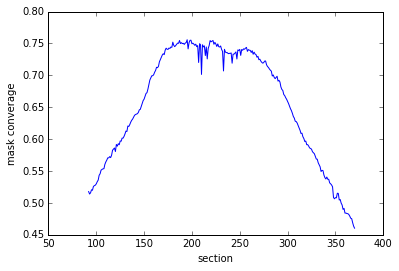

In [6]:
# This shows that a mask covers 50% to 75% of the full area, so predicting only on masks roughly halves the time.

stack = 'MD589'
image_width, image_height = metadata_cache['image_shape'][stack]
first_detect_sec, last_detect_sec = metadata_cache['section_limits'][stack]
a = image_width / 32 * image_height / 32
mask_coverage = {sec: np.count_nonzero(DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, section=sec))/float(a)
for sec in range(first_detect_sec, last_detect_sec+1) if not is_invalid(stack=stack, sec=sec)}
plt.plot(mask_coverage.keys(), mask_coverage.values());
plt.xlabel('section');
plt.ylabel('mask converage');

# Original

In [ ]:
prep_id = 2
input_img_version = 'gray'

In [10]:
# for stack in all_stacks:
for stack in ['MD661']:
    
#     download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, version='cropped'), is_dir=True)
    download_from_s3(DataManager.get_image_dir_v2(stack=stack, prep_id=prep_id, version=input_img_version), is_dir=True)
    # download takes 300 sec.
    
    print stack
    section_to_filename = metadata_cache['sections_to_filenames'][stack]
    
    image_width, image_height = metadata_cache['image_shape'][stack]
    grid_spec = (patch_size, stride, image_width, image_height)

    sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

    first_sec, last_sec = metadata_cache['section_limits'][stack]

    bar = show_progress_bar(first_sec, last_sec)
    
    for sec in metadata_cache['valid_sections'][stack]:
#     for sec in range(first_sec, last_sec+1):
#     for sec in range(150, 151):
#         if is_invalid(stack=stack, sec=sec):
#             continue  
#         if section_to_filename[sec].split('-')[1][0] == 'F':
#             continue
#         if section_to_filename[sec].split('-')[1][0] == 'N':
#             continue
                
        bar.value = sec
        
        sys.stderr.write('\nSection %d.\n' % sec)

        # Use grids only on mask.
        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=prep_id, section=sec)
        indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
        sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
        
#         Use grids on the entire frame.
#         indices_roi = range(len(sample_locations))

        n = len(indices_roi)
        sys.stderr.write('%d samples.\n' % n)

        sample_locations_roi = sample_locations[indices_roi]
        
        t = time.time()
        im = DataManager.load_image_v2(stack=stack, section=sec, prep_id=prep_id, version=input_img_version, resol='lossless')
        sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s

        t = time.time()

        patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
                            for x, y in sample_locations_roi]) # n x 224 x 224
        patches_mean_subtracted = patches - mean_img
        patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

#         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
#                             for x, y in sample_locations_roi]) # n x 224 x 224 x 1
#         patches_mean_subtracted_input = np.rollaxis(patches, 3, 1) - mean_img # n x 3 x 224 x 224

        sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t)) # ~ 20s / 140k patches

        # For mxnet 0.9.4, using 80000 patches in a NDArrayIter works but using 90000 patches causes error:
        # TypeError: Invalid type '<type 'numpy.ndarray'>' for data, should be NDArray or numpy.ndarray

        t1 = time.time()        
        data_iter = mx.io.NDArrayIter(
                        patches_mean_subtracted_input, 
                        batch_size=batch_size,
                        shuffle=False)
        outputs = model.predict(data_iter, always_output_list=True)
        features = outputs[0].asnumpy()
        
#         data_iter.reset()
        del data_iter
        
#         n_each_iter = 80000
#         for b in range(0, n, n_each_iter):
#             data_iter = mx.io.NDArrayIter(
#                             patches_mean_subtracted_input[b:b+n_each_iter], 
#                             batch_size=batch_size,
#                             shuffle=False)
            
#             # Reference on how to predict with mxnet model:
#             # https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
# #             model.bind(data_iter.provide_data, for_training=False)
# #             model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)
#             outputs = model.predict(data_iter, always_output_list=True)
#             features[b:b+n_each_iter] = outputs[0].asnumpy()
        
#             del data_iter
        
        sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1)) 
        # All times below are after the first iteration (which is slow due to model loading into GPU).
        # inception-bn-blue ~125s / 48k patches on workstation single Titan X
        # inception-bn-blue ~27s / 48k patches on AWS p2.8xlarge 8 Tesla K80

    # Had to modify [model]-symbol.json according to this https://github.com/dmlc/mxnet/issues/2718
        
#         del patches_mean_subtracted_input, patches, im
        del patches_mean_subtracted_input, patches_mean_subtracted, patches, im
        
        t = time.time()

        features_fp = DataManager.get_dnn_features_filepath(stack=stack, model_name=model_name, section=sec,
                                                           input_img_version=input_img_version)
        create_parent_dir_if_not_exists(features_fp)
        bp.pack_ndarray_file(features.astype(np.float16), features_fp) # bloscpack produces files of similar size
        upload_to_s3(features_fp, local_root=DATA_ROOTDIR)
        
        del features

        feature_locs_fp = DataManager.get_dnn_feature_locations_filepath(stack=stack, model_name=model_name, 
                                                                         section=sec,
                                                                        input_img_version=input_img_version)
        np.savetxt(feature_locs_fp, np.c_[indices_roi, sample_locations_roi], fmt='%d %d %d')
        upload_to_s3(feature_locs_fp, local_root=DATA_ROOTDIR)

        sys.stderr.write('save: %.2f seconds\n' % (time.time() - t)) # ~.5s
        
# Overall time: 2.5 hours / stack, on AWS using p2.8xlarge 8 Tesla K80."

rm -rf "/shared/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_prep2_thumbnail.tif" && mkdir -p "/shared/CSHL_data_processed/MD585/MD585_prep2_thumbnail"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_prep2_thumbnail.tif" "/shared/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_prep2_thumbnail.tif"
rm -rf "/shared/CSHL_data_processed/MD589/MD589_prep2_thumbnail/MD589-N16-2015.07.30-17.03.43_MD589_3_0048_prep2_thumbnail.tif" && mkdir -p "/shared/CSHL_data_processed/MD589/MD589_prep2_thumbnail"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_prep2_thumbnail/MD589-N16-2015.07.30-17.03.43_MD589_3_0048_prep2_thumbnail.tif" "/shared/CSHL_data_processed/MD589/MD589_prep2_thumbnail/MD589-N16-2015.07.30-17.03.43_MD589_3_0048_prep2_thumbnail.tif"
rm -rf "/shared/CSHL_data_processed/MD590/MD590_prep2_thumbnail/

MD661


Widget Javascript not detected.  It may not be installed or enabled properly.



Section 85.
locate patches: 0.02 seconds
36346 samples.
load image: 0.30 seconds
extract patches: 4.16 seconds
predict: 20.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.06 seconds

Section 86.
locate patches: 0.02 seconds
36556 samples.
load image: 0.30 seconds
extract patches: 3.57 seconds
predict: 20.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.91 seconds

Section 87.
locate patches: 0.02 seconds
36751 samples.
load image: 0.31 seconds
extract patches: 4.20 seconds
predict: 20.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F30-2017.06.05-14.49.48_MD661_3_0090_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.27 seconds

Section 88.
locate patches: 0.02 seconds
36898 samples.
load image: 0.30 seconds
extract patches: 4.23 seconds
predict: 20.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F31-2017.06.05-15.13.47_MD661_1_0091_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.92 seconds

Section 89.
locate patches: 0.02 seconds
37241 samples.
load image: 0.30 seconds
extract patches: 4.28 seconds
predict: 20.50 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F31-2017.06.05-15.13.47_MD661_2_0092_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 7.39 seconds

Section 90.
locate patches: 0.02 seconds
37416 samples.
load image: 0.30 seconds
extract patches: 4.26 seconds
predict: 20.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F31-2017.06.05-15.13.47_MD661_3_0093_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.98 seconds

Section 91.
locate patches: 0.02 seconds
38967 samples.
load image: 0.30 seconds
extract patches: 4.44 seconds
predict: 21.54 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F32-2017.06.05-15.41.24_MD661_1_0094_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.97 seconds

Section 92.
locate patches: 0.02 seconds
39899 samples.
load image: 0.30 seconds
extract patches: 3.89 seconds
predict: 21.98 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F32-2017.06.05-15.41.24_MD661_2_0095_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.86 seconds

Section 93.
locate patches: 0.02 seconds
40325 samples.
load image: 0.30 seconds
extract patches: 4.61 seconds
predict: 22.27 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F32-2017.06.05-15.41.24_MD661_3_0096_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.84 seconds

Section 94.
locate patches: 0.02 seconds
40803 samples.
load image: 0.30 seconds
extract patches: 4.65 seconds
predict: 22.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F33-2017.06.05-16.09.53_MD661_1_0097_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.82 seconds

Section 95.
locate patches: 0.02 seconds
41271 samples.
load image: 0.30 seconds
extract patches: 4.71 seconds
predict: 22.89 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.84 seconds

Section 96.
locate patches: 0.02 seconds
41604 samples.
load image: 0.30 seconds
extract patches: 4.74 seconds
predict: 23.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.54 seconds

Section 97.
locate patches: 0.02 seconds
41630 samples.
load image: 0.30 seconds
extract patches: 4.78 seconds
predict: 23.02 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F34-2017.06.05-16.39.12_MD661_1_0100_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.88 seconds

Section 98.
locate patches: 0.02 seconds
42021 samples.
load image: 0.30 seconds
extract patches: 4.85 seconds
predict: 23.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F34-2017.06.05-16.39.12_MD661_2_0101_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.10 seconds

Section 99.
locate patches: 0.02 seconds
42375 samples.
load image: 0.31 seconds
extract patches: 4.87 seconds
predict: 23.36 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F34-2017.06.05-16.39.12_MD661_3_0102_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.05 seconds

Section 100.
locate patches: 0.02 seconds
42590 samples.
load image: 0.30 seconds
extract patches: 4.92 seconds
predict: 23.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F35-2017.06.05-17.08.18_MD661_1_0103_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.07 seconds

Section 101.
locate patches: 0.02 seconds
43170 samples.
load image: 0.30 seconds
extract patches: 4.97 seconds
predict: 23.83 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F35-2017.06.05-17.08.18_MD661_2_0104_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.07 seconds

Section 102.
locate patches: 0.02 seconds
43573 samples.
load image: 2.44 seconds
extract patches: 4.99 seconds
predict: 24.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.03 seconds

Section 103.
locate patches: 0.02 seconds
44107 samples.
load image: 2.61 seconds
extract patches: 4.30 seconds
predict: 24.50 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F36-2017.06.05-17.38.33_MD661_1_0106_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.28 seconds

Section 104.
locate patches: 0.02 seconds
44691 samples.
load image: 2.45 seconds
extract patches: 4.36 seconds
predict: 24.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F36-2017.06.05-17.38.33_MD661_2_0107_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.14 seconds

Section 105.
locate patches: 0.02 seconds
44945 samples.
load image: 2.57 seconds
extract patches: 4.41 seconds
predict: 24.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.26 seconds

Section 106.
locate patches: 0.02 seconds
45039 samples.
load image: 2.53 seconds
extract patches: 4.39 seconds
predict: 24.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.11 seconds

Section 107.
locate patches: 0.02 seconds
45888 samples.
load image: 2.52 seconds
extract patches: 5.22 seconds
predict: 25.36 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.06 seconds

Section 108.
locate patches: 0.02 seconds
46355 samples.
load image: 2.82 seconds
extract patches: 4.54 seconds
predict: 25.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F37-2017.06.05-18.09.08_MD661_3_0111_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.28 seconds

Section 109.
locate patches: 0.02 seconds
46685 samples.
load image: 2.58 seconds
extract patches: 4.57 seconds
predict: 25.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F38-2017.06.05-18.38.44_MD661_1_0112_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.04 seconds

Section 110.
locate patches: 0.02 seconds
47092 samples.
load image: 2.57 seconds
extract patches: 4.60 seconds
predict: 25.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F38-2017.06.05-18.38.44_MD661_2_0113_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.30 seconds

Section 111.
locate patches: 0.02 seconds
47333 samples.
load image: 2.63 seconds
extract patches: 4.62 seconds
predict: 26.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F38-2017.06.05-18.38.44_MD661_3_0114_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.60 seconds

Section 112.
locate patches: 0.02 seconds
47689 samples.
load image: 2.46 seconds
extract patches: 4.68 seconds
predict: 26.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F39-2017.06.05-19.07.49_MD661_1_0115_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.25 seconds

Section 113.
locate patches: 0.02 seconds
47974 samples.
load image: 2.51 seconds
extract patches: 5.47 seconds
predict: 26.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.06 seconds

Section 114.
locate patches: 0.02 seconds
48167 samples.
load image: 2.69 seconds
extract patches: 5.49 seconds
predict: 26.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F39-2017.06.05-19.07.49_MD661_3_0117_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.21 seconds

Section 115.
locate patches: 0.02 seconds
48286 samples.
load image: 2.53 seconds
extract patches: 4.69 seconds
predict: 26.68 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.27 seconds

Section 116.
locate patches: 0.02 seconds
48548 samples.
load image: 2.59 seconds
extract patches: 4.74 seconds
predict: 26.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.77 seconds

Section 117.
locate patches: 0.02 seconds
48651 samples.
load image: 2.64 seconds
extract patches: 4.75 seconds
predict: 26.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F40-2017.06.05-19.36.43_MD661_3_0120_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.98 seconds

Section 118.
locate patches: 0.02 seconds
48931 samples.
load image: 2.53 seconds
extract patches: 5.58 seconds
predict: 26.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.52 seconds

Section 119.
locate patches: 0.02 seconds
49290 samples.
load image: 2.58 seconds
extract patches: 4.81 seconds
predict: 27.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F41-2017.06.05-20.06.59_MD661_2_0122_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.84 seconds

Section 120.
locate patches: 0.02 seconds
49540 samples.
load image: 2.53 seconds
extract patches: 4.83 seconds
predict: 27.57 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F41-2017.06.05-20.06.59_MD661_3_0123_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.38 seconds

Section 121.
locate patches: 0.02 seconds
49778 samples.
load image: 2.55 seconds
extract patches: 4.86 seconds
predict: 27.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F42-2017.06.05-20.35.31_MD661_1_0124_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.29 seconds

Section 122.
locate patches: 0.02 seconds
49968 samples.
load image: 2.71 seconds
extract patches: 4.87 seconds
predict: 27.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F42-2017.06.05-20.35.31_MD661_2_0125_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.35 seconds

Section 123.
locate patches: 0.02 seconds
50285 samples.
load image: 2.54 seconds
extract patches: 4.89 seconds
predict: 27.83 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F42-2017.06.05-20.35.31_MD661_3_0126_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.25 seconds

Section 124.
locate patches: 0.02 seconds
50570 samples.
load image: 2.61 seconds
extract patches: 4.93 seconds
predict: 28.01 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.21 seconds

Section 125.
locate patches: 0.02 seconds
50838 samples.
load image: 2.61 seconds
extract patches: 4.97 seconds
predict: 28.01 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.26 seconds

Section 126.
locate patches: 0.02 seconds
51082 samples.
load image: 2.59 seconds
extract patches: 4.99 seconds
predict: 28.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.88 seconds

Section 127.
locate patches: 0.03 seconds
51317 samples.
load image: 2.61 seconds
extract patches: 5.85 seconds
predict: 28.36 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F44-2017.06.05-21.36.28_MD661_1_0130_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.32 seconds

Section 128.
locate patches: 0.02 seconds
51650 samples.
load image: 2.59 seconds
extract patches: 5.89 seconds
predict: 28.55 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F44-2017.06.05-21.36.28_MD661_2_0131_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.32 seconds

Section 129.
locate patches: 0.02 seconds
51833 samples.
load image: 2.57 seconds
extract patches: 5.05 seconds
predict: 28.76 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.49 seconds

Section 130.
locate patches: 0.03 seconds
52021 samples.
load image: 2.53 seconds
extract patches: 5.14 seconds
predict: 28.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F45-2017.06.05-22.05.50_MD661_1_0133_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.38 seconds

Section 131.
locate patches: 0.02 seconds
52170 samples.
load image: 2.59 seconds
extract patches: 5.10 seconds
predict: 28.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F45-2017.06.05-22.05.50_MD661_2_0134_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.60 seconds

Section 132.
locate patches: 0.02 seconds
52369 samples.
load image: 2.66 seconds
extract patches: 5.12 seconds
predict: 29.04 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F45-2017.06.05-22.05.50_MD661_3_0135_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.40 seconds

Section 133.
locate patches: 0.02 seconds
52585 samples.
load image: 2.48 seconds
extract patches: 5.14 seconds
predict: 29.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F46-2017.06.05-22.36.28_MD661_1_0136_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.30 seconds

Section 134.
locate patches: 0.02 seconds
52860 samples.
load image: 2.53 seconds
extract patches: 5.17 seconds
predict: 29.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.36 seconds

Section 135.
locate patches: 0.02 seconds
53116 samples.
load image: 2.52 seconds
extract patches: 5.21 seconds
predict: 29.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.16 seconds

Section 136.
locate patches: 0.02 seconds
53325 samples.
load image: 2.48 seconds
extract patches: 5.22 seconds
predict: 29.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.26 seconds

Section 137.
locate patches: 0.02 seconds
53480 samples.
load image: 2.59 seconds
extract patches: 6.13 seconds
predict: 29.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F47-2017.06.05-23.06.43_MD661_2_0140_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.26 seconds

Section 138.
locate patches: 0.02 seconds
53843 samples.
load image: 2.56 seconds
extract patches: 5.26 seconds
predict: 29.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F47-2017.06.05-23.06.43_MD661_3_0141_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.43 seconds

Section 139.
locate patches: 0.02 seconds
53940 samples.
load image: 2.54 seconds
extract patches: 5.26 seconds
predict: 29.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F48-2017.06.05-23.36.49_MD661_1_0142_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.47 seconds

Section 140.
locate patches: 0.02 seconds
54125 samples.
load image: 2.49 seconds
extract patches: 5.30 seconds
predict: 30.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F48-2017.06.05-23.36.49_MD661_2_0143_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.37 seconds

Section 141.
locate patches: 0.02 seconds
54368 samples.
load image: 2.59 seconds
extract patches: 5.31 seconds
predict: 29.95 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.38 seconds

Section 142.
locate patches: 0.02 seconds
54519 samples.
load image: 2.49 seconds
extract patches: 5.32 seconds
predict: 29.97 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F49-2017.06.06-00.05.38_MD661_1_0145_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F49-2017.06.06-00.05.38_MD661_1_0145_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F49-2017.06.06-00.05.38_MD661_1_0145_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F49-2017.06.06-00.05.38_MD661_1_0145_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.48 seconds

Section 143.
locate patches: 0.02 seconds
54548 samples.
load image: 2.62 seconds
extract patches: 5.33 seconds
predict: 30.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F49-2017.06.06-00.05.38_MD661_2_0146_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F49-2017.06.06-00.05.38_MD661_2_0146_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F49-2017.06.06-00.05.38_MD661_2_0146_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F49-2017.06.06-00.05.38_MD661_2_0146_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.44 seconds

Section 144.
locate patches: 0.02 seconds
54834 samples.
load image: 2.60 seconds
extract patches: 5.35 seconds
predict: 30.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F49-2017.06.06-00.05.38_MD661_3_0147_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F49-2017.06.06-00.05.38_MD661_3_0147_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F49-2017.06.06-00.05.38_MD661_3_0147_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F49-2017.06.06-00.05.38_MD661_3_0147_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.55 seconds

Section 145.
locate patches: 0.02 seconds
55097 samples.
load image: 2.64 seconds
extract patches: 5.39 seconds
predict: 30.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.34 seconds

Section 146.
locate patches: 0.02 seconds
55187 samples.
load image: 2.56 seconds
extract patches: 5.39 seconds
predict: 30.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F50-2017.06.06-00.35.44_MD661_2_0149_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F50-2017.06.06-00.35.44_MD661_2_0149_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F50-2017.06.06-00.35.44_MD661_2_0149_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F50-2017.06.06-00.35.44_MD661_2_0149_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.49 seconds

Section 147.
locate patches: 0.02 seconds
55845 samples.
load image: 2.52 seconds
extract patches: 5.45 seconds
predict: 30.73 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F50-2017.06.06-00.35.44_MD661_3_0150_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F50-2017.06.06-00.35.44_MD661_3_0150_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F50-2017.06.06-00.35.44_MD661_3_0150_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F50-2017.06.06-00.35.44_MD661_3_0150_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.46 seconds

Section 148.
locate patches: 0.02 seconds
55847 samples.
load image: 2.58 seconds
extract patches: 5.48 seconds
predict: 30.82 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.42 seconds

Section 149.
locate patches: 0.02 seconds
56474 samples.
load image: 2.42 seconds
extract patches: 5.54 seconds
predict: 31.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F51-2017.06.06-01.06.07_MD661_2_0152_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F51-2017.06.06-01.06.07_MD661_2_0152_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F51-2017.06.06-01.06.07_MD661_2_0152_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F51-2017.06.06-01.06.07_MD661_2_0152_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.44 seconds

Section 150.
locate patches: 0.02 seconds
56338 samples.
load image: 2.48 seconds
extract patches: 5.50 seconds
predict: 31.08 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F51-2017.06.06-01.06.07_MD661_3_0153_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F51-2017.06.06-01.06.07_MD661_3_0153_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F51-2017.06.06-01.06.07_MD661_3_0153_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F51-2017.06.06-01.06.07_MD661_3_0153_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.46 seconds

Section 151.
locate patches: 0.02 seconds
56677 samples.
load image: 2.47 seconds
extract patches: 5.58 seconds
predict: 31.26 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F52-2017.06.06-01.35.53_MD661_1_0154_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F52-2017.06.06-01.35.53_MD661_1_0154_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F52-2017.06.06-01.35.53_MD661_1_0154_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F52-2017.06.06-01.35.53_MD661_1_0154_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.47 seconds

Section 152.
locate patches: 0.02 seconds
56857 samples.
load image: 2.58 seconds
extract patches: 5.62 seconds
predict: 31.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F52-2017.06.06-01.35.53_MD661_2_0155_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F52-2017.06.06-01.35.53_MD661_2_0155_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F52-2017.06.06-01.35.53_MD661_2_0155_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F52-2017.06.06-01.35.53_MD661_2_0155_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.47 seconds

Section 153.
locate patches: 0.02 seconds
56990 samples.
load image: 2.53 seconds
extract patches: 5.55 seconds
predict: 31.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.47 seconds

Section 154.
locate patches: 0.02 seconds
55272 samples.
load image: 2.56 seconds
extract patches: 6.31 seconds
predict: 30.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F53-2017.06.08-17.11.31_MD661_1_0157_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F53-2017.06.08-17.11.31_MD661_1_0157_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F53-2017.06.08-17.11.31_MD661_1_0157_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F53-2017.06.08-17.11.31_MD661_1_0157_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.62 seconds

Section 155.
locate patches: 0.02 seconds
57209 samples.
load image: 2.55 seconds
extract patches: 6.52 seconds
predict: 31.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.39 seconds

Section 156.
locate patches: 0.02 seconds
57124 samples.
load image: 2.53 seconds
extract patches: 5.59 seconds
predict: 31.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F53-2017.06.08-17.11.31_MD661_3_0159_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F53-2017.06.08-17.11.31_MD661_3_0159_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F53-2017.06.08-17.11.31_MD661_3_0159_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F53-2017.06.08-17.11.31_MD661_3_0159_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.44 seconds

Section 157.
locate patches: 0.02 seconds
57286 samples.
load image: 2.59 seconds
extract patches: 5.60 seconds
predict: 31.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F54-2017.06.22-17.00.44_MD661_1_0160_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F54-2017.06.22-17.00.44_MD661_1_0160_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F54-2017.06.22-17.00.44_MD661_1_0160_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F54-2017.06.22-17.00.44_MD661_1_0160_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.54 seconds

Section 158.
locate patches: 0.02 seconds
57382 samples.
load image: 2.65 seconds
extract patches: 5.60 seconds
predict: 31.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F54-2017.06.22-17.00.44_MD661_2_0161_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F54-2017.06.22-17.00.44_MD661_2_0161_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F54-2017.06.22-17.00.44_MD661_2_0161_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F54-2017.06.22-17.00.44_MD661_2_0161_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.49 seconds

Section 159.
locate patches: 0.02 seconds
56374 samples.
load image: 2.58 seconds
extract patches: 5.52 seconds
predict: 31.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F54-2017.06.22-17.00.44_MD661_3_0162_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F54-2017.06.22-17.00.44_MD661_3_0162_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F54-2017.06.22-17.00.44_MD661_3_0162_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F54-2017.06.22-17.00.44_MD661_3_0162_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.48 seconds

Section 160.
locate patches: 0.02 seconds
57439 samples.
load image: 2.55 seconds
extract patches: 5.62 seconds
predict: 31.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F55-2017.06.22-17.33.34_MD661_1_0163_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F55-2017.06.22-17.33.34_MD661_1_0163_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F55-2017.06.22-17.33.34_MD661_1_0163_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F55-2017.06.22-17.33.34_MD661_1_0163_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.40 seconds

Section 161.
locate patches: 0.02 seconds
54098 samples.
load image: 2.58 seconds
extract patches: 5.29 seconds
predict: 30.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F55-2017.06.22-17.33.34_MD661_2_0164_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F55-2017.06.22-17.33.34_MD661_2_0164_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F55-2017.06.22-17.33.34_MD661_2_0164_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F55-2017.06.22-17.33.34_MD661_2_0164_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.44 seconds

Section 162.
locate patches: 0.02 seconds
57721 samples.
load image: 2.52 seconds
extract patches: 5.64 seconds
predict: 31.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F55-2017.06.22-17.33.34_MD661_3_0165_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F55-2017.06.22-17.33.34_MD661_3_0165_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F55-2017.06.22-17.33.34_MD661_3_0165_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F55-2017.06.22-17.33.34_MD661_3_0165_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.16 seconds

Section 163.
locate patches: 0.02 seconds
57753 samples.
load image: 2.40 seconds
extract patches: 5.69 seconds
predict: 31.93 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F56-2017.06.08-18.42.36_MD661_1_0166_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F56-2017.06.08-18.42.36_MD661_1_0166_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F56-2017.06.08-18.42.36_MD661_1_0166_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F56-2017.06.08-18.42.36_MD661_1_0166_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.40 seconds

Section 164.
locate patches: 0.02 seconds
57914 samples.
load image: 2.51 seconds
extract patches: 5.69 seconds
predict: 32.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F56-2017.06.08-18.42.36_MD661_2_0167_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F56-2017.06.08-18.42.36_MD661_2_0167_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F56-2017.06.08-18.42.36_MD661_2_0167_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F56-2017.06.08-18.42.36_MD661_2_0167_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.50 seconds

Section 165.
locate patches: 0.02 seconds
58081 samples.
load image: 2.57 seconds
extract patches: 5.67 seconds
predict: 31.91 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.61 seconds

Section 166.
locate patches: 0.02 seconds
57966 samples.
load image: 2.46 seconds
extract patches: 5.66 seconds
predict: 31.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F57-2017.06.06-02.06.22_MD661_1_0169_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F57-2017.06.06-02.06.22_MD661_1_0169_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F57-2017.06.06-02.06.22_MD661_1_0169_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F57-2017.06.06-02.06.22_MD661_1_0169_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.10 seconds

Section 167.
locate patches: 0.02 seconds
58147 samples.
load image: 2.54 seconds
extract patches: 5.68 seconds
predict: 32.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F57-2017.06.06-02.06.22_MD661_2_0170_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F57-2017.06.06-02.06.22_MD661_2_0170_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F57-2017.06.06-02.06.22_MD661_2_0170_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F57-2017.06.06-02.06.22_MD661_2_0170_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.70 seconds

Section 168.
locate patches: 0.02 seconds
58197 samples.
load image: 2.46 seconds
extract patches: 5.70 seconds
predict: 32.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.71 seconds

Section 169.
locate patches: 0.02 seconds
58185 samples.
load image: 2.58 seconds
extract patches: 5.68 seconds
predict: 32.27 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F58-2017.06.06-02.35.45_MD661_1_0172_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F58-2017.06.06-02.35.45_MD661_1_0172_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F58-2017.06.06-02.35.45_MD661_1_0172_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F58-2017.06.06-02.35.45_MD661_1_0172_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.40 seconds

Section 170.
locate patches: 0.02 seconds
58403 samples.
load image: 2.56 seconds
extract patches: 5.70 seconds
predict: 32.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F58-2017.06.06-02.35.45_MD661_2_0173_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F58-2017.06.06-02.35.45_MD661_2_0173_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F58-2017.06.06-02.35.45_MD661_2_0173_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F58-2017.06.06-02.35.45_MD661_2_0173_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.77 seconds

Section 171.
locate patches: 0.02 seconds
58519 samples.
load image: 2.58 seconds
extract patches: 5.72 seconds
predict: 32.11 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F58-2017.06.06-02.35.45_MD661_3_0174_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F58-2017.06.06-02.35.45_MD661_3_0174_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F58-2017.06.06-02.35.45_MD661_3_0174_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F58-2017.06.06-02.35.45_MD661_3_0174_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.52 seconds

Section 172.
locate patches: 0.03 seconds
58708 samples.
load image: 2.44 seconds
extract patches: 5.76 seconds
predict: 32.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F59-2017.06.06-03.05.00_MD661_1_0175_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F59-2017.06.06-03.05.00_MD661_1_0175_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F59-2017.06.06-03.05.00_MD661_1_0175_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F59-2017.06.06-03.05.00_MD661_1_0175_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.51 seconds

Section 173.
locate patches: 0.02 seconds
58778 samples.
load image: 2.53 seconds
extract patches: 5.75 seconds
predict: 32.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F59-2017.06.06-03.05.00_MD661_2_0176_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F59-2017.06.06-03.05.00_MD661_2_0176_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F59-2017.06.06-03.05.00_MD661_2_0176_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F59-2017.06.06-03.05.00_MD661_2_0176_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.72 seconds

Section 174.
locate patches: 0.02 seconds
58925 samples.
load image: 2.60 seconds
extract patches: 5.76 seconds
predict: 32.45 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.47 seconds

Section 175.
locate patches: 0.02 seconds
59124 samples.
load image: 2.55 seconds
extract patches: 5.79 seconds
predict: 32.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.57 seconds

Section 176.
locate patches: 0.02 seconds
59149 samples.
load image: 2.59 seconds
extract patches: 5.79 seconds
predict: 32.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F60-2017.06.06-03.35.37_MD661_2_0179_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F60-2017.06.06-03.35.37_MD661_2_0179_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F60-2017.06.06-03.35.37_MD661_2_0179_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F60-2017.06.06-03.35.37_MD661_2_0179_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.07 seconds

Section 177.
locate patches: 0.02 seconds
59395 samples.
load image: 2.67 seconds
extract patches: 5.80 seconds
predict: 32.77 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F60-2017.06.06-03.35.37_MD661_3_0180_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F60-2017.06.06-03.35.37_MD661_3_0180_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F60-2017.06.06-03.35.37_MD661_3_0180_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F60-2017.06.06-03.35.37_MD661_3_0180_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.54 seconds

Section 178.
locate patches: 0.03 seconds
59462 samples.
load image: 2.64 seconds
extract patches: 5.80 seconds
predict: 32.77 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F61-2017.06.06-04.06.02_MD661_1_0181_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F61-2017.06.06-04.06.02_MD661_1_0181_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F61-2017.06.06-04.06.02_MD661_1_0181_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F61-2017.06.06-04.06.02_MD661_1_0181_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.05 seconds

Section 179.
locate patches: 0.02 seconds
59794 samples.
load image: 2.51 seconds
extract patches: 5.87 seconds
predict: 33.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.88 seconds

Section 180.
locate patches: 0.03 seconds
57147 samples.
load image: 2.46 seconds
extract patches: 5.57 seconds
predict: 31.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F61-2017.06.06-04.06.02_MD661_3_0183_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F61-2017.06.06-04.06.02_MD661_3_0183_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F61-2017.06.06-04.06.02_MD661_3_0183_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F61-2017.06.06-04.06.02_MD661_3_0183_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.53 seconds

Section 181.
locate patches: 0.02 seconds
59380 samples.
load image: 2.57 seconds
extract patches: 6.76 seconds
predict: 32.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F62-2017.06.06-04.35.55_MD661_1_0184_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F62-2017.06.06-04.35.55_MD661_1_0184_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F62-2017.06.06-04.35.55_MD661_1_0184_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F62-2017.06.06-04.35.55_MD661_1_0184_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.29 seconds

Section 182.
locate patches: 0.02 seconds
60242 samples.
load image: 2.52 seconds
extract patches: 6.89 seconds
predict: 33.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F62-2017.06.06-04.35.55_MD661_2_0185_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F62-2017.06.06-04.35.55_MD661_2_0185_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F62-2017.06.06-04.35.55_MD661_2_0185_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F62-2017.06.06-04.35.55_MD661_2_0185_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.70 seconds

Section 183.
locate patches: 0.02 seconds
60423 samples.
load image: 2.58 seconds
extract patches: 5.89 seconds
predict: 33.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F62-2017.06.06-04.35.55_MD661_3_0186_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F62-2017.06.06-04.35.55_MD661_3_0186_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F62-2017.06.06-04.35.55_MD661_3_0186_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F62-2017.06.06-04.35.55_MD661_3_0186_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 5.22 seconds

Section 184.
locate patches: 0.02 seconds
60137 samples.
load image: 2.67 seconds
extract patches: 5.87 seconds
predict: 33.02 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F63-2017.06.06-05.05.24_MD661_1_0187_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F63-2017.06.06-05.05.24_MD661_1_0187_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F63-2017.06.06-05.05.24_MD661_1_0187_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F63-2017.06.06-05.05.24_MD661_1_0187_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.55 seconds

Section 185.
locate patches: 0.02 seconds
60620 samples.
load image: 2.65 seconds
extract patches: 5.91 seconds
predict: 33.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.71 seconds

Section 186.
locate patches: 0.02 seconds
60772 samples.
load image: 2.61 seconds
extract patches: 5.95 seconds
predict: 33.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F63-2017.06.06-05.05.24_MD661_3_0189_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F63-2017.06.06-05.05.24_MD661_3_0189_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F63-2017.06.06-05.05.24_MD661_3_0189_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F63-2017.06.06-05.05.24_MD661_3_0189_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.55 seconds

Section 187.
locate patches: 0.02 seconds
60522 samples.
load image: 2.51 seconds
extract patches: 5.94 seconds
predict: 33.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F64-2017.06.06-05.35.10_MD661_1_0190_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F64-2017.06.06-05.35.10_MD661_1_0190_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F64-2017.06.06-05.35.10_MD661_1_0190_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F64-2017.06.06-05.35.10_MD661_1_0190_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.16 seconds

Section 188.
locate patches: 0.03 seconds
61023 samples.
load image: 2.66 seconds
extract patches: 5.94 seconds
predict: 33.77 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F64-2017.06.06-05.35.10_MD661_2_0191_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F64-2017.06.06-05.35.10_MD661_2_0191_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F64-2017.06.06-05.35.10_MD661_2_0191_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F64-2017.06.06-05.35.10_MD661_2_0191_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.45 seconds

Section 189.
locate patches: 0.02 seconds
61514 samples.
load image: 2.51 seconds
extract patches: 6.02 seconds
predict: 34.05 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F64-2017.06.06-05.35.10_MD661_3_0192_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F64-2017.06.06-05.35.10_MD661_3_0192_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F64-2017.06.06-05.35.10_MD661_3_0192_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F64-2017.06.06-05.35.10_MD661_3_0192_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.77 seconds

Section 190.
locate patches: 0.03 seconds
61202 samples.
load image: 2.53 seconds
extract patches: 5.97 seconds
predict: 34.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F65-2017.06.06-06.05.08_MD661_1_0193_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F65-2017.06.06-06.05.08_MD661_1_0193_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F65-2017.06.06-06.05.08_MD661_1_0193_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F65-2017.06.06-06.05.08_MD661_1_0193_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.82 seconds

Section 191.
locate patches: 0.03 seconds
61964 samples.
load image: 2.60 seconds
extract patches: 6.07 seconds
predict: 34.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.83 seconds

Section 192.
locate patches: 0.02 seconds
62068 samples.
load image: 2.60 seconds
extract patches: 6.07 seconds
predict: 34.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F65-2017.06.06-06.05.08_MD661_3_0195_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F65-2017.06.06-06.05.08_MD661_3_0195_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F65-2017.06.06-06.05.08_MD661_3_0195_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F65-2017.06.06-06.05.08_MD661_3_0195_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.19 seconds

Section 193.
locate patches: 0.03 seconds
62279 samples.
load image: 2.61 seconds
extract patches: 6.10 seconds
predict: 34.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F66-2017.06.06-06.35.52_MD661_1_0196_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F66-2017.06.06-06.35.52_MD661_1_0196_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F66-2017.06.06-06.35.52_MD661_1_0196_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F66-2017.06.06-06.35.52_MD661_1_0196_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.54 seconds

Section 194.
locate patches: 0.03 seconds
63333 samples.
load image: 2.62 seconds
extract patches: 6.20 seconds
predict: 34.82 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F66-2017.06.06-06.35.52_MD661_2_0197_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F66-2017.06.06-06.35.52_MD661_2_0197_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F66-2017.06.06-06.35.52_MD661_2_0197_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F66-2017.06.06-06.35.52_MD661_2_0197_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.66 seconds

Section 195.
locate patches: 0.02 seconds
62603 samples.
load image: 2.57 seconds
extract patches: 6.12 seconds
predict: 34.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.69 seconds

Section 196.
locate patches: 0.02 seconds
63684 samples.
load image: 2.60 seconds
extract patches: 6.20 seconds
predict: 35.44 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F67-2017.06.06-07.07.27_MD661_1_0199_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F67-2017.06.06-07.07.27_MD661_1_0199_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F67-2017.06.06-07.07.27_MD661_1_0199_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F67-2017.06.06-07.07.27_MD661_1_0199_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.75 seconds

Section 197.
locate patches: 0.03 seconds
64087 samples.
load image: 2.64 seconds
extract patches: 6.26 seconds
predict: 35.28 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F67-2017.06.06-07.07.27_MD661_2_0200_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F67-2017.06.06-07.07.27_MD661_2_0200_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F67-2017.06.06-07.07.27_MD661_2_0200_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F67-2017.06.06-07.07.27_MD661_2_0200_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.67 seconds

Section 198.
locate patches: 0.03 seconds
63645 samples.
load image: 2.45 seconds
extract patches: 6.24 seconds
predict: 35.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F67-2017.06.06-07.07.27_MD661_3_0201_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F67-2017.06.06-07.07.27_MD661_3_0201_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F67-2017.06.06-07.07.27_MD661_3_0201_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F67-2017.06.06-07.07.27_MD661_3_0201_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.60 seconds

Section 199.
locate patches: 0.02 seconds
64466 samples.
load image: 2.62 seconds
extract patches: 6.28 seconds
predict: 35.77 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F68-2017.06.06-07.39.27_MD661_1_0202_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F68-2017.06.06-07.39.27_MD661_1_0202_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F68-2017.06.06-07.39.27_MD661_1_0202_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F68-2017.06.06-07.39.27_MD661_1_0202_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.78 seconds

Section 200.
locate patches: 0.02 seconds
64684 samples.
load image: 2.49 seconds
extract patches: 6.32 seconds
predict: 35.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F68-2017.06.06-07.39.27_MD661_2_0203_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F68-2017.06.06-07.39.27_MD661_2_0203_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F68-2017.06.06-07.39.27_MD661_2_0203_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F68-2017.06.06-07.39.27_MD661_2_0203_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.63 seconds

Section 201.
locate patches: 0.02 seconds
63571 samples.
load image: 2.62 seconds
extract patches: 7.25 seconds
predict: 35.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F68-2017.06.06-07.39.27_MD661_3_0204_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F68-2017.06.06-07.39.27_MD661_3_0204_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F68-2017.06.06-07.39.27_MD661_3_0204_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F68-2017.06.06-07.39.27_MD661_3_0204_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.62 seconds

Section 202.
locate patches: 0.03 seconds
67226 samples.
load image: 3.05 seconds
extract patches: 7.68 seconds
predict: 37.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F69-2017.06.06-08.11.04_MD661_1_0205_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F69-2017.06.06-08.11.04_MD661_1_0205_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F69-2017.06.06-08.11.04_MD661_1_0205_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F69-2017.06.06-08.11.04_MD661_1_0205_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.83 seconds

Section 203.
locate patches: 0.03 seconds
67450 samples.
load image: 2.58 seconds
extract patches: 6.58 seconds
predict: 37.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F69-2017.06.06-08.11.04_MD661_2_0206_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F69-2017.06.06-08.11.04_MD661_2_0206_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F69-2017.06.06-08.11.04_MD661_2_0206_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F69-2017.06.06-08.11.04_MD661_2_0206_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.82 seconds

Section 204.
locate patches: 0.03 seconds
67560 samples.
load image: 2.57 seconds
extract patches: 7.69 seconds
predict: 37.40 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F70-2017.06.06-08.36.23_MD661_1_0208_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F70-2017.06.06-08.36.23_MD661_1_0208_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F70-2017.06.06-08.36.23_MD661_1_0208_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F70-2017.06.06-08.36.23_MD661_1_0208_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.68 seconds

Section 205.
locate patches: 0.02 seconds
59336 samples.
load image: 2.58 seconds
extract patches: 5.80 seconds
predict: 32.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.72 seconds

Section 206.
locate patches: 0.03 seconds
67920 samples.
load image: 2.54 seconds
extract patches: 6.61 seconds
predict: 37.48 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F71-2017.06.06-09.00.35_MD661_1_0211_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F71-2017.06.06-09.00.35_MD661_1_0211_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F71-2017.06.06-09.00.35_MD661_1_0211_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F71-2017.06.06-09.00.35_MD661_1_0211_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.74 seconds

Section 207.
locate patches: 0.03 seconds
68112 samples.
load image: 2.59 seconds
extract patches: 6.65 seconds
predict: 37.83 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F71-2017.06.06-09.00.35_MD661_2_0212_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F71-2017.06.06-09.00.35_MD661_2_0212_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F71-2017.06.06-09.00.35_MD661_2_0212_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F71-2017.06.06-09.00.35_MD661_2_0212_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.79 seconds

Section 208.
locate patches: 0.03 seconds
68410 samples.
load image: 2.60 seconds
extract patches: 6.69 seconds
predict: 37.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F72-2017.06.06-09.26.44_MD661_1_0214_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F72-2017.06.06-09.26.44_MD661_1_0214_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F72-2017.06.06-09.26.44_MD661_1_0214_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F72-2017.06.06-09.26.44_MD661_1_0214_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.74 seconds

Section 209.
locate patches: 0.03 seconds
68420 samples.
load image: 2.59 seconds
extract patches: 6.70 seconds
predict: 38.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F72-2017.06.06-09.26.44_MD661_2_0215_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F72-2017.06.06-09.26.44_MD661_2_0215_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F72-2017.06.06-09.26.44_MD661_2_0215_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F72-2017.06.06-09.26.44_MD661_2_0215_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 5.01 seconds

Section 210.
locate patches: 0.03 seconds
68006 samples.
load image: 2.60 seconds
extract patches: 6.64 seconds
predict: 37.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F73-2017.06.06-09.53.20_MD661_1_0217_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F73-2017.06.06-09.53.20_MD661_1_0217_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F73-2017.06.06-09.53.20_MD661_1_0217_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F73-2017.06.06-09.53.20_MD661_1_0217_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.69 seconds

Section 211.
locate patches: 0.03 seconds
66842 samples.
load image: 2.55 seconds
extract patches: 6.53 seconds
predict: 37.04 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F73-2017.06.06-09.53.20_MD661_2_0218_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F73-2017.06.06-09.53.20_MD661_2_0218_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F73-2017.06.06-09.53.20_MD661_2_0218_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F73-2017.06.06-09.53.20_MD661_2_0218_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.77 seconds

Section 212.
locate patches: 0.03 seconds
69485 samples.
load image: 2.58 seconds
extract patches: 6.78 seconds
predict: 38.60 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F75-2017.06.06-10.19.15_MD661_1_0223_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F75-2017.06.06-10.19.15_MD661_1_0223_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F75-2017.06.06-10.19.15_MD661_1_0223_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F75-2017.06.06-10.19.15_MD661_1_0223_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.76 seconds

Section 213.
locate patches: 0.03 seconds
69602 samples.
load image: 2.61 seconds
extract patches: 6.82 seconds
predict: 38.31 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F75-2017.06.06-10.19.15_MD661_2_0224_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F75-2017.06.06-10.19.15_MD661_2_0224_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F75-2017.06.06-10.19.15_MD661_2_0224_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F75-2017.06.06-10.19.15_MD661_2_0224_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.22 seconds

Section 214.
locate patches: 0.03 seconds
68881 samples.
load image: 2.51 seconds
extract patches: 6.82 seconds
predict: 38.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F76-2017.06.06-16.23.52_MD661_1_0226_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.06 seconds

Section 215.
locate patches: 0.03 seconds
69036 samples.
load image: 2.59 seconds
extract patches: 6.73 seconds
predict: 38.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.81 seconds

Section 216.
locate patches: 0.03 seconds
69524 samples.
load image: 2.62 seconds
extract patches: 6.79 seconds
predict: 38.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.71 seconds

Section 217.
locate patches: 0.03 seconds
69702 samples.
load image: 2.68 seconds
extract patches: 6.82 seconds
predict: 38.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.88 seconds

Section 218.
locate patches: 0.03 seconds
69120 samples.
load image: 2.62 seconds
extract patches: 7.92 seconds
predict: 38.28 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F78-2017.06.06-11.26.03_MD661_1_0232_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F78-2017.06.06-11.26.03_MD661_1_0232_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F78-2017.06.06-11.26.03_MD661_1_0232_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F78-2017.06.06-11.26.03_MD661_1_0232_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.17 seconds

Section 219.
locate patches: 0.03 seconds
68552 samples.
load image: 2.45 seconds
extract patches: 6.71 seconds
predict: 37.99 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F78-2017.06.06-11.26.03_MD661_2_0233_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F78-2017.06.06-11.26.03_MD661_2_0233_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F78-2017.06.06-11.26.03_MD661_2_0233_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F78-2017.06.06-11.26.03_MD661_2_0233_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.05 seconds

Section 220.
locate patches: 0.03 seconds
69128 samples.
load image: 2.54 seconds
extract patches: 6.75 seconds
predict: 38.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F79-2017.06.06-11.52.28_MD661_1_0235_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F79-2017.06.06-11.52.28_MD661_1_0235_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F79-2017.06.06-11.52.28_MD661_1_0235_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F79-2017.06.06-11.52.28_MD661_1_0235_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.26 seconds

Section 221.
locate patches: 0.03 seconds
68983 samples.
load image: 2.49 seconds
extract patches: 6.73 seconds
predict: 38.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F79-2017.06.06-11.52.28_MD661_2_0236_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F79-2017.06.06-11.52.28_MD661_2_0236_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F79-2017.06.06-11.52.28_MD661_2_0236_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F79-2017.06.06-11.52.28_MD661_2_0236_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.91 seconds

Section 222.
locate patches: 0.03 seconds
68787 samples.
load image: 2.45 seconds
extract patches: 6.72 seconds
predict: 38.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F80-2017.06.06-12.18.56_MD661_1_0238_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F80-2017.06.06-12.18.56_MD661_1_0238_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F80-2017.06.06-12.18.56_MD661_1_0238_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F80-2017.06.06-12.18.56_MD661_1_0238_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.81 seconds

Section 223.
locate patches: 0.03 seconds
68817 samples.
load image: 2.51 seconds
extract patches: 7.86 seconds
predict: 37.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F80-2017.06.06-12.18.56_MD661_2_0239_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F80-2017.06.06-12.18.56_MD661_2_0239_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F80-2017.06.06-12.18.56_MD661_2_0239_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F80-2017.06.06-12.18.56_MD661_2_0239_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.70 seconds

Section 224.
locate patches: 0.03 seconds
67894 samples.
load image: 2.43 seconds
extract patches: 7.77 seconds
predict: 37.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F81-2017.06.06-12.44.40_MD661_1_0241_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F81-2017.06.06-12.44.40_MD661_1_0241_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F81-2017.06.06-12.44.40_MD661_1_0241_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F81-2017.06.06-12.44.40_MD661_1_0241_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.68 seconds

Section 225.
locate patches: 0.03 seconds
67794 samples.
load image: 2.43 seconds
extract patches: 7.76 seconds
predict: 37.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.88 seconds

Section 226.
locate patches: 0.03 seconds
67735 samples.
load image: 2.54 seconds
extract patches: 7.72 seconds
predict: 37.24 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F82-2017.06.06-13.10.59_MD661_1_0244_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F82-2017.06.06-13.10.59_MD661_1_0244_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F82-2017.06.06-13.10.59_MD661_1_0244_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F82-2017.06.06-13.10.59_MD661_1_0244_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.72 seconds

Section 227.
locate patches: 0.02 seconds
67684 samples.
load image: 2.57 seconds
extract patches: 7.73 seconds
predict: 37.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F82-2017.06.06-13.10.59_MD661_2_0245_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F82-2017.06.06-13.10.59_MD661_2_0245_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F82-2017.06.06-13.10.59_MD661_2_0245_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F82-2017.06.06-13.10.59_MD661_2_0245_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.78 seconds

Section 228.
locate patches: 0.02 seconds
67490 samples.
load image: 2.68 seconds
extract patches: 7.70 seconds
predict: 37.47 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F83-2017.06.06-13.37.35_MD661_1_0247_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F83-2017.06.06-13.37.35_MD661_1_0247_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F83-2017.06.06-13.37.35_MD661_1_0247_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F83-2017.06.06-13.37.35_MD661_1_0247_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.74 seconds

Section 229.
locate patches: 0.03 seconds
67652 samples.
load image: 2.61 seconds
extract patches: 7.73 seconds
predict: 37.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F83-2017.06.06-13.37.35_MD661_2_0248_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F83-2017.06.06-13.37.35_MD661_2_0248_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F83-2017.06.06-13.37.35_MD661_2_0248_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F83-2017.06.06-13.37.35_MD661_2_0248_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.79 seconds

Section 230.
locate patches: 0.02 seconds
67430 samples.
load image: 2.49 seconds
extract patches: 7.69 seconds
predict: 37.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F84-2017.06.06-14.03.51_MD661_1_0250_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F84-2017.06.06-14.03.51_MD661_1_0250_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F84-2017.06.06-14.03.51_MD661_1_0250_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F84-2017.06.06-14.03.51_MD661_1_0250_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.82 seconds

Section 231.
locate patches: 0.02 seconds
67425 samples.
load image: 2.49 seconds
extract patches: 6.60 seconds
predict: 37.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F84-2017.06.06-14.03.51_MD661_2_0251_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F84-2017.06.06-14.03.51_MD661_2_0251_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F84-2017.06.06-14.03.51_MD661_2_0251_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F84-2017.06.06-14.03.51_MD661_2_0251_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.83 seconds

Section 232.
locate patches: 0.02 seconds
67454 samples.
load image: 2.56 seconds
extract patches: 7.69 seconds
predict: 37.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F85-2017.06.06-14.30.01_MD661_1_0253_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F85-2017.06.06-14.30.01_MD661_1_0253_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F85-2017.06.06-14.30.01_MD661_1_0253_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F85-2017.06.06-14.30.01_MD661_1_0253_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.82 seconds

Section 233.
locate patches: 0.02 seconds
67519 samples.
load image: 2.60 seconds
extract patches: 6.57 seconds
predict: 37.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F85-2017.06.06-14.30.01_MD661_2_0254_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F85-2017.06.06-14.30.01_MD661_2_0254_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F85-2017.06.06-14.30.01_MD661_2_0254_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F85-2017.06.06-14.30.01_MD661_2_0254_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.98 seconds

Section 234.
locate patches: 0.03 seconds
67517 samples.
load image: 2.54 seconds
extract patches: 7.69 seconds
predict: 37.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F86-2017.06.06-14.56.48_MD661_1_0256_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F86-2017.06.06-14.56.48_MD661_1_0256_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F86-2017.06.06-14.56.48_MD661_1_0256_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F86-2017.06.06-14.56.48_MD661_1_0256_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.73 seconds

Section 235.
locate patches: 0.02 seconds
67785 samples.
load image: 2.48 seconds
extract patches: 7.74 seconds
predict: 37.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 5.40 seconds

Section 236.
locate patches: 0.03 seconds
67901 samples.
load image: 2.51 seconds
extract patches: 7.74 seconds
predict: 37.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.90 seconds

Section 237.
locate patches: 0.02 seconds
67964 samples.
load image: 2.50 seconds
extract patches: 7.75 seconds
predict: 37.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F87-2017.06.06-15.22.59_MD661_2_0260_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F87-2017.06.06-15.22.59_MD661_2_0260_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F87-2017.06.06-15.22.59_MD661_2_0260_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F87-2017.06.06-15.22.59_MD661_2_0260_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.78 seconds

Section 238.
locate patches: 0.02 seconds
68423 samples.
load image: 2.51 seconds
extract patches: 7.80 seconds
predict: 37.63 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F88-2017.06.06-15.57.25_MD661_1_0262_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F88-2017.06.06-15.57.25_MD661_1_0262_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F88-2017.06.06-15.57.25_MD661_1_0262_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F88-2017.06.06-15.57.25_MD661_1_0262_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.25 seconds

Section 239.
locate patches: 0.03 seconds
68217 samples.
load image: 2.58 seconds
extract patches: 7.81 seconds
predict: 37.66 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F88-2017.06.06-15.57.25_MD661_2_0263_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F88-2017.06.06-15.57.25_MD661_2_0263_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F88-2017.06.06-15.57.25_MD661_2_0263_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F88-2017.06.06-15.57.25_MD661_2_0263_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.85 seconds

Section 240.
locate patches: 0.03 seconds
68136 samples.
load image: 2.58 seconds
extract patches: 7.76 seconds
predict: 37.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.20 seconds

Section 241.
locate patches: 0.02 seconds
68412 samples.
load image: 2.53 seconds
extract patches: 7.80 seconds
predict: 37.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F89-2017.06.06-16.49.49_MD661_2_0266_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F89-2017.06.06-16.49.49_MD661_2_0266_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F89-2017.06.06-16.49.49_MD661_2_0266_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F89-2017.06.06-16.49.49_MD661_2_0266_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.90 seconds

Section 242.
locate patches: 0.03 seconds
68163 samples.
load image: 2.53 seconds
extract patches: 7.77 seconds
predict: 37.59 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F90-2017.06.06-17.16.08_MD661_1_0268_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F90-2017.06.06-17.16.08_MD661_1_0268_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F90-2017.06.06-17.16.08_MD661_1_0268_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F90-2017.06.06-17.16.08_MD661_1_0268_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.74 seconds

Section 243.
locate patches: 0.02 seconds
66083 samples.
load image: 2.57 seconds
extract patches: 7.53 seconds
predict: 36.81 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F90-2017.06.06-17.16.08_MD661_2_0269_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F90-2017.06.06-17.16.08_MD661_2_0269_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F90-2017.06.06-17.16.08_MD661_2_0269_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F90-2017.06.06-17.16.08_MD661_2_0269_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.75 seconds

Section 244.
locate patches: 0.03 seconds
68784 samples.
load image: 2.63 seconds
extract patches: 7.82 seconds
predict: 37.82 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F91-2017.06.06-17.42.59_MD661_1_0271_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F91-2017.06.06-17.42.59_MD661_1_0271_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F91-2017.06.06-17.42.59_MD661_1_0271_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F91-2017.06.06-17.42.59_MD661_1_0271_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.75 seconds

Section 245.
locate patches: 0.02 seconds
69036 samples.
load image: 2.63 seconds
extract patches: 7.88 seconds
predict: 38.21 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.86 seconds

Section 246.
locate patches: 0.02 seconds
69097 samples.
load image: 2.67 seconds
extract patches: 6.74 seconds
predict: 38.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.72 seconds

Section 247.
locate patches: 0.02 seconds
65992 samples.
load image: 2.54 seconds
extract patches: 6.42 seconds
predict: 36.27 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F92-2017.06.06-18.08.17_MD661_2_0275_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F92-2017.06.06-18.08.17_MD661_2_0275_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F92-2017.06.06-18.08.17_MD661_2_0275_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F92-2017.06.06-18.08.17_MD661_2_0275_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.66 seconds

Section 248.
locate patches: 0.02 seconds
69353 samples.
load image: 2.57 seconds
extract patches: 6.84 seconds
predict: 38.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F93-2017.06.06-18.34.27_MD661_1_0277_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F93-2017.06.06-18.34.27_MD661_1_0277_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F93-2017.06.06-18.34.27_MD661_1_0277_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F93-2017.06.06-18.34.27_MD661_1_0277_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.87 seconds

Section 249.
locate patches: 0.03 seconds
67027 samples.
load image: 2.53 seconds
extract patches: 6.54 seconds
predict: 37.15 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F93-2017.06.06-18.34.27_MD661_2_0278_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F93-2017.06.06-18.34.27_MD661_2_0278_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F93-2017.06.06-18.34.27_MD661_2_0278_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F93-2017.06.06-18.34.27_MD661_2_0278_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.67 seconds

Section 250.
locate patches: 0.03 seconds
69219 samples.
load image: 2.49 seconds
extract patches: 6.75 seconds
predict: 38.07 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F94-2017.06.06-19.01.05_MD661_1_0280_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F94-2017.06.06-19.01.05_MD661_1_0280_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F94-2017.06.06-19.01.05_MD661_1_0280_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F94-2017.06.06-19.01.05_MD661_1_0280_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.03 seconds

Section 251.
locate patches: 0.03 seconds
69255 samples.
load image: 2.78 seconds
extract patches: 6.75 seconds
predict: 38.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F94-2017.06.06-19.01.05_MD661_2_0281_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F94-2017.06.06-19.01.05_MD661_2_0281_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F94-2017.06.06-19.01.05_MD661_2_0281_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F94-2017.06.06-19.01.05_MD661_2_0281_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.02 seconds

Section 252.
locate patches: 0.02 seconds
69328 samples.
load image: 2.58 seconds
extract patches: 6.78 seconds
predict: 38.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F95-2017.06.06-19.27.57_MD661_1_0283_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F95-2017.06.06-19.27.57_MD661_1_0283_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F95-2017.06.06-19.27.57_MD661_1_0283_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F95-2017.06.06-19.27.57_MD661_1_0283_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.32 seconds

Section 253.
locate patches: 0.03 seconds
68999 samples.
load image: 2.77 seconds
extract patches: 6.72 seconds
predict: 37.92 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F95-2017.06.06-19.27.57_MD661_2_0284_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F95-2017.06.06-19.27.57_MD661_2_0284_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F95-2017.06.06-19.27.57_MD661_2_0284_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F95-2017.06.06-19.27.57_MD661_2_0284_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.91 seconds

Section 254.
locate patches: 0.03 seconds
69039 samples.
load image: 2.56 seconds
extract patches: 6.72 seconds
predict: 38.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F96-2017.06.06-19.55.10_MD661_1_0286_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F96-2017.06.06-19.55.10_MD661_1_0286_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F96-2017.06.06-19.55.10_MD661_1_0286_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F96-2017.06.06-19.55.10_MD661_1_0286_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.01 seconds

Section 255.
locate patches: 0.02 seconds
64961 samples.
load image: 2.60 seconds
extract patches: 6.33 seconds
predict: 36.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.94 seconds

Section 256.
locate patches: 0.03 seconds
68719 samples.
load image: 2.58 seconds
extract patches: 7.84 seconds
predict: 37.86 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F97-2017.06.06-20.20.43_MD661_1_0289_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F97-2017.06.06-20.20.43_MD661_1_0289_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F97-2017.06.06-20.20.43_MD661_1_0289_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F97-2017.06.06-20.20.43_MD661_1_0289_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.76 seconds

Section 257.
locate patches: 0.03 seconds
69423 samples.
load image: 2.51 seconds
extract patches: 6.75 seconds
predict: 38.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F97-2017.06.06-20.20.43_MD661_2_0290_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F97-2017.06.06-20.20.43_MD661_2_0290_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F97-2017.06.06-20.20.43_MD661_2_0290_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F97-2017.06.06-20.20.43_MD661_2_0290_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.42 seconds

Section 258.
locate patches: 0.03 seconds
68543 samples.
load image: 2.62 seconds
extract patches: 7.80 seconds
predict: 38.02 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.56 seconds

Section 259.
locate patches: 0.03 seconds
68632 samples.
load image: 2.67 seconds
extract patches: 7.84 seconds
predict: 37.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F98-2017.06.06-20.47.32_MD661_2_0293_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F98-2017.06.06-20.47.32_MD661_2_0293_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F98-2017.06.06-20.47.32_MD661_2_0293_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F98-2017.06.06-20.47.32_MD661_2_0293_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.97 seconds

Section 260.
locate patches: 0.03 seconds
68493 samples.
load image: 2.53 seconds
extract patches: 7.80 seconds
predict: 37.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F99-2017.06.06-21.14.03_MD661_1_0295_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F99-2017.06.06-21.14.03_MD661_1_0295_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F99-2017.06.06-21.14.03_MD661_1_0295_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F99-2017.06.06-21.14.03_MD661_1_0295_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.90 seconds

Section 261.
locate patches: 0.03 seconds
68284 samples.
load image: 2.50 seconds
extract patches: 7.82 seconds
predict: 38.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F99-2017.06.06-21.14.03_MD661_2_0296_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F99-2017.06.06-21.14.03_MD661_2_0296_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F99-2017.06.06-21.14.03_MD661_2_0296_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F99-2017.06.06-21.14.03_MD661_2_0296_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.96 seconds

Section 262.
locate patches: 0.03 seconds
68165 samples.
load image: 2.46 seconds
extract patches: 7.75 seconds
predict: 37.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F100-2017.06.06-21.40.10_MD661_1_0298_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F100-2017.06.06-21.40.10_MD661_1_0298_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F100-2017.06.06-21.40.10_MD661_1_0298_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F100-2017.06.06-21.40.10_MD661_1_0298_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.09 seconds

Section 263.
locate patches: 0.03 seconds
67491 samples.
load image: 2.52 seconds
extract patches: 7.70 seconds
predict: 37.20 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.33 seconds

Section 264.
locate patches: 0.02 seconds
67859 samples.
load image: 2.56 seconds
extract patches: 7.73 seconds
predict: 37.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F101-2017.06.06-22.05.45_MD661_1_0301_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F101-2017.06.06-22.05.45_MD661_1_0301_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F101-2017.06.06-22.05.45_MD661_1_0301_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F101-2017.06.06-22.05.45_MD661_1_0301_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.90 seconds

Section 265.
locate patches: 0.02 seconds
67806 samples.
load image: 2.54 seconds
extract patches: 7.73 seconds
predict: 37.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.84 seconds

Section 266.
locate patches: 0.02 seconds
67452 samples.
load image: 2.47 seconds
extract patches: 7.69 seconds
predict: 37.25 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F102-2017.06.06-22.30.50_MD661_1_0304_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F102-2017.06.06-22.30.50_MD661_1_0304_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F102-2017.06.06-22.30.50_MD661_1_0304_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F102-2017.06.06-22.30.50_MD661_1_0304_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.74 seconds

Section 267.
locate patches: 0.02 seconds
66724 samples.
load image: 2.51 seconds
extract patches: 7.61 seconds
predict: 37.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F102-2017.06.06-22.30.50_MD661_2_0305_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F102-2017.06.06-22.30.50_MD661_2_0305_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F102-2017.06.06-22.30.50_MD661_2_0305_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F102-2017.06.06-22.30.50_MD661_2_0305_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.77 seconds

Section 268.
locate patches: 0.03 seconds
67404 samples.
load image: 2.62 seconds
extract patches: 7.70 seconds
predict: 37.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F103-2017.06.06-22.56.22_MD661_1_0307_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F103-2017.06.06-22.56.22_MD661_1_0307_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F103-2017.06.06-22.56.22_MD661_1_0307_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F103-2017.06.06-22.56.22_MD661_1_0307_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.68 seconds

Section 269.
locate patches: 0.02 seconds
67212 samples.
load image: 2.72 seconds
extract patches: 7.70 seconds
predict: 37.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F103-2017.06.06-22.56.22_MD661_2_0308_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F103-2017.06.06-22.56.22_MD661_2_0308_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F103-2017.06.06-22.56.22_MD661_2_0308_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F103-2017.06.06-22.56.22_MD661_2_0308_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.83 seconds

Section 270.
locate patches: 0.02 seconds
67223 samples.
load image: 2.63 seconds
extract patches: 7.67 seconds
predict: 37.30 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F104-2017.06.06-23.26.43_MD661_1_0310_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F104-2017.06.06-23.26.43_MD661_1_0310_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F104-2017.06.06-23.26.43_MD661_1_0310_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F104-2017.06.06-23.26.43_MD661_1_0310_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.69 seconds

Section 271.
locate patches: 0.02 seconds
67020 samples.
load image: 2.70 seconds
extract patches: 7.64 seconds
predict: 36.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F104-2017.06.06-23.26.43_MD661_2_0311_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F104-2017.06.06-23.26.43_MD661_2_0311_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F104-2017.06.06-23.26.43_MD661_2_0311_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F104-2017.06.06-23.26.43_MD661_2_0311_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.73 seconds

Section 272.
locate patches: 0.02 seconds
66720 samples.
load image: 2.58 seconds
extract patches: 6.54 seconds
predict: 36.79 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F105-2017.06.06-23.53.33_MD661_1_0313_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F105-2017.06.06-23.53.33_MD661_1_0313_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F105-2017.06.06-23.53.33_MD661_1_0313_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F105-2017.06.06-23.53.33_MD661_1_0313_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 15.50 seconds

Section 273.
locate patches: 0.02 seconds
66489 samples.
load image: 2.49 seconds
extract patches: 6.51 seconds
predict: 36.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F105-2017.06.06-23.53.33_MD661_2_0314_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F105-2017.06.06-23.53.33_MD661_2_0314_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F105-2017.06.06-23.53.33_MD661_2_0314_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F105-2017.06.06-23.53.33_MD661_2_0314_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.77 seconds

Section 274.
locate patches: 0.02 seconds
66429 samples.
load image: 2.54 seconds
extract patches: 6.52 seconds
predict: 36.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F106-2017.06.07-00.20.03_MD661_1_0316_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F106-2017.06.07-00.20.03_MD661_1_0316_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F106-2017.06.07-00.20.03_MD661_1_0316_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F106-2017.06.07-00.20.03_MD661_1_0316_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.07 seconds

Section 275.
locate patches: 0.02 seconds
59519 samples.
load image: 2.58 seconds
extract patches: 5.83 seconds
predict: 32.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.60 seconds

Section 276.
locate patches: 0.03 seconds
65836 samples.
load image: 2.57 seconds
extract patches: 6.41 seconds
predict: 36.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F107-2017.06.07-00.44.42_MD661_1_0319_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F107-2017.06.07-00.44.42_MD661_1_0319_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F107-2017.06.07-00.44.42_MD661_1_0319_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F107-2017.06.07-00.44.42_MD661_1_0319_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.86 seconds

Section 277.
locate patches: 0.02 seconds
65383 samples.
load image: 2.59 seconds
extract patches: 6.36 seconds
predict: 36.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F107-2017.06.07-00.44.42_MD661_2_0320_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F107-2017.06.07-00.44.42_MD661_2_0320_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F107-2017.06.07-00.44.42_MD661_2_0320_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F107-2017.06.07-00.44.42_MD661_2_0320_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.80 seconds

Section 278.
locate patches: 0.02 seconds
61255 samples.
load image: 2.45 seconds
extract patches: 6.00 seconds
predict: 33.87 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F108-2017.06.07-01.10.56_MD661_1_0322_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F108-2017.06.07-01.10.56_MD661_1_0322_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F108-2017.06.07-01.10.56_MD661_1_0322_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F108-2017.06.07-01.10.56_MD661_1_0322_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.76 seconds

Section 279.
locate patches: 0.02 seconds
64704 samples.
load image: 2.50 seconds
extract patches: 6.34 seconds
predict: 35.62 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F108-2017.06.07-01.10.56_MD661_2_0323_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F108-2017.06.07-01.10.56_MD661_2_0323_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F108-2017.06.07-01.10.56_MD661_2_0323_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F108-2017.06.07-01.10.56_MD661_2_0323_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.79 seconds

Section 280.
locate patches: 0.02 seconds
63999 samples.
load image: 2.51 seconds
extract patches: 6.24 seconds
predict: 35.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F109-2017.06.07-01.37.37_MD661_1_0325_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F109-2017.06.07-01.37.37_MD661_1_0325_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F109-2017.06.07-01.37.37_MD661_1_0325_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F109-2017.06.07-01.37.37_MD661_1_0325_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.48 seconds

Section 281.
locate patches: 0.02 seconds
63867 samples.
load image: 2.63 seconds
extract patches: 7.30 seconds
predict: 35.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F109-2017.06.07-01.37.37_MD661_2_0326_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F109-2017.06.07-01.37.37_MD661_2_0326_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F109-2017.06.07-01.37.37_MD661_2_0326_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F109-2017.06.07-01.37.37_MD661_2_0326_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.68 seconds

Section 282.
locate patches: 0.02 seconds
63745 samples.
load image: 2.52 seconds
extract patches: 6.21 seconds
predict: 35.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F110-2017.06.07-02.03.05_MD661_1_0328_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F110-2017.06.07-02.03.05_MD661_1_0328_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F110-2017.06.07-02.03.05_MD661_1_0328_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F110-2017.06.07-02.03.05_MD661_1_0328_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.62 seconds

Section 283.
locate patches: 0.02 seconds
61992 samples.
load image: 2.48 seconds
extract patches: 6.05 seconds
predict: 34.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F110-2017.06.07-02.03.05_MD661_2_0329_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F110-2017.06.07-02.03.05_MD661_2_0329_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F110-2017.06.07-02.03.05_MD661_2_0329_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F110-2017.06.07-02.03.05_MD661_2_0329_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.64 seconds

Section 284.
locate patches: 0.02 seconds
62713 samples.
load image: 2.70 seconds
extract patches: 6.16 seconds
predict: 34.85 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F111-2017.06.07-02.28.23_MD661_1_0331_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F111-2017.06.07-02.28.23_MD661_1_0331_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F111-2017.06.07-02.28.23_MD661_1_0331_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F111-2017.06.07-02.28.23_MD661_1_0331_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.80 seconds

Section 285.
locate patches: 0.02 seconds
62070 samples.
load image: 2.55 seconds
extract patches: 6.07 seconds
predict: 34.14 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.74 seconds

Section 286.
locate patches: 0.02 seconds
61294 samples.
load image: 2.57 seconds
extract patches: 5.98 seconds
predict: 33.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F112-2017.06.07-02.53.08_MD661_1_0334_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F112-2017.06.07-02.53.08_MD661_1_0334_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F112-2017.06.07-02.53.08_MD661_1_0334_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F112-2017.06.07-02.53.08_MD661_1_0334_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.58 seconds

Section 287.
locate patches: 0.02 seconds
61249 samples.
load image: 2.64 seconds
extract patches: 6.01 seconds
predict: 34.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F112-2017.06.07-02.53.08_MD661_2_0335_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F112-2017.06.07-02.53.08_MD661_2_0335_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F112-2017.06.07-02.53.08_MD661_2_0335_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F112-2017.06.07-02.53.08_MD661_2_0335_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.99 seconds

Section 288.
locate patches: 0.02 seconds
58965 samples.
load image: 2.63 seconds
extract patches: 5.75 seconds
predict: 32.52 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 4.64 seconds

Section 289.
locate patches: 0.02 seconds
58197 samples.
load image: 2.60 seconds
extract patches: 5.68 seconds
predict: 32.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F113-2017.06.07-03.19.59_MD661_2_0338_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F113-2017.06.07-03.19.59_MD661_2_0338_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F113-2017.06.07-03.19.59_MD661_2_0338_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F113-2017.06.07-03.19.59_MD661_2_0338_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.52 seconds

Section 290.
locate patches: 0.02 seconds
58832 samples.
load image: 2.57 seconds
extract patches: 5.74 seconds
predict: 32.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F114-2017.06.07-03.45.47_MD661_1_0340_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F114-2017.06.07-03.45.47_MD661_1_0340_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F114-2017.06.07-03.45.47_MD661_1_0340_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F114-2017.06.07-03.45.47_MD661_1_0340_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.74 seconds

Section 291.
locate patches: 0.02 seconds
58160 samples.
load image: 2.52 seconds
extract patches: 5.69 seconds
predict: 32.26 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F114-2017.06.07-03.45.47_MD661_2_0341_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F114-2017.06.07-03.45.47_MD661_2_0341_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F114-2017.06.07-03.45.47_MD661_2_0341_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F114-2017.06.07-03.45.47_MD661_2_0341_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.46 seconds

Section 292.
locate patches: 0.02 seconds
57389 samples.
load image: 2.60 seconds
extract patches: 5.61 seconds
predict: 31.73 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.57 seconds

Section 293.
locate patches: 0.02 seconds
56664 samples.
load image: 2.59 seconds
extract patches: 5.55 seconds
predict: 31.42 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F115-2017.06.07-04.11.41_MD661_2_0344_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F115-2017.06.07-04.11.41_MD661_2_0344_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F115-2017.06.07-04.11.41_MD661_2_0344_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F115-2017.06.07-04.11.41_MD661_2_0344_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.43 seconds

Section 294.
locate patches: 0.02 seconds
55876 samples.
load image: 2.65 seconds
extract patches: 5.45 seconds
predict: 30.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F116-2017.06.07-04.39.41_MD661_1_0346_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F116-2017.06.07-04.39.41_MD661_1_0346_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F116-2017.06.07-04.39.41_MD661_1_0346_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F116-2017.06.07-04.39.41_MD661_1_0346_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.63 seconds

Section 295.
locate patches: 0.02 seconds
55617 samples.
load image: 2.58 seconds
extract patches: 5.44 seconds
predict: 30.67 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.64 seconds

Section 296.
locate patches: 0.02 seconds
54443 samples.
load image: 2.62 seconds
extract patches: 5.32 seconds
predict: 30.31 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F118-2017.06.07-11.26.45_MD661_1_0352_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F118-2017.06.07-11.26.45_MD661_1_0352_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F118-2017.06.07-11.26.45_MD661_1_0352_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F118-2017.06.07-11.26.45_MD661_1_0352_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.60 seconds

Section 297.
locate patches: 0.02 seconds
54490 samples.
load image: 2.60 seconds
extract patches: 5.32 seconds
predict: 30.09 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F118-2017.06.07-11.26.45_MD661_2_0353_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F118-2017.06.07-11.26.45_MD661_2_0353_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F118-2017.06.07-11.26.45_MD661_2_0353_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F118-2017.06.07-11.26.45_MD661_2_0353_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.40 seconds

Section 298.
locate patches: 0.02 seconds
54038 samples.
load image: 2.59 seconds
extract patches: 5.30 seconds
predict: 30.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F117-2017.06.07-05.06.52_MD661_1_0349_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F117-2017.06.07-05.06.52_MD661_1_0349_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F117-2017.06.07-05.06.52_MD661_1_0349_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F117-2017.06.07-05.06.52_MD661_1_0349_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.80 seconds

Section 299.
locate patches: 0.02 seconds
53824 samples.
load image: 2.49 seconds
extract patches: 5.26 seconds
predict: 29.70 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F117-2017.06.07-05.06.52_MD661_2_0350_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F117-2017.06.07-05.06.52_MD661_2_0350_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F117-2017.06.07-05.06.52_MD661_2_0350_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F117-2017.06.07-05.06.52_MD661_2_0350_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.25 seconds

Section 300.
locate patches: 0.02 seconds
53561 samples.
load image: 2.60 seconds
extract patches: 5.22 seconds
predict: 29.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F119-2017.06.07-11.50.55_MD661_1_0355_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F119-2017.06.07-11.50.55_MD661_1_0355_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F119-2017.06.07-11.50.55_MD661_1_0355_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F119-2017.06.07-11.50.55_MD661_1_0355_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.23 seconds

Section 301.
locate patches: 0.02 seconds
53254 samples.
load image: 2.62 seconds
extract patches: 5.20 seconds
predict: 29.55 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F119-2017.06.07-11.50.55_MD661_2_0356_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F119-2017.06.07-11.50.55_MD661_2_0356_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F119-2017.06.07-11.50.55_MD661_2_0356_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F119-2017.06.07-11.50.55_MD661_2_0356_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.33 seconds

Section 302.
locate patches: 0.02 seconds
52640 samples.
load image: 2.67 seconds
extract patches: 5.15 seconds
predict: 29.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F120-2017.06.07-14.31.54_MD661_1_0358_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F120-2017.06.07-14.31.54_MD661_1_0358_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F120-2017.06.07-14.31.54_MD661_1_0358_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F120-2017.06.07-14.31.54_MD661_1_0358_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.57 seconds

Section 303.
locate patches: 0.02 seconds
52530 samples.
load image: 2.63 seconds
extract patches: 5.14 seconds
predict: 29.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F120-2017.06.07-14.31.54_MD661_2_0359_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F120-2017.06.07-14.31.54_MD661_2_0359_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F120-2017.06.07-14.31.54_MD661_2_0359_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F120-2017.06.07-14.31.54_MD661_2_0359_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.52 seconds

Section 304.
locate patches: 0.02 seconds
52277 samples.
load image: 2.57 seconds
extract patches: 5.12 seconds
predict: 28.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F121-2017.06.07-14.55.33_MD661_1_0361_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F121-2017.06.07-14.55.33_MD661_1_0361_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F121-2017.06.07-14.55.33_MD661_1_0361_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F121-2017.06.07-14.55.33_MD661_1_0361_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.57 seconds

Section 305.
locate patches: 0.02 seconds
52075 samples.
load image: 2.58 seconds
extract patches: 5.95 seconds
predict: 28.78 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.26 seconds

Section 306.
locate patches: 0.02 seconds
51809 samples.
load image: 2.76 seconds
extract patches: 5.06 seconds
predict: 28.82 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F122-2017.06.07-15.19.59_MD661_1_0364_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F122-2017.06.07-15.19.59_MD661_1_0364_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F122-2017.06.07-15.19.59_MD661_1_0364_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F122-2017.06.07-15.19.59_MD661_1_0364_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.67 seconds

Section 307.
locate patches: 0.02 seconds
51638 samples.
load image: 2.47 seconds
extract patches: 5.05 seconds
predict: 28.38 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F122-2017.06.07-15.19.59_MD661_2_0365_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F122-2017.06.07-15.19.59_MD661_2_0365_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F122-2017.06.07-15.19.59_MD661_2_0365_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F122-2017.06.07-15.19.59_MD661_2_0365_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.36 seconds

Section 308.
locate patches: 0.02 seconds
51324 samples.
load image: 2.60 seconds
extract patches: 5.00 seconds
predict: 28.28 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F123-2017.06.07-16.02.16_MD661_1_0367_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F123-2017.06.07-16.02.16_MD661_1_0367_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F123-2017.06.07-16.02.16_MD661_1_0367_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F123-2017.06.07-16.02.16_MD661_1_0367_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.56 seconds

Section 309.
locate patches: 0.02 seconds
51248 samples.
load image: 2.60 seconds
extract patches: 5.00 seconds
predict: 28.51 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F123-2017.06.07-16.02.16_MD661_2_0368_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F123-2017.06.07-16.02.16_MD661_2_0368_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F123-2017.06.07-16.02.16_MD661_2_0368_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F123-2017.06.07-16.02.16_MD661_2_0368_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.40 seconds

Section 310.
locate patches: 0.02 seconds
51222 samples.
load image: 2.55 seconds
extract patches: 5.00 seconds
predict: 28.32 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F124-2017.06.07-16.26.31_MD661_1_0370_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F124-2017.06.07-16.26.31_MD661_1_0370_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F124-2017.06.07-16.26.31_MD661_1_0370_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F124-2017.06.07-16.26.31_MD661_1_0370_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.26 seconds

Section 311.
locate patches: 0.02 seconds
50791 samples.
load image: 2.51 seconds
extract patches: 4.95 seconds
predict: 28.06 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F124-2017.06.07-16.26.31_MD661_2_0371_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F124-2017.06.07-16.26.31_MD661_2_0371_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F124-2017.06.07-16.26.31_MD661_2_0371_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F124-2017.06.07-16.26.31_MD661_2_0371_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.40 seconds

Section 312.
locate patches: 0.02 seconds
50456 samples.
load image: 2.57 seconds
extract patches: 4.94 seconds
predict: 28.00 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F126-2017.06.07-17.13.02_MD661_1_0376_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F126-2017.06.07-17.13.02_MD661_1_0376_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F126-2017.06.07-17.13.02_MD661_1_0376_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F126-2017.06.07-17.13.02_MD661_1_0376_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.49 seconds

Section 313.
locate patches: 0.02 seconds
50340 samples.
load image: 2.53 seconds
extract patches: 4.92 seconds
predict: 27.96 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F126-2017.06.07-17.13.02_MD661_2_0377_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F126-2017.06.07-17.13.02_MD661_2_0377_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F126-2017.06.07-17.13.02_MD661_2_0377_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F126-2017.06.07-17.13.02_MD661_2_0377_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.38 seconds

Section 314.
locate patches: 0.02 seconds
50237 samples.
load image: 2.46 seconds
extract patches: 4.91 seconds
predict: 27.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F125-2017.06.07-16.50.51_MD661_1_0373_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F125-2017.06.07-16.50.51_MD661_1_0373_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F125-2017.06.07-16.50.51_MD661_1_0373_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F125-2017.06.07-16.50.51_MD661_1_0373_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.33 seconds

Section 315.
locate patches: 0.02 seconds
49868 samples.
load image: 2.72 seconds
extract patches: 4.86 seconds
predict: 27.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.32 seconds

Section 316.
locate patches: 0.02 seconds
49346 samples.
load image: 2.57 seconds
extract patches: 4.81 seconds
predict: 27.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F127-2017.06.07-17.34.51_MD661_1_0379_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F127-2017.06.07-17.34.51_MD661_1_0379_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F127-2017.06.07-17.34.51_MD661_1_0379_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F127-2017.06.07-17.34.51_MD661_1_0379_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.36 seconds

Section 317.
locate patches: 0.02 seconds
49257 samples.
load image: 2.66 seconds
extract patches: 4.84 seconds
predict: 27.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.26 seconds

Section 318.
locate patches: 0.02 seconds
49084 samples.
load image: 2.61 seconds
extract patches: 4.79 seconds
predict: 27.02 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F127-2017.06.07-17.34.51_MD661_3_0381_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F127-2017.06.07-17.34.51_MD661_3_0381_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F127-2017.06.07-17.34.51_MD661_3_0381_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F127-2017.06.07-17.34.51_MD661_3_0381_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.31 seconds

Section 319.
locate patches: 0.02 seconds
48705 samples.
load image: 2.41 seconds
extract patches: 4.75 seconds
predict: 26.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F128-2017.06.07-18.06.20_MD661_1_0382_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F128-2017.06.07-18.06.20_MD661_1_0382_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F128-2017.06.07-18.06.20_MD661_1_0382_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F128-2017.06.07-18.06.20_MD661_1_0382_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.31 seconds

Section 320.
locate patches: 0.02 seconds
48569 samples.
load image: 2.57 seconds
extract patches: 4.74 seconds
predict: 26.88 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F128-2017.06.07-18.06.20_MD661_2_0383_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F128-2017.06.07-18.06.20_MD661_2_0383_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F128-2017.06.07-18.06.20_MD661_2_0383_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F128-2017.06.07-18.06.20_MD661_2_0383_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.35 seconds

Section 321.
locate patches: 0.02 seconds
48342 samples.
load image: 2.48 seconds
extract patches: 4.72 seconds
predict: 26.65 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F128-2017.06.07-18.06.20_MD661_3_0384_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F128-2017.06.07-18.06.20_MD661_3_0384_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F128-2017.06.07-18.06.20_MD661_3_0384_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F128-2017.06.07-18.06.20_MD661_3_0384_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.20 seconds

Section 322.
locate patches: 0.02 seconds
47839 samples.
load image: 2.55 seconds
extract patches: 4.66 seconds
predict: 26.46 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F129-2017.06.07-18.36.41_MD661_1_0385_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F129-2017.06.07-18.36.41_MD661_1_0385_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F129-2017.06.07-18.36.41_MD661_1_0385_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F129-2017.06.07-18.36.41_MD661_1_0385_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.13 seconds

Section 323.
locate patches: 0.02 seconds
47601 samples.
load image: 2.51 seconds
extract patches: 4.64 seconds
predict: 26.15 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F129-2017.06.07-18.36.41_MD661_2_0386_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F129-2017.06.07-18.36.41_MD661_2_0386_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F129-2017.06.07-18.36.41_MD661_2_0386_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F129-2017.06.07-18.36.41_MD661_2_0386_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.38 seconds

Section 324.
locate patches: 0.02 seconds
47311 samples.
load image: 2.65 seconds
extract patches: 4.62 seconds
predict: 25.94 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F129-2017.06.07-18.36.41_MD661_3_0387_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F129-2017.06.07-18.36.41_MD661_3_0387_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F129-2017.06.07-18.36.41_MD661_3_0387_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F129-2017.06.07-18.36.41_MD661_3_0387_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.17 seconds

Section 325.
locate patches: 0.02 seconds
46870 samples.
load image: 2.65 seconds
extract patches: 4.57 seconds
predict: 26.05 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.18 seconds

Section 326.
locate patches: 0.02 seconds
46601 samples.
load image: 2.66 seconds
extract patches: 4.54 seconds
predict: 26.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F130-2017.06.07-19.06.02_MD661_2_0389_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F130-2017.06.07-19.06.02_MD661_2_0389_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F130-2017.06.07-19.06.02_MD661_2_0389_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F130-2017.06.07-19.06.02_MD661_2_0389_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.57 seconds

Section 327.
locate patches: 0.02 seconds
46327 samples.
load image: 2.46 seconds
extract patches: 4.52 seconds
predict: 25.41 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F130-2017.06.07-19.06.02_MD661_3_0390_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F130-2017.06.07-19.06.02_MD661_3_0390_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F130-2017.06.07-19.06.02_MD661_3_0390_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F130-2017.06.07-19.06.02_MD661_3_0390_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.16 seconds

Section 328.
locate patches: 0.02 seconds
46054 samples.
load image: 2.64 seconds
extract patches: 4.49 seconds
predict: 25.34 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F131-2017.06.07-19.36.32_MD661_1_0391_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F131-2017.06.07-19.36.32_MD661_1_0391_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F131-2017.06.07-19.36.32_MD661_1_0391_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F131-2017.06.07-19.36.32_MD661_1_0391_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.55 seconds

Section 329.
locate patches: 0.02 seconds
45569 samples.
load image: 2.69 seconds
extract patches: 4.46 seconds
predict: 25.31 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F131-2017.06.07-19.36.32_MD661_2_0392_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F131-2017.06.07-19.36.32_MD661_2_0392_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F131-2017.06.07-19.36.32_MD661_2_0392_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F131-2017.06.07-19.36.32_MD661_2_0392_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.05 seconds

Section 330.
locate patches: 0.02 seconds
45766 samples.
load image: 2.61 seconds
extract patches: 4.47 seconds
predict: 25.35 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.15 seconds

Section 331.
locate patches: 0.02 seconds
45199 samples.
load image: 2.58 seconds
extract patches: 4.41 seconds
predict: 24.90 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F132-2017.06.07-20.06.12_MD661_1_0394_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F132-2017.06.07-20.06.12_MD661_1_0394_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F132-2017.06.07-20.06.12_MD661_1_0394_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F132-2017.06.07-20.06.12_MD661_1_0394_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.24 seconds

Section 332.
locate patches: 0.02 seconds
44975 samples.
load image: 2.61 seconds
extract patches: 5.15 seconds
predict: 24.84 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F132-2017.06.07-20.06.12_MD661_2_0395_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F132-2017.06.07-20.06.12_MD661_2_0395_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F132-2017.06.07-20.06.12_MD661_2_0395_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F132-2017.06.07-20.06.12_MD661_2_0395_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.13 seconds

Section 333.
locate patches: 0.02 seconds
44651 samples.
load image: 2.59 seconds
extract patches: 4.34 seconds
predict: 24.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F132-2017.06.07-20.06.12_MD661_3_0396_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F132-2017.06.07-20.06.12_MD661_3_0396_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F132-2017.06.07-20.06.12_MD661_3_0396_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F132-2017.06.07-20.06.12_MD661_3_0396_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.08 seconds

Section 334.
locate patches: 0.02 seconds
44534 samples.
load image: 2.49 seconds
extract patches: 4.35 seconds
predict: 24.69 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F133-2017.06.07-20.35.00_MD661_1_0397_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F133-2017.06.07-20.35.00_MD661_1_0397_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F133-2017.06.07-20.35.00_MD661_1_0397_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F133-2017.06.07-20.35.00_MD661_1_0397_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.22 seconds

Section 335.
locate patches: 0.02 seconds
44636 samples.
load image: 2.61 seconds
extract patches: 4.35 seconds
predict: 24.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.18 seconds

Section 336.
locate patches: 0.02 seconds
44111 samples.
load image: 2.58 seconds
extract patches: 4.31 seconds
predict: 24.33 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F133-2017.06.07-20.35.00_MD661_3_0399_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F133-2017.06.07-20.35.00_MD661_3_0399_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F133-2017.06.07-20.35.00_MD661_3_0399_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F133-2017.06.07-20.35.00_MD661_3_0399_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.98 seconds

Section 337.
locate patches: 0.02 seconds
43699 samples.
load image: 2.46 seconds
extract patches: 4.29 seconds
predict: 24.17 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F134-2017.06.07-21.04.24_MD661_1_0400_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F134-2017.06.07-21.04.24_MD661_1_0400_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F134-2017.06.07-21.04.24_MD661_1_0400_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F134-2017.06.07-21.04.24_MD661_1_0400_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.02 seconds

Section 338.
locate patches: 0.02 seconds
43328 samples.
load image: 2.61 seconds
extract patches: 4.23 seconds
predict: 24.10 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F134-2017.06.07-21.04.24_MD661_2_0401_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F134-2017.06.07-21.04.24_MD661_2_0401_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F134-2017.06.07-21.04.24_MD661_2_0401_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F134-2017.06.07-21.04.24_MD661_2_0401_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.01 seconds

Section 339.
locate patches: 0.02 seconds
42926 samples.
load image: 2.60 seconds
extract patches: 4.19 seconds
predict: 23.64 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F134-2017.06.07-21.04.24_MD661_3_0402_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F134-2017.06.07-21.04.24_MD661_3_0402_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F134-2017.06.07-21.04.24_MD661_3_0402_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F134-2017.06.07-21.04.24_MD661_3_0402_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.00 seconds

Section 340.
locate patches: 0.02 seconds
42226 samples.
load image: 2.59 seconds
extract patches: 4.12 seconds
predict: 23.13 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F135-2017.06.07-21.33.10_MD661_1_0403_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F135-2017.06.07-21.33.10_MD661_1_0403_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F135-2017.06.07-21.33.10_MD661_1_0403_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F135-2017.06.07-21.33.10_MD661_1_0403_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.04 seconds

Section 341.
locate patches: 0.02 seconds
42700 samples.
load image: 2.55 seconds
extract patches: 4.19 seconds
predict: 23.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F135-2017.06.07-21.33.10_MD661_2_0404_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F135-2017.06.07-21.33.10_MD661_2_0404_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F135-2017.06.07-21.33.10_MD661_2_0404_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F135-2017.06.07-21.33.10_MD661_2_0404_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.04 seconds

Section 342.
locate patches: 0.02 seconds
41770 samples.
load image: 2.54 seconds
extract patches: 4.08 seconds
predict: 23.18 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F135-2017.06.07-21.33.10_MD661_3_0405_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F135-2017.06.07-21.33.10_MD661_3_0405_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F135-2017.06.07-21.33.10_MD661_3_0405_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F135-2017.06.07-21.33.10_MD661_3_0405_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.03 seconds

Section 343.
locate patches: 0.02 seconds
40858 samples.
load image: 2.59 seconds
extract patches: 3.99 seconds
predict: 22.72 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F136-2017.06.07-22.02.11_MD661_1_0406_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F136-2017.06.07-22.02.11_MD661_1_0406_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F136-2017.06.07-22.02.11_MD661_1_0406_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F136-2017.06.07-22.02.11_MD661_1_0406_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.88 seconds

Section 344.
locate patches: 0.02 seconds
40498 samples.
load image: 2.51 seconds
extract patches: 3.97 seconds
predict: 22.29 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F136-2017.06.07-22.02.11_MD661_2_0407_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F136-2017.06.07-22.02.11_MD661_2_0407_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F136-2017.06.07-22.02.11_MD661_2_0407_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F136-2017.06.07-22.02.11_MD661_2_0407_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.90 seconds

Section 345.
locate patches: 0.02 seconds
40591 samples.
load image: 2.59 seconds
extract patches: 4.01 seconds
predict: 22.37 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.96 seconds

Section 346.
locate patches: 0.02 seconds
40469 samples.
load image: 2.52 seconds
extract patches: 3.96 seconds
predict: 22.39 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F137-2017.06.07-22.31.13_MD661_1_0409_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F137-2017.06.07-22.31.13_MD661_1_0409_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F137-2017.06.07-22.31.13_MD661_1_0409_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F137-2017.06.07-22.31.13_MD661_1_0409_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.02 seconds

Section 347.
locate patches: 0.02 seconds
39858 samples.
load image: 2.59 seconds
extract patches: 3.90 seconds
predict: 22.12 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F137-2017.06.07-22.31.13_MD661_2_0410_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F137-2017.06.07-22.31.13_MD661_2_0410_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F137-2017.06.07-22.31.13_MD661_2_0410_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F137-2017.06.07-22.31.13_MD661_2_0410_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.20 seconds

Section 348.
locate patches: 0.02 seconds
38759 samples.
load image: 2.73 seconds
extract patches: 3.78 seconds
predict: 21.53 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F137-2017.06.07-22.31.13_MD661_3_0411_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F137-2017.06.07-22.31.13_MD661_3_0411_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F137-2017.06.07-22.31.13_MD661_3_0411_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F137-2017.06.07-22.31.13_MD661_3_0411_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.98 seconds

Section 349.
locate patches: 0.02 seconds
37901 samples.
load image: 2.60 seconds
extract patches: 3.69 seconds
predict: 21.03 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F138-2017.06.07-23.00.07_MD661_1_0412_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F138-2017.06.07-23.00.07_MD661_1_0412_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F138-2017.06.07-23.00.07_MD661_1_0412_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F138-2017.06.07-23.00.07_MD661_1_0412_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.92 seconds

Section 350.
locate patches: 0.02 seconds
37646 samples.
load image: 2.48 seconds
extract patches: 3.66 seconds
predict: 20.80 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F138-2017.06.07-23.00.07_MD661_2_0413_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F138-2017.06.07-23.00.07_MD661_2_0413_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F138-2017.06.07-23.00.07_MD661_2_0413_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F138-2017.06.07-23.00.07_MD661_2_0413_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.81 seconds

Section 351.
locate patches: 0.02 seconds
37358 samples.
load image: 2.51 seconds
extract patches: 3.65 seconds
predict: 20.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F138-2017.06.07-23.00.07_MD661_3_0414_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F138-2017.06.07-23.00.07_MD661_3_0414_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F138-2017.06.07-23.00.07_MD661_3_0414_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F138-2017.06.07-23.00.07_MD661_3_0414_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.86 seconds

Section 352.
locate patches: 0.02 seconds
36764 samples.
load image: 2.60 seconds
extract patches: 3.60 seconds
predict: 20.43 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F139-2017.06.07-23.28.09_MD661_1_0415_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F139-2017.06.07-23.28.09_MD661_1_0415_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F139-2017.06.07-23.28.09_MD661_1_0415_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F139-2017.06.07-23.28.09_MD661_1_0415_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.79 seconds

Section 353.
locate patches: 0.02 seconds
36365 samples.
load image: 3.26 seconds
extract patches: 3.54 seconds
predict: 20.22 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F139-2017.06.07-23.28.09_MD661_2_0416_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F139-2017.06.07-23.28.09_MD661_2_0416_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F139-2017.06.07-23.28.09_MD661_2_0416_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F139-2017.06.07-23.28.09_MD661_2_0416_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.83 seconds

Section 354.
locate patches: 0.02 seconds
35912 samples.
load image: 2.59 seconds
extract patches: 3.51 seconds
predict: 19.75 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F139-2017.06.07-23.28.09_MD661_3_0417_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F139-2017.06.07-23.28.09_MD661_3_0417_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F139-2017.06.07-23.28.09_MD661_3_0417_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F139-2017.06.07-23.28.09_MD661_3_0417_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.88 seconds

Section 355.
locate patches: 0.02 seconds
35415 samples.
load image: 2.49 seconds
extract patches: 3.47 seconds
predict: 19.58 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 2.82 seconds

Section 356.
locate patches: 0.02 seconds
35342 samples.
load image: 2.81 seconds
extract patches: 3.46 seconds
predict: 19.56 seconds


aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F140-2017.06.07-23.55.43_MD661_2_0419_prep2_gray_win1_inception-bn-blue_features.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F140-2017.06.07-23.55.43_MD661_2_0419_prep2_gray_win1_inception-bn-blue_features.bp"
aws s3 cp "/shared/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F140-2017.06.07-23.55.43_MD661_2_0419_prep2_gray_win1_inception-bn-blue_patch_locations.txt" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD661/MD661_prep2_gray_win1/MD662&661-F140-2017.06.07-23.55.43_MD661_2_0419_prep2_gray_win1_inception-bn-blue_patch_locations.txt"


save: 3.41 seconds


# Normailized version

In [7]:
win_id = 2

In [8]:
# for stack in all_stacks:
# for stack in ['MD585', 'MD589', 'MD594']:
for stack in ['MD585']:
    
#     download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, version='cropped'), is_dir=True)
#     download_from_s3(DataManager.get_image_dir_v2(stack=stack, prep_id=prep_id, version=input_img_version), is_dir=True)
    # download takes 300 sec.
    
    print stack
    section_to_filename = metadata_cache['sections_to_filenames'][stack]
    
    patch_size = windowing_settings[win_id]['patch_size']
    stride = windowing_settings[win_id]['spacing']
    image_width, image_height = metadata_cache['image_shape'][stack]
    grid_spec = (patch_size, stride, image_width, image_height)

    sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

#     first_sec, last_sec = metadata_cache['section_limits'][stack]

#     bar = show_progress_bar(first_sec, last_sec)
    
    for sec in metadata_cache['valid_sections'][stack][100:101]:
#     for sec in range(first_sec, last_sec+1):
#     for sec in range(150, 151):
#         if is_invalid(stack=stack, sec=sec):
#             continue  
#         if section_to_filename[sec].split('-')[1][0] == 'F':
#             continue
#         if section_to_filename[sec].split('-')[1][0] == 'N':
#             continue
                
#         bar.value = sec
        
        sys.stderr.write('\nSection %d.\n' % sec)

        # Use grids only on mask.
        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, section=sec)
        indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
        sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
        
#         Use grids on the entire frame.
#         indices_roi = range(len(sample_locations))

#         n = len(indices_roi)
#         sys.stderr.write('%d samples.\n' % n)
        
        # Extra margin must be larger than 224*(np.sqrt(2)-1)/2.
        extra_margin = 50
        
        indices_roi = np.array([i for i in indices_roi
                                if sample_locations[i][0] - extra_margin-half_size > 0 and sample_locations[i][0] + half_size+extra_margin < image_width - 1 \
                                and sample_locations[i][1] - extra_margin-half_size > 0 and sample_locations[i][1] + half_size+extra_margin < image_height - 1])
        
        sample_locations_roi = sample_locations[indices_roi]
        
        sys.stderr.write('%d samples.\n' %  len(sample_locations_roi))
        
        t = time.time()
        im = DataManager.load_image_v2(stack=stack, section=sec, prep_id=2, version='gray', resol='lossless')
        sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s

        t = time.time()

#         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
#                             for x, y in sample_locations_roi]) # n x 224 x 224
            
        patches_enlarged = np.array([im[y-half_size-extra_margin:y+half_size+extra_margin, 
                                        x-half_size-extra_margin:x+half_size+extra_margin]
                            for x, y in sample_locations_roi])
        sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t)) # ~ 35s

        #######################
        
        # for low in range(0, 500, 100):
        #     for high in range(100, 1000, 100):
        for low in range(0, 256, 64)[:1]:
            for high in range(63, 300, 64)[:1]:
                if low < high:
        #             patches_allNormalizations[(low, high)] = 255 - rescale_intensity(patches, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
#                     ps = rescale_intensity(patches, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
                    
                    t = time.time()

                    # method 1
#                     pse = rescale_intensity(patches_enlarged, in_range=(low, high), out_range=np.uint8).astype(np.uint8)
                    
                    # method 2
#                     pse = np.zeros_like(patches_enlarged)
#                     bs = 1000
#                     for i in range(0, len(patches_enlarged), bs):
#                         pse[i:i+bs] = rescale_intensity(patches_enlarged[i:i+bs], in_range=(low, high), out_range=np.uint8).astype(np.uint8)

                    # method 3
                    bs = 2000
                    pool = Pool(NUM_CORES/4)
                    res = pool.map(lambda i: rescale_intensity(patches_enlarged[i:i+bs], in_range=(low, high), out_range=np.uint8).astype(np.uint8),
                                range(0, len(patches_enlarged), bs))
                    pse = np.concatenate(res)
                    pool.close()
                    pool.join()

                    sys.stderr.write('rescale intensity: %.2f seconds\n' % (time.time() - t))
                    
                    for r in np.arange(-45, 60, 15)[:1]:
                        print low, high, r
                        t = time.time()
                        # method 1
#                         pr = img_as_ubyte(np.array([rotate(p, angle=r)[p.shape[1]/2-half_size:p.shape[1]/2+half_size, 
#                                                                        p.shape[0]/2-half_size:p.shape[0]/2+half_size] 
#                                                     for p in pse]))

                        # method 2
#                         pr = np.zeros((len(patches_enlarged), patch_size, patch_size), np.uint8)
#                         for i in range(0,len(pse),1000):
#                             pr[i:i+1000] = img_as_ubyte(np.array([rotate(p, angle=r)[p.shape[1]/2-half_size:p.shape[1]/2+half_size, 
#                                                                                     p.shape[0]/2-half_size:p.shape[0]/2+half_size] 
#                                                                             for p in pse[i:i+1000]]))
                
                        # method 3
#                         pool = Pool()
#                         res = pool.map(lambda p: rotate(p, angle=r)[p.shape[1]/2-half_size:p.shape[1]/2+half_size, 
#                                                           p.shape[0]/2-half_size:p.shape[0]/2+half_size] , pse)
#                         res = img_as_ubyte(np.array(res))        
#                         pool.close()
#                         pool.join()

                        # method 4
                        pr = np.zeros((len(pse), patch_size, patch_size), np.uint8)
                        pool = Pool(NUM_CORES)
                        bs = 10000
                        for i in range(0,len(pse),bs):
                            
                            res = pool.map(lambda p: rotate(p, angle=r)[p.shape[1]/2-half_size:p.shape[1]/2+half_size, 
                                                              p.shape[0]/2-half_size:p.shape[0]/2+half_size], 
                                           pse[i:i+bs])
                            pr[i:i+bs] = img_as_ubyte(np.array(res))        
                        pool.close()
                        pool.join()
                                                        
                        sys.stderr.write('rotate: %.2f seconds\n' % (time.time() - t)) 

                        patches_mean_subtracted = pr - mean_img
                        patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224
 
                        t1 = time.time()        
                        data_iter = mx.io.NDArrayIter(
                                        patches_mean_subtracted_input, 
                                        batch_size=batch_size,
                                        shuffle=False)
                        outputs = model.predict(data_iter, always_output_list=True)
                        features = outputs[0].asnumpy()

                        del data_iter

                        sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1)) 
                        
                        del patches_mean_subtracted_input, patches_mean_subtracted
                        
                        ####################
                        
                        t = time.time()

                        suffix = 'l%(low)dh%(high)dr%(angle)d' % {'low':low, 'high':high, 'angle':r}
                        
                        features_fp = DataManager.get_dnn_features_filepath(stack=stack, model_name=model_name, section=sec,
                                                                           input_img_version='gray', suffix=suffix,
                                                                           win=win_id)
                        create_parent_dir_if_not_exists(features_fp)
                        bp.pack_ndarray_file(features.astype(np.float16), features_fp) # bloscpack produces files of similar size
                        upload_to_s3(features_fp, local_root=DATA_ROOTDIR)

                        del features

                        
        feature_locs_fp = DataManager.get_patch_locations_filepath(stack=stack, win=win_id, 
                                                                         section=sec,
                                                                        input_img_version='gray')
        create_parent_dir_if_not_exists(feature_locs_fp)
        np.savetxt(feature_locs_fp, np.c_[indices_roi, sample_locations_roi], fmt='%d %d %d')
        upload_to_s3(feature_locs_fp, local_root=DATA_ROOTDIR)

        sys.stderr.write('save: %.2f seconds\n' % (time.time() - t)) # ~.5s

#         del patches_enlarged, im
                    

MD585



Section 184.
locate patches: 0.04 seconds
44398 samples.
load image: 1.83 seconds
extract patches: 2.13 seconds


0 63 -45


rescale intensity: 27.06 seconds
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
rotate: 112.97 seconds
predict: 66.50 seconds


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_features/inception-bn-blue/MD585/MD585_prep2_gray_win2/MD585-IHC33-2015.07.16-16.33.07_MD585_2_0098_prep2_gray_win2_inception-bn-blue_features_l0h63r-45.bp" "s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD585/MD585_prep2_gray_win2/MD585-IHC33-2015.07.16-16.33.07_MD585_2_0098_prep2_gray_win2_inception-bn-blue_features_l0h63r-45.bp"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_patch_locations/MD585/MD585_prep2_gray_win2/MD585-IHC33-2015.07.16-16.33.07_MD585_2_0098_prep2_gray_win2_patchLocations.txt" "s3://mousebrainatlas-data/CSHL_patch_locations/MD585/MD585_prep2_gray_win2/MD585-IHC33-2015.07.16-16.33.07_MD585_2_0098_prep2_gray_win2_patchLocations.txt"


save: 5.83 seconds


In [34]:
t = time.time()

# pse = rescale_intensity(patches_enlarged, in_range=(low, high), out_range=np.uint8).astype(np.uint8)

pse = np.zeros_like(patches_enlarged)
bs = 2000

pool = Pool(NUM_CORES/4)
res = pool.map(lambda i: rescale_intensity(patches_enlarged[i:i+bs], in_range=(low, high), out_range=np.uint8).astype(np.uint8),
            range(0, len(patches_enlarged), bs))

sys.stderr.write('rescale intensity: %.2f seconds\n' % (time.time() - t))
t = time.time()

pse = np.concatenate(res)
pool.close()
pool.join()

sys.stderr.write('rescale intensity: %.2f seconds\n' % (time.time() - t))

rescale intensity: 35.68 seconds
rescale intensity: 6.03 seconds


In [15]:
t = time.time()
q = rotate(pse[:1000], angle=15)
print time.time() - t

8.37686491013


In [18]:
es = pse[0].shape[0]

In [ ]:
t = time.time()

pr = np.zeros((len(pse), patch_size, patch_size), np.uint8)
pool = Pool(NUM_CORES)
bs = 1000
for i in range(0,len(pse),bs):

    t1 = time.time()
    res = pool.map(lambda i: rotate(pse[i:i+bs], angle=r)[:, es/2-half_size:es/2+half_size, es/2-half_size:es/2+half_size], 
                   range(0,len(pse),bs))
    print time.time() - t1
    t1 = time.time()
    pr[i:i+bs] = img_as_ubyte(np.array(res))        
    pool.close()
    pool.join()
    print time.time() - t1

print time.time() - t

In [ ]:
t = time.time()

pr = np.zeros((len(pse), patch_size, patch_size), np.uint8)
pool = Pool(NUM_CORES)
bs = 10000
for i in range(0,len(pse),bs):

res = pool.map(lambda p: rotate(p, angle=r)[p.shape[1]/2-half_size:p.shape[1]/2+half_size, 
                                  p.shape[0]/2-half_size:p.shape[0]/2+half_size], 
               pse[i:i+bs])

print time.time() - t
t = time.time()

pr[i:i+bs] = img_as_ubyte(np.array(res))        
pool.close()
pool.join()

print time.time() - t

# Linear normalized versions

In [12]:
# for level in range(500, 3000, 500):
for level in range(1000, 3000, 500):
    input_img_version = 'cropped_gray_linearNormalized' + str(level)

        # for stack in all_stacks:
    for stack in ['MD657']:

        download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, version='cropped'), is_dir=True)
        download_from_s3(DataManager.get_image_dir(stack=stack, version=input_img_version), is_dir=True)
        # download takes 300 sec.

        print stack
        section_to_filename = metadata_cache['sections_to_filenames'][stack]

        image_width, image_height = metadata_cache['image_shape'][stack]
        grid_spec = (patch_size, stride, image_width, image_height)

        sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

        first_sec, last_sec = metadata_cache['section_limits'][stack]

        bar = show_progress_bar(first_sec, last_sec)

        for sec in metadata_cache['valid_sections'][stack]:
    #     for sec in range(first_sec, last_sec+1):
    #     for sec in range(150, 151):
    #         if is_invalid(stack=stack, sec=sec):
    #             continue  
    #         if section_to_filename[sec].split('-')[1][0] == 'F':
    #             continue
            if section_to_filename[sec].split('-')[1][0] == 'N':
                continue

            bar.value = sec

            sys.stderr.write('\nSection %d.\n' % sec)

            # Use grids only on mask.
            t = time.time()
            mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, section=sec, version='aligned_cropped')
            indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
            sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       

    #         Use grids on the entire frame.
    #         indices_roi = range(len(sample_locations))

            n = len(indices_roi)
            sys.stderr.write('%d samples.\n' % n)

            sample_locations_roi = sample_locations[indices_roi]

            t = time.time()
            im = DataManager.load_image(stack=stack, section=sec, version=input_img_version, resol='lossless')
            sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s

            t = time.time()

            patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
                                for x, y in sample_locations_roi]) # n x 224 x 224
            patches_mean_subtracted = patches - mean_img
            patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

    #         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
    #                             for x, y in sample_locations_roi]) # n x 224 x 224 x 1
    #         patches_mean_subtracted_input = np.rollaxis(patches, 3, 1) - mean_img # n x 3 x 224 x 224

            sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t)) # ~ 20s / 140k patches

            # For mxnet 0.9.4, using 80000 patches in a NDArrayIter works but using 90000 patches causes error:
            # TypeError: Invalid type '<type 'numpy.ndarray'>' for data, should be NDArray or numpy.ndarray

            t1 = time.time()        
            data_iter = mx.io.NDArrayIter(
                            patches_mean_subtracted_input, 
                            batch_size=batch_size,
                            shuffle=False)
            outputs = model.predict(data_iter, always_output_list=True)
            features = outputs[0].asnumpy()

    #         data_iter.reset()
            del data_iter

    #         n_each_iter = 80000
    #         for b in range(0, n, n_each_iter):
    #             data_iter = mx.io.NDArrayIter(
    #                             patches_mean_subtracted_input[b:b+n_each_iter], 
    #                             batch_size=batch_size,
    #                             shuffle=False)

    #             # Reference on how to predict with mxnet model:
    #             # https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
    # #             model.bind(data_iter.provide_data, for_training=False)
    # #             model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)
    #             outputs = model.predict(data_iter, always_output_list=True)
    #             features[b:b+n_each_iter] = outputs[0].asnumpy()

    #             del data_iter

            sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1)) 
            # All times below are after the first iteration (which is slow due to model loading into GPU).
            # inception-bn-blue ~125s / 48k patches on workstation single Titan X
            # inception-bn-blue ~27s / 48k patches on AWS p2.8xlarge 8 Tesla K80

        # Had to modify [model]-symbol.json according to this https://github.com/dmlc/mxnet/issues/2718

    #         del patches_mean_subtracted_input, patches, im
            del patches_mean_subtracted_input, patches_mean_subtracted, patches, im

            t = time.time()

            features_fp = DataManager.get_dnn_features_filepath(stack=stack, model_name=model_name, section=sec,
                                                               input_img_version=input_img_version)
            create_parent_dir_if_not_exists(features_fp)
            bp.pack_ndarray_file(features.astype(np.float16), features_fp) # bloscpack produces files of similar size
            upload_to_s3(features_fp, local_root=DATA_ROOTDIR)

            del features

            feature_locs_fp = DataManager.get_dnn_feature_locations_filepath(stack=stack, model_name=model_name, 
                                                                             section=sec,
                                                                            input_img_version=input_img_version)
            np.savetxt(feature_locs_fp, np.c_[indices_roi, sample_locations_roi], fmt='%d %d %d')
            upload_to_s3(feature_locs_fp, local_root=DATA_ROOTDIR)

            sys.stderr.write('save: %.2f seconds\n' % (time.time() - t)) # ~.5s

    # Overall time: 2.5 hours / stack, on AWS using p2.8xlarge 8 Tesla K80."

rm -rf /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000 && mkdir -p /shared/CSHL_data_processed/MD657
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000 /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000


Child returned 0


MD657


Child returned 0
474.37 seconds.
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 78.
locate patches: 0.03 seconds
37230 samples.
load image: 0.36 seconds
extract patches: 3.63 seconds
predict: 20.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.24 seconds

Section 80.
locate patches: 0.03 seconds
37701 samples.
load image: 0.36 seconds
extract patches: 4.26 seconds
predict: 20.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.43 seconds

Section 82.
locate patches: 0.03 seconds
38545 samples.
load image: 0.35 seconds
extract patches: 3.74 seconds
predict: 21.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.24 seconds

Section 84.
locate patches: 0.03 seconds
39247 samples.
load image: 0.36 seconds
extract patches: 3.82 seconds
predict: 21.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.46 seconds

Section 86.
locate patches: 0.03 seconds
40692 samples.
load image: 0.37 seconds
extract patches: 4.06 seconds
predict: 22.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.50 seconds

Section 88.
locate patches: 0.03 seconds
38562 samples.
load image: 0.37 seconds
extract patches: 3.85 seconds
predict: 21.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.30 seconds

Section 90.
locate patches: 0.03 seconds
42074 samples.
load image: 0.37 seconds
extract patches: 4.13 seconds
predict: 23.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.00 seconds

Section 92.
locate patches: 0.03 seconds
42238 samples.
load image: 0.35 seconds
extract patches: 4.05 seconds
predict: 23.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.87 seconds

Section 94.
locate patches: 0.03 seconds
43195 samples.
load image: 0.36 seconds
extract patches: 4.15 seconds
predict: 23.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.84 seconds

Section 96.
locate patches: 0.03 seconds
44531 samples.
load image: 0.36 seconds
extract patches: 4.29 seconds
predict: 24.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.74 seconds

Section 98.
locate patches: 0.03 seconds
44336 samples.
load image: 0.36 seconds
extract patches: 4.26 seconds
predict: 24.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.53 seconds

Section 100.
locate patches: 0.03 seconds
45023 samples.
load image: 0.36 seconds
extract patches: 4.35 seconds
predict: 24.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.78 seconds

Section 102.
locate patches: 0.03 seconds
46071 samples.
load image: 0.35 seconds
extract patches: 4.44 seconds
predict: 25.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.32 seconds

Section 104.
locate patches: 0.03 seconds
46114 samples.
load image: 0.35 seconds
extract patches: 5.18 seconds
predict: 25.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.62 seconds

Section 106.
locate patches: 0.03 seconds
46253 samples.
load image: 0.36 seconds
extract patches: 5.21 seconds
predict: 25.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.53 seconds

Section 108.
locate patches: 0.03 seconds
47571 samples.
load image: 0.35 seconds
extract patches: 5.35 seconds
predict: 26.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
5.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
1.30 seconds.
save: 7.78 seconds

Section 110.
locate patches: 0.03 seconds
47858 samples.
load image: 0.36 seconds
extract patches: 5.38 seconds
predict: 26.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
5.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.83 seconds.
save: 7.41 seconds

Section 112.
locate patches: 0.03 seconds
48396 samples.
load image: 0.35 seconds
extract patches: 4.66 seconds
predict: 26.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.66 seconds

Section 114.
locate patches: 0.03 seconds
48933 samples.
load image: 0.38 seconds
extract patches: 5.70 seconds
predict: 27.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.36 seconds

Section 116.
locate patches: 0.03 seconds
49381 samples.
load image: 0.38 seconds
extract patches: 4.93 seconds
predict: 27.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
5.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 6.72 seconds

Section 118.
locate patches: 0.03 seconds
50581 samples.
load image: 0.35 seconds
extract patches: 4.85 seconds
predict: 27.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.93 seconds

Section 120.
locate patches: 0.03 seconds
50325 samples.
load image: 0.35 seconds
extract patches: 4.83 seconds
predict: 27.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.88 seconds

Section 122.
locate patches: 0.03 seconds
50998 samples.
load image: 0.35 seconds
extract patches: 4.89 seconds
predict: 28.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.37 seconds

Section 124.
locate patches: 0.03 seconds
51339 samples.
load image: 0.36 seconds
extract patches: 4.92 seconds
predict: 28.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.77 seconds

Section 126.
locate patches: 0.03 seconds
51859 samples.
load image: 0.35 seconds
extract patches: 4.99 seconds
predict: 28.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.91 seconds

Section 128.
locate patches: 0.03 seconds
52371 samples.
load image: 0.35 seconds
extract patches: 5.07 seconds
predict: 28.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.07 seconds

Section 130.
locate patches: 0.03 seconds
52702 samples.
load image: 0.35 seconds
extract patches: 5.06 seconds
predict: 29.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.74 seconds

Section 132.
locate patches: 0.03 seconds
53142 samples.
load image: 0.35 seconds
extract patches: 5.97 seconds
predict: 29.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.07 seconds

Section 134.
locate patches: 0.03 seconds
53330 samples.
load image: 0.35 seconds
extract patches: 5.12 seconds
predict: 29.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.10 seconds

Section 136.
locate patches: 0.03 seconds
54224 samples.
load image: 0.35 seconds
extract patches: 5.26 seconds
predict: 29.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.84 seconds

Section 138.
locate patches: 0.03 seconds
55191 samples.
load image: 0.35 seconds
extract patches: 6.23 seconds
predict: 30.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.29 seconds

Section 139.
locate patches: 0.03 seconds
56080 samples.
load image: 0.35 seconds
extract patches: 5.41 seconds
predict: 30.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 5.19 seconds

Section 141.
locate patches: 0.03 seconds
57130 samples.
load image: 0.35 seconds
extract patches: 5.50 seconds
predict: 31.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.11 seconds

Section 144.
locate patches: 0.03 seconds
57744 samples.
load image: 0.36 seconds
extract patches: 5.57 seconds
predict: 31.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.10 seconds

Section 146.
locate patches: 0.03 seconds
58499 samples.
load image: 0.35 seconds
extract patches: 5.64 seconds
predict: 32.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.56 seconds

Section 148.
locate patches: 0.03 seconds
59094 samples.
load image: 0.35 seconds
extract patches: 5.69 seconds
predict: 32.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.35 seconds

Section 150.
locate patches: 0.03 seconds
59945 samples.
load image: 0.35 seconds
extract patches: 5.77 seconds
predict: 33.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.10 seconds

Section 152.
locate patches: 0.03 seconds
61103 samples.
load image: 0.35 seconds
extract patches: 5.88 seconds
predict: 33.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.62 seconds

Section 154.
locate patches: 0.03 seconds
61067 samples.
load image: 0.36 seconds
extract patches: 5.86 seconds
predict: 33.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.48 seconds

Section 156.
locate patches: 0.03 seconds
61413 samples.
load image: 0.35 seconds
extract patches: 5.91 seconds
predict: 33.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 5.16 seconds

Section 158.
locate patches: 0.03 seconds
62228 samples.
load image: 0.35 seconds
extract patches: 5.98 seconds
predict: 34.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.55 seconds

Section 160.
locate patches: 0.03 seconds
63340 samples.
load image: 0.36 seconds
extract patches: 6.09 seconds
predict: 34.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.65 seconds

Section 162.
locate patches: 0.03 seconds
63467 samples.
load image: 0.35 seconds
extract patches: 6.17 seconds
predict: 34.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.37 seconds

Section 164.
locate patches: 0.03 seconds
65414 samples.
load image: 0.36 seconds
extract patches: 6.31 seconds
predict: 35.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.51 seconds

Section 166.
locate patches: 0.03 seconds
65477 samples.
load image: 0.36 seconds
extract patches: 6.29 seconds
predict: 36.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.99 seconds.
save: 4.45 seconds

Section 168.
locate patches: 0.03 seconds
66009 samples.
load image: 0.36 seconds
extract patches: 6.37 seconds
predict: 36.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.28 seconds

Section 170.
locate patches: 0.03 seconds
66958 samples.
load image: 0.36 seconds
extract patches: 6.47 seconds
predict: 36.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.57 seconds

Section 172.
locate patches: 0.03 seconds
67742 samples.
load image: 0.35 seconds
extract patches: 7.67 seconds
predict: 37.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.52 seconds

Section 174.
locate patches: 0.03 seconds
67781 samples.
load image: 0.35 seconds
extract patches: 7.62 seconds
predict: 37.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.81 seconds

Section 176.
locate patches: 0.03 seconds
68111 samples.
load image: 0.36 seconds
extract patches: 6.56 seconds
predict: 37.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.58 seconds

Section 178.
locate patches: 0.03 seconds
68274 samples.
load image: 0.35 seconds
extract patches: 6.63 seconds
predict: 37.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.91 seconds

Section 180.
locate patches: 0.03 seconds
61772 samples.
load image: 0.36 seconds
extract patches: 5.94 seconds
predict: 33.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.46 seconds

Section 182.
locate patches: 0.03 seconds
69060 samples.
load image: 0.35 seconds
extract patches: 6.66 seconds
predict: 37.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.45 seconds

Section 184.
locate patches: 0.03 seconds
69215 samples.
load image: 0.35 seconds
extract patches: 7.80 seconds
predict: 38.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
1.29 seconds.
save: 5.22 seconds

Section 186.
locate patches: 0.03 seconds
69697 samples.
load image: 0.35 seconds
extract patches: 6.72 seconds
predict: 38.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.68 seconds

Section 188.
locate patches: 0.03 seconds
69818 samples.
load image: 0.35 seconds
extract patches: 6.72 seconds
predict: 38.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.04 seconds

Section 190.
locate patches: 0.03 seconds
69921 samples.
load image: 0.35 seconds
extract patches: 6.74 seconds
predict: 38.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.69 seconds

Section 192.
locate patches: 0.03 seconds
69886 samples.
load image: 0.35 seconds
extract patches: 6.71 seconds
predict: 38.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.57 seconds

Section 194.
locate patches: 0.03 seconds
69314 samples.
load image: 0.35 seconds
extract patches: 6.68 seconds
predict: 38.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.98 seconds

Section 196.
locate patches: 0.03 seconds
69604 samples.
load image: 0.35 seconds
extract patches: 6.69 seconds
predict: 38.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.14 seconds

Section 198.
locate patches: 0.03 seconds
70095 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.57 seconds

Section 200.
locate patches: 0.03 seconds
70161 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.25 seconds

Section 202.
locate patches: 0.03 seconds
70797 samples.
load image: 0.36 seconds
extract patches: 6.82 seconds
predict: 39.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.74 seconds

Section 204.
locate patches: 0.03 seconds
70881 samples.
load image: 0.36 seconds
extract patches: 6.84 seconds
predict: 38.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.81 seconds

Section 206.
locate patches: 0.03 seconds
70642 samples.
load image: 0.35 seconds
extract patches: 6.80 seconds
predict: 38.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 5.03 seconds

Section 210.
locate patches: 0.03 seconds
70800 samples.
load image: 0.35 seconds
extract patches: 6.84 seconds
predict: 39.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
4.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 6.65 seconds

Section 212.
locate patches: 0.03 seconds
69027 samples.
load image: 0.35 seconds
extract patches: 6.66 seconds
predict: 37.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.71 seconds

Section 214.
locate patches: 0.03 seconds
70880 samples.
load image: 0.36 seconds
extract patches: 6.86 seconds
predict: 38.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.51 seconds

Section 216.
locate patches: 0.03 seconds
71400 samples.
load image: 0.35 seconds
extract patches: 6.86 seconds
predict: 39.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.74 seconds

Section 218.
locate patches: 0.03 seconds
70719 samples.
load image: 0.35 seconds
extract patches: 6.80 seconds
predict: 38.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.95 seconds.
save: 4.72 seconds

Section 220.
locate patches: 0.03 seconds
70197 samples.
load image: 0.35 seconds
extract patches: 6.79 seconds
predict: 38.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.48 seconds

Section 222.
locate patches: 0.03 seconds
70123 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.42 seconds

Section 224.
locate patches: 0.03 seconds
70400 samples.
load image: 0.35 seconds
extract patches: 6.79 seconds
predict: 38.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.77 seconds

Section 226.
locate patches: 0.03 seconds
70380 samples.
load image: 0.35 seconds
extract patches: 6.84 seconds
predict: 38.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.75 seconds

Section 228.
locate patches: 0.03 seconds
70242 samples.
load image: 0.36 seconds
extract patches: 6.81 seconds
predict: 38.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.65 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.77 seconds

Section 230.
locate patches: 0.03 seconds
70225 samples.
load image: 0.35 seconds
extract patches: 6.77 seconds
predict: 38.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.65 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.71 seconds

Section 232.
locate patches: 0.03 seconds
69890 samples.
load image: 0.35 seconds
extract patches: 6.74 seconds
predict: 38.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 5.09 seconds

Section 234.
locate patches: 0.03 seconds
69712 samples.
load image: 0.35 seconds
extract patches: 6.73 seconds
predict: 38.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.68 seconds

Section 236.
locate patches: 0.03 seconds
69140 samples.
load image: 0.35 seconds
extract patches: 7.80 seconds
predict: 37.99 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.10 seconds

Section 238.
locate patches: 0.03 seconds
68905 samples.
load image: 0.35 seconds
extract patches: 7.75 seconds
predict: 37.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.03 seconds

Section 240.
locate patches: 0.03 seconds
68797 samples.
load image: 0.35 seconds
extract patches: 7.74 seconds
predict: 37.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.48 seconds

Section 242.
locate patches: 0.03 seconds
68424 samples.
load image: 0.35 seconds
extract patches: 7.70 seconds
predict: 37.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.41 seconds

Section 244.
locate patches: 0.03 seconds
68209 samples.
load image: 0.36 seconds
extract patches: 7.67 seconds
predict: 37.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.50 seconds

Section 246.
locate patches: 0.03 seconds
67567 samples.
load image: 0.35 seconds
extract patches: 7.66 seconds
predict: 37.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.62 seconds

Section 248.
locate patches: 0.03 seconds
67186 samples.
load image: 0.35 seconds
extract patches: 7.56 seconds
predict: 36.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.60 seconds

Section 250.
locate patches: 0.03 seconds
66179 samples.
load image: 0.35 seconds
extract patches: 7.45 seconds
predict: 36.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 5.47 seconds

Section 252.
locate patches: 0.03 seconds
66035 samples.
load image: 0.35 seconds
extract patches: 7.42 seconds
predict: 36.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.67 seconds

Section 254.
locate patches: 0.03 seconds
65554 samples.
load image: 0.35 seconds
extract patches: 7.39 seconds
predict: 36.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
4.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.89 seconds.
save: 6.35 seconds

Section 256.
locate patches: 0.03 seconds
64851 samples.
load image: 0.35 seconds
extract patches: 7.28 seconds
predict: 35.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.48 seconds

Section 258.
locate patches: 0.03 seconds
64755 samples.
load image: 0.35 seconds
extract patches: 6.23 seconds
predict: 35.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.63 seconds

Section 260.
locate patches: 0.03 seconds
63761 samples.
load image: 0.35 seconds
extract patches: 7.16 seconds
predict: 35.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.52 seconds

Section 262.
locate patches: 0.03 seconds
63178 samples.
load image: 0.35 seconds
extract patches: 6.11 seconds
predict: 34.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.59 seconds

Section 264.
locate patches: 0.03 seconds
62200 samples.
load image: 0.35 seconds
extract patches: 7.00 seconds
predict: 34.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.40 seconds

Section 266.
locate patches: 0.03 seconds
61766 samples.
load image: 0.35 seconds
extract patches: 6.94 seconds
predict: 34.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
3.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 5.47 seconds

Section 268.
locate patches: 0.03 seconds
61624 samples.
load image: 0.35 seconds
extract patches: 5.97 seconds
predict: 33.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.50 seconds

Section 270.
locate patches: 0.03 seconds
60376 samples.
load image: 0.36 seconds
extract patches: 5.81 seconds
predict: 33.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.48 seconds

Section 272.
locate patches: 0.03 seconds
59899 samples.
load image: 0.35 seconds
extract patches: 5.78 seconds
predict: 32.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.43 seconds

Section 274.
locate patches: 0.03 seconds
59033 samples.
load image: 0.36 seconds
extract patches: 6.69 seconds
predict: 32.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.20 seconds

Section 276.
locate patches: 0.03 seconds
59254 samples.
load image: 0.35 seconds
extract patches: 6.68 seconds
predict: 32.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.38 seconds

Section 278.
locate patches: 0.03 seconds
58808 samples.
load image: 0.35 seconds
extract patches: 6.62 seconds
predict: 32.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.92 seconds

Section 280.
locate patches: 0.03 seconds
59093 samples.
load image: 0.35 seconds
extract patches: 6.65 seconds
predict: 32.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.56 seconds

Section 282.
locate patches: 0.03 seconds
58378 samples.
load image: 0.36 seconds
extract patches: 5.69 seconds
predict: 32.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.22 seconds

Section 284.
locate patches: 0.03 seconds
58669 samples.
load image: 0.35 seconds
extract patches: 5.66 seconds
predict: 32.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.65 seconds

Section 286.
locate patches: 0.03 seconds
57194 samples.
load image: 0.35 seconds
extract patches: 5.55 seconds
predict: 31.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.64 seconds

Section 288.
locate patches: 0.03 seconds
56269 samples.
load image: 0.35 seconds
extract patches: 5.43 seconds
predict: 31.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.93 seconds

Section 290.
locate patches: 0.03 seconds
55789 samples.
load image: 0.35 seconds
extract patches: 5.36 seconds
predict: 30.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.94 seconds.
save: 4.38 seconds

Section 292.
locate patches: 0.03 seconds
55242 samples.
load image: 0.35 seconds
extract patches: 5.33 seconds
predict: 30.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.25 seconds

Section 294.
locate patches: 0.03 seconds
54477 samples.
load image: 0.35 seconds
extract patches: 5.26 seconds
predict: 30.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.01 seconds

Section 296.
locate patches: 0.03 seconds
54045 samples.
load image: 0.35 seconds
extract patches: 5.22 seconds
predict: 29.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.37 seconds

Section 298.
locate patches: 0.03 seconds
52906 samples.
load image: 0.35 seconds
extract patches: 5.11 seconds
predict: 28.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.96 seconds

Section 302.
locate patches: 0.03 seconds
50954 samples.
load image: 0.37 seconds
extract patches: 4.94 seconds
predict: 28.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.05 seconds

Section 304.
locate patches: 0.03 seconds
50484 samples.
load image: 0.35 seconds
extract patches: 4.89 seconds
predict: 27.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.07 seconds

Section 306.
locate patches: 0.03 seconds
50191 samples.
load image: 0.36 seconds
extract patches: 4.83 seconds
predict: 27.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.69 seconds

Section 308.
locate patches: 0.03 seconds
49979 samples.
load image: 0.35 seconds
extract patches: 4.82 seconds
predict: 27.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.95 seconds

Section 310.
locate patches: 0.03 seconds
49555 samples.
load image: 0.36 seconds
extract patches: 4.81 seconds
predict: 27.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.95 seconds.
save: 4.18 seconds

Section 312.
locate patches: 0.03 seconds
48827 samples.
load image: 0.36 seconds
extract patches: 4.73 seconds
predict: 26.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.54 seconds

Section 314.
locate patches: 0.03 seconds
48606 samples.
load image: 0.35 seconds
extract patches: 4.68 seconds
predict: 26.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.02 seconds

Section 316.
locate patches: 0.03 seconds
47922 samples.
load image: 0.36 seconds
extract patches: 4.62 seconds
predict: 26.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.92 seconds

Section 318.
locate patches: 0.03 seconds
47354 samples.
load image: 0.36 seconds
extract patches: 4.55 seconds
predict: 26.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.91 seconds

Section 320.
locate patches: 0.03 seconds
46510 samples.
load image: 0.35 seconds
extract patches: 4.48 seconds
predict: 25.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.64 seconds

Section 322.
locate patches: 0.03 seconds
45726 samples.
load image: 0.35 seconds
extract patches: 4.40 seconds
predict: 25.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.95 seconds.
save: 3.28 seconds

Section 324.
locate patches: 0.03 seconds
44755 samples.
load image: 0.36 seconds
extract patches: 4.32 seconds
predict: 24.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.77 seconds

Section 326.
locate patches: 0.03 seconds
44276 samples.
load image: 0.35 seconds
extract patches: 4.28 seconds
predict: 24.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.78 seconds

Section 328.
locate patches: 0.03 seconds
43616 samples.
load image: 0.35 seconds
extract patches: 4.21 seconds
predict: 23.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.73 seconds

Section 330.
locate patches: 0.03 seconds
43008 samples.
load image: 0.36 seconds
extract patches: 4.14 seconds
predict: 23.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.65 seconds

Section 332.
locate patches: 0.03 seconds
42619 samples.
load image: 0.36 seconds
extract patches: 4.11 seconds
predict: 23.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.20 seconds

Section 334.
locate patches: 0.03 seconds
42350 samples.
load image: 0.36 seconds
extract patches: 4.07 seconds
predict: 23.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.95 seconds.
save: 3.91 seconds

Section 336.
locate patches: 0.03 seconds
42057 samples.
load image: 0.36 seconds
extract patches: 4.04 seconds
predict: 23.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.43 seconds

Section 338.
locate patches: 0.03 seconds
41744 samples.
load image: 0.36 seconds
extract patches: 4.02 seconds
predict: 23.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.63 seconds

Section 340.
locate patches: 0.03 seconds
42104 samples.
load image: 0.35 seconds
extract patches: 4.06 seconds
predict: 23.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.48 seconds

Section 342.
locate patches: 0.03 seconds
41722 samples.
load image: 0.35 seconds
extract patches: 4.03 seconds
predict: 22.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.52 seconds

Section 344.
locate patches: 0.03 seconds
41471 samples.
load image: 0.35 seconds
extract patches: 4.00 seconds
predict: 22.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.79 seconds

Section 346.
locate patches: 0.03 seconds
41543 samples.
load image: 0.35 seconds
extract patches: 3.99 seconds
predict: 22.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1000_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.72 seconds
Child returned 0


rm -rf /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500 && mkdir -p /shared/CSHL_data_processed/MD657
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500 /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500
MD657


Child returned 0
479.17 seconds.
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 78.
locate patches: 0.03 seconds
37230 samples.
load image: 0.35 seconds
extract patches: 3.58 seconds
predict: 20.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.30 seconds

Section 80.
locate patches: 0.03 seconds
37701 samples.
load image: 0.35 seconds
extract patches: 3.62 seconds
predict: 20.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.15 seconds

Section 82.
locate patches: 0.03 seconds
38545 samples.
load image: 0.35 seconds
extract patches: 3.70 seconds
predict: 21.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.73 seconds

Section 84.
locate patches: 0.03 seconds
39247 samples.
load image: 0.35 seconds
extract patches: 3.76 seconds
predict: 21.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.42 seconds

Section 86.
locate patches: 0.03 seconds
40692 samples.
load image: 0.35 seconds
extract patches: 3.90 seconds
predict: 22.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.26 seconds

Section 88.
locate patches: 0.03 seconds
38562 samples.
load image: 0.35 seconds
extract patches: 3.70 seconds
predict: 21.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.32 seconds

Section 90.
locate patches: 0.03 seconds
42074 samples.
load image: 0.35 seconds
extract patches: 4.05 seconds
predict: 23.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.92 seconds

Section 92.
locate patches: 0.03 seconds
42238 samples.
load image: 0.36 seconds
extract patches: 4.05 seconds
predict: 23.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.48 seconds

Section 94.
locate patches: 0.03 seconds
43195 samples.
load image: 0.35 seconds
extract patches: 4.15 seconds
predict: 23.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.62 seconds

Section 96.
locate patches: 0.03 seconds
44531 samples.
load image: 0.35 seconds
extract patches: 4.27 seconds
predict: 24.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.83 seconds

Section 98.
locate patches: 0.03 seconds
44336 samples.
load image: 0.35 seconds
extract patches: 4.26 seconds
predict: 24.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.85 seconds

Section 100.
locate patches: 0.03 seconds
45023 samples.
load image: 0.36 seconds
extract patches: 5.08 seconds
predict: 24.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.81 seconds

Section 102.
locate patches: 0.03 seconds
46071 samples.
load image: 0.35 seconds
extract patches: 5.20 seconds
predict: 25.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.48 seconds

Section 104.
locate patches: 0.03 seconds
46114 samples.
load image: 0.35 seconds
extract patches: 5.21 seconds
predict: 25.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.78 seconds

Section 106.
locate patches: 0.03 seconds
46253 samples.
load image: 0.36 seconds
extract patches: 5.21 seconds
predict: 25.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.69 seconds

Section 108.
locate patches: 0.03 seconds
47571 samples.
load image: 0.35 seconds
extract patches: 4.63 seconds
predict: 26.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.07 seconds

Section 110.
locate patches: 0.03 seconds
47858 samples.
load image: 0.36 seconds
extract patches: 4.60 seconds
predict: 26.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.55 seconds

Section 112.
locate patches: 0.03 seconds
48396 samples.
load image: 0.35 seconds
extract patches: 4.66 seconds
predict: 26.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.92 seconds

Section 114.
locate patches: 0.03 seconds
48933 samples.
load image: 0.36 seconds
extract patches: 4.69 seconds
predict: 26.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.09 seconds

Section 116.
locate patches: 0.03 seconds
49381 samples.
load image: 0.36 seconds
extract patches: 4.76 seconds
predict: 27.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.98 seconds

Section 118.
locate patches: 0.03 seconds
50581 samples.
load image: 0.35 seconds
extract patches: 5.71 seconds
predict: 27.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.95 seconds

Section 120.
locate patches: 0.03 seconds
50325 samples.
load image: 0.36 seconds
extract patches: 5.71 seconds
predict: 27.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.36 seconds

Section 122.
locate patches: 0.03 seconds
50998 samples.
load image: 0.35 seconds
extract patches: 4.93 seconds
predict: 28.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.11 seconds

Section 124.
locate patches: 0.03 seconds
51339 samples.
load image: 0.35 seconds
extract patches: 4.96 seconds
predict: 28.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.18 seconds

Section 126.
locate patches: 0.03 seconds
51859 samples.
load image: 0.36 seconds
extract patches: 5.84 seconds
predict: 28.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
1.20 seconds.
save: 4.35 seconds

Section 128.
locate patches: 0.03 seconds
52371 samples.
load image: 0.36 seconds
extract patches: 5.91 seconds
predict: 28.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.89 seconds

Section 130.
locate patches: 0.03 seconds
52702 samples.
load image: 0.35 seconds
extract patches: 5.96 seconds
predict: 29.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.15 seconds

Section 132.
locate patches: 0.03 seconds
53142 samples.
load image: 0.36 seconds
extract patches: 5.98 seconds
predict: 29.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.74 seconds.
save: 4.93 seconds

Section 134.
locate patches: 0.03 seconds
53330 samples.
load image: 0.35 seconds
extract patches: 5.10 seconds
predict: 29.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.04 seconds

Section 136.
locate patches: 0.03 seconds
54224 samples.
load image: 0.36 seconds
extract patches: 5.25 seconds
predict: 29.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.93 seconds

Section 138.
locate patches: 0.03 seconds
55191 samples.
load image: 0.36 seconds
extract patches: 5.32 seconds
predict: 30.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.20 seconds

Section 139.
locate patches: 0.03 seconds
56080 samples.
load image: 0.35 seconds
extract patches: 5.39 seconds
predict: 30.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.14 seconds

Section 141.
locate patches: 0.03 seconds
57130 samples.
load image: 0.35 seconds
extract patches: 5.51 seconds
predict: 31.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.47 seconds

Section 144.
locate patches: 0.03 seconds
57744 samples.
load image: 0.36 seconds
extract patches: 6.52 seconds
predict: 31.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.17 seconds

Section 146.
locate patches: 0.03 seconds
58499 samples.
load image: 0.36 seconds
extract patches: 5.67 seconds
predict: 32.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.41 seconds

Section 148.
locate patches: 0.03 seconds
59094 samples.
load image: 0.35 seconds
extract patches: 5.70 seconds
predict: 32.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.44 seconds

Section 150.
locate patches: 0.03 seconds
59945 samples.
load image: 0.35 seconds
extract patches: 6.74 seconds
predict: 33.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.69 seconds

Section 152.
locate patches: 0.03 seconds
61103 samples.
load image: 0.35 seconds
extract patches: 6.87 seconds
predict: 33.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.59 seconds

Section 154.
locate patches: 0.03 seconds
61067 samples.
load image: 0.36 seconds
extract patches: 5.88 seconds
predict: 33.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.42 seconds

Section 156.
locate patches: 0.03 seconds
61413 samples.
load image: 0.35 seconds
extract patches: 5.91 seconds
predict: 33.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.36 seconds

Section 158.
locate patches: 0.03 seconds
62228 samples.
load image: 0.35 seconds
extract patches: 5.96 seconds
predict: 34.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.32 seconds

Section 160.
locate patches: 0.03 seconds
63340 samples.
load image: 0.36 seconds
extract patches: 6.10 seconds
predict: 34.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.20 seconds

Section 162.
locate patches: 0.03 seconds
63467 samples.
load image: 0.35 seconds
extract patches: 6.15 seconds
predict: 34.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.63 seconds

Section 164.
locate patches: 0.03 seconds
65414 samples.
load image: 0.35 seconds
extract patches: 6.27 seconds
predict: 35.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.73 seconds

Section 166.
locate patches: 0.03 seconds
65477 samples.
load image: 0.35 seconds
extract patches: 6.31 seconds
predict: 36.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.15 seconds

Section 168.
locate patches: 0.03 seconds
66009 samples.
load image: 0.35 seconds
extract patches: 6.35 seconds
predict: 36.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
1.43 seconds.
save: 5.00 seconds

Section 170.
locate patches: 0.03 seconds
66958 samples.
load image: 0.36 seconds
extract patches: 6.43 seconds
predict: 36.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.51 seconds

Section 172.
locate patches: 0.03 seconds
67742 samples.
load image: 0.36 seconds
extract patches: 6.59 seconds
predict: 37.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.05 seconds

Section 174.
locate patches: 0.03 seconds
67781 samples.
load image: 0.35 seconds
extract patches: 6.55 seconds
predict: 37.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.52 seconds

Section 176.
locate patches: 0.03 seconds
68111 samples.
load image: 0.36 seconds
extract patches: 6.58 seconds
predict: 37.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.97 seconds

Section 178.
locate patches: 0.03 seconds
68274 samples.
load image: 0.36 seconds
extract patches: 6.57 seconds
predict: 37.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.57 seconds

Section 180.
locate patches: 0.03 seconds
61772 samples.
load image: 0.35 seconds
extract patches: 5.93 seconds
predict: 34.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.45 seconds

Section 182.
locate patches: 0.03 seconds
69060 samples.
load image: 0.35 seconds
extract patches: 6.64 seconds
predict: 38.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.63 seconds

Section 184.
locate patches: 0.03 seconds
69215 samples.
load image: 0.35 seconds
extract patches: 6.67 seconds
predict: 37.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.54 seconds

Section 186.
locate patches: 0.03 seconds
69697 samples.
load image: 0.35 seconds
extract patches: 6.74 seconds
predict: 38.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.56 seconds

Section 188.
locate patches: 0.03 seconds
69818 samples.
load image: 0.35 seconds
extract patches: 6.72 seconds
predict: 38.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.98 seconds

Section 190.
locate patches: 0.03 seconds
69921 samples.
load image: 0.36 seconds
extract patches: 6.74 seconds
predict: 38.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.67 seconds

Section 192.
locate patches: 0.03 seconds
69886 samples.
load image: 0.36 seconds
extract patches: 6.74 seconds
predict: 38.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.59 seconds

Section 194.
locate patches: 0.03 seconds
69314 samples.
load image: 0.35 seconds
extract patches: 6.67 seconds
predict: 38.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.30 seconds

Section 196.
locate patches: 0.03 seconds
69604 samples.
load image: 0.35 seconds
extract patches: 6.70 seconds
predict: 38.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.67 seconds

Section 198.
locate patches: 0.03 seconds
70095 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 5.12 seconds

Section 200.
locate patches: 0.03 seconds
70161 samples.
load image: 0.35 seconds
extract patches: 6.78 seconds
predict: 38.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.66 seconds

Section 202.
locate patches: 0.03 seconds
70797 samples.
load image: 0.36 seconds
extract patches: 6.83 seconds
predict: 39.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.68 seconds

Section 204.
locate patches: 0.03 seconds
70881 samples.
load image: 0.35 seconds
extract patches: 6.85 seconds
predict: 38.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.63 seconds

Section 206.
locate patches: 0.03 seconds
70642 samples.
load image: 0.36 seconds
extract patches: 6.82 seconds
predict: 38.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
14.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 17.07 seconds

Section 210.
locate patches: 0.03 seconds
70800 samples.
load image: 0.36 seconds
extract patches: 6.84 seconds
predict: 38.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.83 seconds

Section 212.
locate patches: 0.03 seconds
69027 samples.
load image: 0.35 seconds
extract patches: 6.69 seconds
predict: 38.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.57 seconds

Section 214.
locate patches: 0.03 seconds
70880 samples.
load image: 0.35 seconds
extract patches: 6.85 seconds
predict: 38.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.75 seconds

Section 216.
locate patches: 0.03 seconds
71400 samples.
load image: 0.35 seconds
extract patches: 6.86 seconds
predict: 39.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.69 seconds

Section 218.
locate patches: 0.03 seconds
70719 samples.
load image: 0.35 seconds
extract patches: 6.79 seconds
predict: 39.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.98 seconds

Section 220.
locate patches: 0.03 seconds
70197 samples.
load image: 0.35 seconds
extract patches: 7.92 seconds
predict: 38.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.05 seconds

Section 222.
locate patches: 0.03 seconds
70123 samples.
load image: 0.36 seconds
extract patches: 6.77 seconds
predict: 38.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.86 seconds

Section 224.
locate patches: 0.03 seconds
70400 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.05 seconds

Section 226.
locate patches: 0.03 seconds
70380 samples.
load image: 0.35 seconds
extract patches: 6.77 seconds
predict: 38.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.84 seconds

Section 228.
locate patches: 0.03 seconds
70242 samples.
load image: 0.36 seconds
extract patches: 7.90 seconds
predict: 38.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.65 seconds

Section 230.
locate patches: 0.03 seconds
70225 samples.
load image: 0.36 seconds
extract patches: 6.77 seconds
predict: 38.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.65 seconds

Section 232.
locate patches: 0.03 seconds
69890 samples.
load image: 0.35 seconds
extract patches: 6.74 seconds
predict: 38.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.46 seconds

Section 234.
locate patches: 0.03 seconds
69712 samples.
load image: 0.35 seconds
extract patches: 6.73 seconds
predict: 38.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.57 seconds

Section 236.
locate patches: 0.03 seconds
69140 samples.
load image: 0.36 seconds
extract patches: 7.79 seconds
predict: 37.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
1.26 seconds.
save: 4.55 seconds

Section 238.
locate patches: 0.03 seconds
68905 samples.
load image: 0.36 seconds
extract patches: 6.63 seconds
predict: 37.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.15 seconds

Section 240.
locate patches: 0.03 seconds
68797 samples.
load image: 0.36 seconds
extract patches: 6.62 seconds
predict: 37.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.34 seconds

Section 242.
locate patches: 0.03 seconds
68424 samples.
load image: 0.35 seconds
extract patches: 6.59 seconds
predict: 37.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.85 seconds

Section 244.
locate patches: 0.03 seconds
68209 samples.
load image: 0.35 seconds
extract patches: 7.71 seconds
predict: 37.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.05 seconds

Section 246.
locate patches: 0.03 seconds
67567 samples.
load image: 0.35 seconds
extract patches: 6.52 seconds
predict: 37.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.91 seconds.
save: 5.19 seconds

Section 248.
locate patches: 0.03 seconds
67186 samples.
load image: 0.36 seconds
extract patches: 7.59 seconds
predict: 37.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 5.02 seconds

Section 250.
locate patches: 0.03 seconds
66179 samples.
load image: 0.35 seconds
extract patches: 7.44 seconds
predict: 36.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.78 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.88 seconds

Section 252.
locate patches: 0.03 seconds
66035 samples.
load image: 0.35 seconds
extract patches: 7.44 seconds
predict: 36.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.72 seconds

Section 254.
locate patches: 0.03 seconds
65554 samples.
load image: 0.36 seconds
extract patches: 6.31 seconds
predict: 36.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.71 seconds

Section 256.
locate patches: 0.03 seconds
64851 samples.
load image: 0.36 seconds
extract patches: 6.25 seconds
predict: 35.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.63 seconds

Section 258.
locate patches: 0.03 seconds
64755 samples.
load image: 0.35 seconds
extract patches: 7.30 seconds
predict: 35.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.25 seconds

Section 260.
locate patches: 0.03 seconds
63761 samples.
load image: 0.35 seconds
extract patches: 7.17 seconds
predict: 35.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.74 seconds

Section 262.
locate patches: 0.03 seconds
63178 samples.
load image: 0.35 seconds
extract patches: 7.13 seconds
predict: 34.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.32 seconds

Section 264.
locate patches: 0.03 seconds
62200 samples.
load image: 0.36 seconds
extract patches: 7.03 seconds
predict: 34.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.33 seconds

Section 266.
locate patches: 0.03 seconds
61766 samples.
load image: 0.36 seconds
extract patches: 6.95 seconds
predict: 34.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.38 seconds

Section 268.
locate patches: 0.03 seconds
61624 samples.
load image: 0.36 seconds
extract patches: 6.93 seconds
predict: 33.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.62 seconds

Section 270.
locate patches: 0.03 seconds
60376 samples.
load image: 0.35 seconds
extract patches: 6.79 seconds
predict: 33.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.20 seconds

Section 272.
locate patches: 0.03 seconds
59899 samples.
load image: 0.36 seconds
extract patches: 5.77 seconds
predict: 32.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.23 seconds

Section 274.
locate patches: 0.03 seconds
59033 samples.
load image: 0.35 seconds
extract patches: 6.68 seconds
predict: 32.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.17 seconds

Section 276.
locate patches: 0.03 seconds
59254 samples.
load image: 0.35 seconds
extract patches: 5.73 seconds
predict: 32.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
3.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.17 seconds

Section 278.
locate patches: 0.03 seconds
58808 samples.
load image: 0.35 seconds
extract patches: 5.66 seconds
predict: 32.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.31 seconds

Section 280.
locate patches: 0.03 seconds
59093 samples.
load image: 0.35 seconds
extract patches: 5.69 seconds
predict: 32.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.23 seconds

Section 282.
locate patches: 0.03 seconds
58378 samples.
load image: 0.35 seconds
extract patches: 5.63 seconds
predict: 32.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.02 seconds

Section 284.
locate patches: 0.03 seconds
58669 samples.
load image: 0.35 seconds
extract patches: 5.65 seconds
predict: 32.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.32 seconds

Section 286.
locate patches: 0.03 seconds
57194 samples.
load image: 0.36 seconds
extract patches: 5.50 seconds
predict: 31.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.55 seconds

Section 288.
locate patches: 0.03 seconds
56269 samples.
load image: 0.35 seconds
extract patches: 5.44 seconds
predict: 31.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.17 seconds

Section 290.
locate patches: 0.03 seconds
55789 samples.
load image: 0.35 seconds
extract patches: 6.29 seconds
predict: 30.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.35 seconds

Section 292.
locate patches: 0.03 seconds
55242 samples.
load image: 0.35 seconds
extract patches: 5.32 seconds
predict: 30.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.31 seconds

Section 294.
locate patches: 0.03 seconds
54477 samples.
load image: 0.35 seconds
extract patches: 5.25 seconds
predict: 30.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.16 seconds

Section 296.
locate patches: 0.03 seconds
54045 samples.
load image: 0.35 seconds
extract patches: 5.20 seconds
predict: 29.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.42 seconds

Section 298.
locate patches: 0.03 seconds
52906 samples.
load image: 0.35 seconds
extract patches: 5.10 seconds
predict: 29.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.14 seconds

Section 302.
locate patches: 0.03 seconds
50954 samples.
load image: 0.35 seconds
extract patches: 5.75 seconds
predict: 28.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.09 seconds

Section 304.
locate patches: 0.03 seconds
50484 samples.
load image: 0.35 seconds
extract patches: 4.87 seconds
predict: 27.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.96 seconds

Section 306.
locate patches: 0.03 seconds
50191 samples.
load image: 0.35 seconds
extract patches: 4.86 seconds
predict: 27.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 4.22 seconds

Section 308.
locate patches: 0.03 seconds
49979 samples.
load image: 0.36 seconds
extract patches: 4.84 seconds
predict: 27.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.12 seconds

Section 310.
locate patches: 0.03 seconds
49555 samples.
load image: 0.35 seconds
extract patches: 4.78 seconds
predict: 27.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.10 seconds

Section 312.
locate patches: 0.03 seconds
48827 samples.
load image: 0.36 seconds
extract patches: 4.83 seconds
predict: 26.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.60 seconds

Section 314.
locate patches: 0.03 seconds
48606 samples.
load image: 0.36 seconds
extract patches: 4.79 seconds
predict: 26.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.77 seconds

Section 316.
locate patches: 0.03 seconds
47922 samples.
load image: 0.36 seconds
extract patches: 4.71 seconds
predict: 26.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.74 seconds

Section 318.
locate patches: 0.03 seconds
47354 samples.
load image: 0.36 seconds
extract patches: 4.67 seconds
predict: 26.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.92 seconds

Section 320.
locate patches: 0.03 seconds
46510 samples.
load image: 0.36 seconds
extract patches: 4.58 seconds
predict: 25.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.64 seconds

Section 322.
locate patches: 0.03 seconds
45726 samples.
load image: 0.36 seconds
extract patches: 4.50 seconds
predict: 25.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.61 seconds

Section 324.
locate patches: 0.03 seconds
44755 samples.
load image: 0.36 seconds
extract patches: 4.40 seconds
predict: 24.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.50 seconds

Section 326.
locate patches: 0.03 seconds
44276 samples.
load image: 0.35 seconds
extract patches: 4.30 seconds
predict: 24.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.63 seconds

Section 328.
locate patches: 0.03 seconds
43616 samples.
load image: 0.35 seconds
extract patches: 4.22 seconds
predict: 23.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.63 seconds

Section 330.
locate patches: 0.03 seconds
43008 samples.
load image: 0.35 seconds
extract patches: 4.18 seconds
predict: 23.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.62 seconds

Section 332.
locate patches: 0.03 seconds
42619 samples.
load image: 0.35 seconds
extract patches: 4.11 seconds
predict: 23.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.45 seconds

Section 334.
locate patches: 0.03 seconds
42350 samples.
load image: 0.35 seconds
extract patches: 4.08 seconds
predict: 23.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.38 seconds

Section 336.
locate patches: 0.03 seconds
42057 samples.
load image: 0.36 seconds
extract patches: 4.06 seconds
predict: 23.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.33 seconds

Section 338.
locate patches: 0.03 seconds
41744 samples.
load image: 0.35 seconds
extract patches: 4.06 seconds
predict: 22.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.60 seconds

Section 340.
locate patches: 0.03 seconds
42104 samples.
load image: 0.36 seconds
extract patches: 4.07 seconds
predict: 23.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.58 seconds

Section 342.
locate patches: 0.03 seconds
41722 samples.
load image: 0.36 seconds
extract patches: 4.05 seconds
predict: 22.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.50 seconds

Section 344.
locate patches: 0.03 seconds
41471 samples.
load image: 0.35 seconds
extract patches: 4.00 seconds
predict: 22.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.90 seconds

Section 346.
locate patches: 0.03 seconds
41543 samples.
load image: 0.35 seconds
extract patches: 4.01 seconds
predict: 22.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_features.bp


Child returned 0
2.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized1500_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.43 seconds
Child returned 0


rm -rf /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000 && mkdir -p /shared/CSHL_data_processed/MD657
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000 /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000
MD657


Child returned 0
482.53 seconds.
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 78.
locate patches: 0.03 seconds
37230 samples.
load image: 0.35 seconds
extract patches: 3.59 seconds
predict: 20.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.21 seconds

Section 80.
locate patches: 0.03 seconds
37701 samples.
load image: 0.35 seconds
extract patches: 3.61 seconds
predict: 20.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.31 seconds

Section 82.
locate patches: 0.03 seconds
38545 samples.
load image: 0.36 seconds
extract patches: 3.70 seconds
predict: 21.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.50 seconds

Section 84.
locate patches: 0.03 seconds
39247 samples.
load image: 0.35 seconds
extract patches: 3.80 seconds
predict: 21.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.96 seconds

Section 86.
locate patches: 0.03 seconds
40692 samples.
load image: 0.35 seconds
extract patches: 3.92 seconds
predict: 22.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.42 seconds

Section 88.
locate patches: 0.03 seconds
38562 samples.
load image: 0.35 seconds
extract patches: 3.71 seconds
predict: 21.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.53 seconds

Section 90.
locate patches: 0.03 seconds
42074 samples.
load image: 0.35 seconds
extract patches: 4.07 seconds
predict: 23.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.96 seconds.
save: 3.89 seconds

Section 92.
locate patches: 0.03 seconds
42238 samples.
load image: 0.35 seconds
extract patches: 4.07 seconds
predict: 23.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.39 seconds

Section 94.
locate patches: 0.03 seconds
43195 samples.
load image: 0.36 seconds
extract patches: 4.17 seconds
predict: 23.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.50 seconds

Section 96.
locate patches: 0.03 seconds
44531 samples.
load image: 0.35 seconds
extract patches: 4.30 seconds
predict: 24.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.07 seconds

Section 98.
locate patches: 0.03 seconds
44336 samples.
load image: 0.35 seconds
extract patches: 4.27 seconds
predict: 24.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.04 seconds

Section 100.
locate patches: 0.03 seconds
45023 samples.
load image: 0.36 seconds
extract patches: 4.33 seconds
predict: 24.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.63 seconds

Section 102.
locate patches: 0.03 seconds
46071 samples.
load image: 0.36 seconds
extract patches: 4.44 seconds
predict: 25.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.91 seconds.
save: 3.90 seconds

Section 104.
locate patches: 0.03 seconds
46114 samples.
load image: 0.36 seconds
extract patches: 4.44 seconds
predict: 25.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.26 seconds

Section 106.
locate patches: 0.03 seconds
46253 samples.
load image: 0.36 seconds
extract patches: 4.46 seconds
predict: 25.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.83 seconds

Section 108.
locate patches: 0.03 seconds
47571 samples.
load image: 0.35 seconds
extract patches: 4.61 seconds
predict: 26.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
1.06 seconds.
save: 4.13 seconds

Section 110.
locate patches: 0.03 seconds
47858 samples.
load image: 0.36 seconds
extract patches: 4.66 seconds
predict: 26.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.88 seconds

Section 112.
locate patches: 0.03 seconds
48396 samples.
load image: 0.36 seconds
extract patches: 5.45 seconds
predict: 26.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.79 seconds

Section 114.
locate patches: 0.03 seconds
48933 samples.
load image: 0.35 seconds
extract patches: 4.72 seconds
predict: 26.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.06 seconds

Section 116.
locate patches: 0.03 seconds
49381 samples.
load image: 0.36 seconds
extract patches: 4.74 seconds
predict: 27.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.88 seconds

Section 118.
locate patches: 0.03 seconds
50581 samples.
load image: 0.35 seconds
extract patches: 4.85 seconds
predict: 27.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.99 seconds

Section 120.
locate patches: 0.03 seconds
50325 samples.
load image: 0.36 seconds
extract patches: 4.84 seconds
predict: 27.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.97 seconds

Section 122.
locate patches: 0.03 seconds
50998 samples.
load image: 0.35 seconds
extract patches: 4.90 seconds
predict: 28.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.82 seconds

Section 124.
locate patches: 0.03 seconds
51339 samples.
load image: 0.36 seconds
extract patches: 5.04 seconds
predict: 28.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.84 seconds

Section 126.
locate patches: 0.03 seconds
51859 samples.
load image: 0.36 seconds
extract patches: 5.09 seconds
predict: 28.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 5.22 seconds

Section 128.
locate patches: 0.03 seconds
52371 samples.
load image: 0.36 seconds
extract patches: 5.15 seconds
predict: 28.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.96 seconds

Section 130.
locate patches: 0.03 seconds
52702 samples.
load image: 0.36 seconds
extract patches: 5.17 seconds
predict: 29.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.16 seconds

Section 132.
locate patches: 0.03 seconds
53142 samples.
load image: 0.35 seconds
extract patches: 5.13 seconds
predict: 29.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.23 seconds

Section 134.
locate patches: 0.03 seconds
53330 samples.
load image: 0.35 seconds
extract patches: 6.09 seconds
predict: 29.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.08 seconds

Section 136.
locate patches: 0.03 seconds
54224 samples.
load image: 0.35 seconds
extract patches: 5.25 seconds
predict: 29.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.16 seconds

Section 138.
locate patches: 0.03 seconds
55191 samples.
load image: 0.36 seconds
extract patches: 5.33 seconds
predict: 30.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.28 seconds

Section 139.
locate patches: 0.03 seconds
56080 samples.
load image: 0.35 seconds
extract patches: 5.42 seconds
predict: 30.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.36 seconds

Section 141.
locate patches: 0.03 seconds
57130 samples.
load image: 0.36 seconds
extract patches: 5.51 seconds
predict: 31.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
1.11 seconds.
save: 4.68 seconds

Section 144.
locate patches: 0.03 seconds
57744 samples.
load image: 0.36 seconds
extract patches: 5.58 seconds
predict: 31.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.22 seconds

Section 146.
locate patches: 0.03 seconds
58499 samples.
load image: 0.36 seconds
extract patches: 6.71 seconds
predict: 32.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.48 seconds

Section 148.
locate patches: 0.03 seconds
59094 samples.
load image: 0.37 seconds
extract patches: 6.78 seconds
predict: 32.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.10 seconds

Section 150.
locate patches: 0.03 seconds
59945 samples.
load image: 0.36 seconds
extract patches: 5.88 seconds
predict: 33.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.18 seconds

Section 152.
locate patches: 0.03 seconds
61103 samples.
load image: 0.36 seconds
extract patches: 7.03 seconds
predict: 33.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.46 seconds

Section 154.
locate patches: 0.03 seconds
61067 samples.
load image: 0.36 seconds
extract patches: 6.98 seconds
predict: 33.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.67 seconds

Section 156.
locate patches: 0.03 seconds
61413 samples.
load image: 0.35 seconds
extract patches: 6.90 seconds
predict: 33.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.44 seconds

Section 158.
locate patches: 0.03 seconds
62228 samples.
load image: 0.35 seconds
extract patches: 6.99 seconds
predict: 34.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.29 seconds

Section 160.
locate patches: 0.03 seconds
63340 samples.
load image: 0.35 seconds
extract patches: 7.13 seconds
predict: 34.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.54 seconds

Section 162.
locate patches: 0.03 seconds
63467 samples.
load image: 0.35 seconds
extract patches: 7.14 seconds
predict: 34.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.24 seconds

Section 164.
locate patches: 0.03 seconds
65414 samples.
load image: 0.36 seconds
extract patches: 6.36 seconds
predict: 36.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.62 seconds

Section 166.
locate patches: 0.03 seconds
65477 samples.
load image: 0.35 seconds
extract patches: 7.36 seconds
predict: 35.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.02 seconds

Section 168.
locate patches: 0.03 seconds
66009 samples.
load image: 0.35 seconds
extract patches: 6.33 seconds
predict: 36.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.36 seconds

Section 170.
locate patches: 0.03 seconds
66958 samples.
load image: 0.35 seconds
extract patches: 6.42 seconds
predict: 36.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.74 seconds

Section 172.
locate patches: 0.03 seconds
67742 samples.
load image: 0.35 seconds
extract patches: 6.53 seconds
predict: 37.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.65 seconds

Section 174.
locate patches: 0.03 seconds
67781 samples.
load image: 0.35 seconds
extract patches: 6.60 seconds
predict: 37.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.75 seconds

Section 176.
locate patches: 0.03 seconds
68111 samples.
load image: 0.35 seconds
extract patches: 7.66 seconds
predict: 37.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.39 seconds

Section 178.
locate patches: 0.03 seconds
68274 samples.
load image: 0.35 seconds
extract patches: 6.56 seconds
predict: 37.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.87 seconds

Section 180.
locate patches: 0.03 seconds
61772 samples.
load image: 0.35 seconds
extract patches: 5.93 seconds
predict: 34.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.26 seconds

Section 182.
locate patches: 0.03 seconds
69060 samples.
load image: 0.35 seconds
extract patches: 6.64 seconds
predict: 37.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.62 seconds

Section 184.
locate patches: 0.03 seconds
69215 samples.
load image: 0.36 seconds
extract patches: 6.67 seconds
predict: 37.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.66 seconds

Section 186.
locate patches: 0.03 seconds
69697 samples.
load image: 0.35 seconds
extract patches: 7.85 seconds
predict: 38.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.77 seconds

Section 188.
locate patches: 0.03 seconds
69818 samples.
load image: 0.35 seconds
extract patches: 6.70 seconds
predict: 38.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.62 seconds

Section 190.
locate patches: 0.03 seconds
69921 samples.
load image: 0.35 seconds
extract patches: 6.72 seconds
predict: 38.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.46 seconds

Section 192.
locate patches: 0.03 seconds
69886 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.75 seconds

Section 194.
locate patches: 0.03 seconds
69314 samples.
load image: 0.35 seconds
extract patches: 7.80 seconds
predict: 38.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.51 seconds

Section 196.
locate patches: 0.03 seconds
69604 samples.
load image: 0.35 seconds
extract patches: 7.87 seconds
predict: 38.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.60 seconds

Section 198.
locate patches: 0.03 seconds
70095 samples.
load image: 0.35 seconds
extract patches: 7.87 seconds
predict: 38.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.93 seconds

Section 200.
locate patches: 0.03 seconds
70161 samples.
load image: 0.35 seconds
extract patches: 7.89 seconds
predict: 38.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.01 seconds

Section 202.
locate patches: 0.03 seconds
70797 samples.
load image: 0.35 seconds
extract patches: 6.80 seconds
predict: 38.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.90 seconds

Section 204.
locate patches: 0.03 seconds
70881 samples.
load image: 0.35 seconds
extract patches: 6.86 seconds
predict: 39.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.78 seconds

Section 206.
locate patches: 0.03 seconds
70642 samples.
load image: 0.35 seconds
extract patches: 6.77 seconds
predict: 38.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.00 seconds

Section 210.
locate patches: 0.03 seconds
70800 samples.
load image: 0.35 seconds
extract patches: 6.81 seconds
predict: 38.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.97 seconds

Section 212.
locate patches: 0.03 seconds
69027 samples.
load image: 0.35 seconds
extract patches: 7.76 seconds
predict: 38.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 4.40 seconds

Section 214.
locate patches: 0.03 seconds
70880 samples.
load image: 0.35 seconds
extract patches: 6.83 seconds
predict: 38.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.96 seconds

Section 216.
locate patches: 0.03 seconds
71400 samples.
load image: 0.35 seconds
extract patches: 6.88 seconds
predict: 39.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
1.86 seconds.
save: 5.87 seconds

Section 218.
locate patches: 0.03 seconds
70719 samples.
load image: 0.36 seconds
extract patches: 6.85 seconds
predict: 38.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.18 seconds

Section 220.
locate patches: 0.03 seconds
70197 samples.
load image: 0.35 seconds
extract patches: 7.91 seconds
predict: 38.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.70 seconds

Section 222.
locate patches: 0.03 seconds
70123 samples.
load image: 0.35 seconds
extract patches: 7.88 seconds
predict: 38.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.91 seconds.
save: 5.21 seconds

Section 224.
locate patches: 0.03 seconds
70400 samples.
load image: 0.36 seconds
extract patches: 6.75 seconds
predict: 38.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.97 seconds

Section 226.
locate patches: 0.03 seconds
70380 samples.
load image: 0.35 seconds
extract patches: 6.78 seconds
predict: 38.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.69 seconds

Section 228.
locate patches: 0.03 seconds
70242 samples.
load image: 0.35 seconds
extract patches: 6.78 seconds
predict: 38.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.62 seconds

Section 230.
locate patches: 0.03 seconds
70225 samples.
load image: 0.36 seconds
extract patches: 6.76 seconds
predict: 38.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.80 seconds

Section 232.
locate patches: 0.03 seconds
69890 samples.
load image: 0.36 seconds
extract patches: 7.90 seconds
predict: 38.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.26 seconds

Section 234.
locate patches: 0.03 seconds
69712 samples.
load image: 0.35 seconds
extract patches: 6.69 seconds
predict: 38.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.62 seconds

Section 236.
locate patches: 0.03 seconds
69140 samples.
load image: 0.35 seconds
extract patches: 7.77 seconds
predict: 37.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.04 seconds

Section 238.
locate patches: 0.03 seconds
68905 samples.
load image: 0.36 seconds
extract patches: 7.75 seconds
predict: 37.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.86 seconds

Section 240.
locate patches: 0.03 seconds
68797 samples.
load image: 0.35 seconds
extract patches: 7.74 seconds
predict: 37.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.78 seconds

Section 242.
locate patches: 0.03 seconds
68424 samples.
load image: 0.35 seconds
extract patches: 7.71 seconds
predict: 37.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.68 seconds

Section 244.
locate patches: 0.03 seconds
68209 samples.
load image: 0.36 seconds
extract patches: 7.68 seconds
predict: 37.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.69 seconds

Section 246.
locate patches: 0.03 seconds
67567 samples.
load image: 0.35 seconds
extract patches: 6.53 seconds
predict: 37.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.61 seconds

Section 248.
locate patches: 0.03 seconds
67186 samples.
load image: 0.36 seconds
extract patches: 7.57 seconds
predict: 36.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.69 seconds

Section 250.
locate patches: 0.03 seconds
66179 samples.
load image: 0.36 seconds
extract patches: 7.45 seconds
predict: 36.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.96 seconds.
save: 4.71 seconds

Section 252.
locate patches: 0.03 seconds
66035 samples.
load image: 0.36 seconds
extract patches: 6.37 seconds
predict: 36.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.57 seconds

Section 254.
locate patches: 0.03 seconds
65554 samples.
load image: 0.35 seconds
extract patches: 6.31 seconds
predict: 35.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.35 seconds

Section 256.
locate patches: 0.03 seconds
64851 samples.
load image: 0.35 seconds
extract patches: 6.24 seconds
predict: 35.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.48 seconds

Section 258.
locate patches: 0.03 seconds
64755 samples.
load image: 0.35 seconds
extract patches: 6.25 seconds
predict: 35.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.79 seconds

Section 260.
locate patches: 0.03 seconds
63761 samples.
load image: 0.35 seconds
extract patches: 6.18 seconds
predict: 35.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
1.06 seconds.
save: 4.66 seconds

Section 262.
locate patches: 0.03 seconds
63178 samples.
load image: 0.36 seconds
extract patches: 6.08 seconds
predict: 34.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.34 seconds

Section 264.
locate patches: 0.03 seconds
62200 samples.
load image: 0.35 seconds
extract patches: 5.96 seconds
predict: 34.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.49 seconds

Section 266.
locate patches: 0.03 seconds
61766 samples.
load image: 0.35 seconds
extract patches: 5.92 seconds
predict: 33.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.33 seconds

Section 268.
locate patches: 0.03 seconds
61624 samples.
load image: 0.35 seconds
extract patches: 5.94 seconds
predict: 33.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.60 seconds

Section 270.
locate patches: 0.03 seconds
60376 samples.
load image: 0.35 seconds
extract patches: 5.80 seconds
predict: 33.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.51 seconds

Section 272.
locate patches: 0.03 seconds
59899 samples.
load image: 0.35 seconds
extract patches: 5.76 seconds
predict: 32.99 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.41 seconds

Section 274.
locate patches: 0.03 seconds
59033 samples.
load image: 0.35 seconds
extract patches: 5.66 seconds
predict: 32.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.56 seconds

Section 276.
locate patches: 0.03 seconds
59254 samples.
load image: 0.35 seconds
extract patches: 5.70 seconds
predict: 32.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.34 seconds

Section 278.
locate patches: 0.03 seconds
58808 samples.
load image: 0.35 seconds
extract patches: 5.64 seconds
predict: 32.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.24 seconds

Section 280.
locate patches: 0.03 seconds
59093 samples.
load image: 0.35 seconds
extract patches: 5.66 seconds
predict: 32.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.51 seconds

Section 282.
locate patches: 0.03 seconds
58378 samples.
load image: 0.35 seconds
extract patches: 5.60 seconds
predict: 32.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.09 seconds

Section 284.
locate patches: 0.03 seconds
58669 samples.
load image: 0.35 seconds
extract patches: 5.65 seconds
predict: 32.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.02 seconds

Section 286.
locate patches: 0.03 seconds
57194 samples.
load image: 0.35 seconds
extract patches: 5.50 seconds
predict: 31.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
4.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 6.16 seconds

Section 288.
locate patches: 0.03 seconds
56269 samples.
load image: 0.36 seconds
extract patches: 5.42 seconds
predict: 31.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.53 seconds

Section 290.
locate patches: 0.03 seconds
55789 samples.
load image: 0.35 seconds
extract patches: 5.37 seconds
predict: 30.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.62 seconds

Section 292.
locate patches: 0.03 seconds
55242 samples.
load image: 0.37 seconds
extract patches: 5.30 seconds
predict: 30.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.07 seconds

Section 294.
locate patches: 0.03 seconds
54477 samples.
load image: 0.35 seconds
extract patches: 5.24 seconds
predict: 29.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
4.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.87 seconds

Section 296.
locate patches: 0.03 seconds
54045 samples.
load image: 0.35 seconds
extract patches: 5.18 seconds
predict: 29.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.35 seconds

Section 298.
locate patches: 0.03 seconds
52906 samples.
load image: 0.36 seconds
extract patches: 5.08 seconds
predict: 29.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
5.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 6.86 seconds

Section 302.
locate patches: 0.03 seconds
50954 samples.
load image: 0.35 seconds
extract patches: 4.89 seconds
predict: 28.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.10 seconds

Section 304.
locate patches: 0.03 seconds
50484 samples.
load image: 0.35 seconds
extract patches: 4.86 seconds
predict: 27.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.41 seconds

Section 306.
locate patches: 0.03 seconds
50191 samples.
load image: 0.35 seconds
extract patches: 4.83 seconds
predict: 27.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.93 seconds

Section 308.
locate patches: 0.03 seconds
49979 samples.
load image: 0.35 seconds
extract patches: 4.80 seconds
predict: 27.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.68 seconds

Section 310.
locate patches: 0.03 seconds
49555 samples.
load image: 0.36 seconds
extract patches: 4.86 seconds
predict: 27.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.91 seconds.
save: 3.82 seconds

Section 312.
locate patches: 0.03 seconds
48827 samples.
load image: 0.36 seconds
extract patches: 4.78 seconds
predict: 26.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.00 seconds

Section 314.
locate patches: 0.03 seconds
48606 samples.
load image: 0.37 seconds
extract patches: 4.79 seconds
predict: 26.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
5.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 6.74 seconds

Section 316.
locate patches: 0.03 seconds
47922 samples.
load image: 0.36 seconds
extract patches: 4.70 seconds
predict: 26.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.92 seconds

Section 318.
locate patches: 0.03 seconds
47354 samples.
load image: 0.37 seconds
extract patches: 4.66 seconds
predict: 26.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.75 seconds

Section 320.
locate patches: 0.03 seconds
46510 samples.
load image: 0.37 seconds
extract patches: 4.56 seconds
predict: 25.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.18 seconds

Section 322.
locate patches: 0.03 seconds
45726 samples.
load image: 0.37 seconds
extract patches: 4.48 seconds
predict: 25.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.84 seconds

Section 324.
locate patches: 0.03 seconds
44755 samples.
load image: 0.36 seconds
extract patches: 4.43 seconds
predict: 24.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.63 seconds

Section 326.
locate patches: 0.03 seconds
44276 samples.
load image: 0.36 seconds
extract patches: 4.35 seconds
predict: 24.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.66 seconds

Section 328.
locate patches: 0.03 seconds
43616 samples.
load image: 0.36 seconds
extract patches: 4.28 seconds
predict: 24.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.43 seconds

Section 330.
locate patches: 0.03 seconds
43008 samples.
load image: 0.36 seconds
extract patches: 4.22 seconds
predict: 23.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.92 seconds

Section 332.
locate patches: 0.03 seconds
42619 samples.
load image: 0.37 seconds
extract patches: 4.18 seconds
predict: 23.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.75 seconds

Section 334.
locate patches: 0.03 seconds
42350 samples.
load image: 0.37 seconds
extract patches: 4.15 seconds
predict: 23.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.50 seconds

Section 336.
locate patches: 0.03 seconds
42057 samples.
load image: 0.37 seconds
extract patches: 4.14 seconds
predict: 23.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
3.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.88 seconds

Section 338.
locate patches: 0.03 seconds
41744 samples.
load image: 0.36 seconds
extract patches: 4.04 seconds
predict: 23.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.76 seconds.
save: 4.38 seconds

Section 340.
locate patches: 0.03 seconds
42104 samples.
load image: 0.35 seconds
extract patches: 4.06 seconds
predict: 23.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.85 seconds

Section 342.
locate patches: 0.03 seconds
41722 samples.
load image: 0.38 seconds
extract patches: 4.15 seconds
predict: 23.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.63 seconds

Section 344.
locate patches: 0.03 seconds
41471 samples.
load image: 0.37 seconds
extract patches: 4.12 seconds
predict: 22.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
1.38 seconds.
save: 3.97 seconds

Section 346.
locate patches: 0.03 seconds
41543 samples.
load image: 0.38 seconds
extract patches: 4.13 seconds
predict: 23.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_features.bp


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2000_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.72 seconds
Child returned 0


rm -rf /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500 && mkdir -p /shared/CSHL_data_processed/MD657
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500 /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500
MD657


Child returned 0
481.23 seconds.
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 78.
locate patches: 0.03 seconds
37230 samples.
load image: 0.37 seconds
extract patches: 3.71 seconds
predict: 20.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F13-2017.02.17-20.12.13_MD657_3_0039_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 5.20 seconds

Section 80.
locate patches: 0.03 seconds
37701 samples.
load image: 0.37 seconds
extract patches: 3.76 seconds
predict: 20.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_1_0040_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.43 seconds

Section 82.
locate patches: 0.03 seconds
38545 samples.
load image: 0.37 seconds
extract patches: 3.84 seconds
predict: 21.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_2_0041_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.47 seconds

Section 84.
locate patches: 0.03 seconds
39247 samples.
load image: 0.37 seconds
extract patches: 3.91 seconds
predict: 21.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F14-2017.02.17-20.29.47_MD657_3_0042_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.48 seconds

Section 86.
locate patches: 0.03 seconds
40692 samples.
load image: 0.37 seconds
extract patches: 4.73 seconds
predict: 22.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_1_0043_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.54 seconds

Section 88.
locate patches: 0.03 seconds
38562 samples.
load image: 0.38 seconds
extract patches: 3.87 seconds
predict: 21.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_2_0044_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.31 seconds

Section 90.
locate patches: 0.03 seconds
42074 samples.
load image: 0.37 seconds
extract patches: 4.20 seconds
predict: 23.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F15-2017.02.17-20.46.06_MD657_3_0045_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.49 seconds

Section 92.
locate patches: 0.03 seconds
42238 samples.
load image: 0.37 seconds
extract patches: 4.21 seconds
predict: 23.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_1_0046_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.58 seconds

Section 94.
locate patches: 0.03 seconds
43195 samples.
load image: 0.37 seconds
extract patches: 5.01 seconds
predict: 23.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_2_0047_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.34 seconds

Section 96.
locate patches: 0.03 seconds
44531 samples.
load image: 0.37 seconds
extract patches: 4.47 seconds
predict: 24.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F16-2017.02.17-21.02.17_MD657_3_0048_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.84 seconds

Section 98.
locate patches: 0.03 seconds
44336 samples.
load image: 0.37 seconds
extract patches: 4.43 seconds
predict: 24.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_1_0049_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.60 seconds

Section 100.
locate patches: 0.03 seconds
45023 samples.
load image: 0.37 seconds
extract patches: 4.51 seconds
predict: 24.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_2_0050_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.21 seconds

Section 102.
locate patches: 0.03 seconds
46071 samples.
load image: 0.36 seconds
extract patches: 4.45 seconds
predict: 25.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F17-2017.02.17-21.22.26_MD657_3_0051_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.56 seconds

Section 104.
locate patches: 0.03 seconds
46114 samples.
load image: 0.36 seconds
extract patches: 4.47 seconds
predict: 25.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_1_0052_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.83 seconds

Section 106.
locate patches: 0.03 seconds
46253 samples.
load image: 0.35 seconds
extract patches: 4.47 seconds
predict: 25.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_2_0053_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.68 seconds

Section 108.
locate patches: 0.03 seconds
47571 samples.
load image: 0.35 seconds
extract patches: 4.60 seconds
predict: 26.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F18-2017.02.17-21.43.03_MD657_3_0054_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.02 seconds

Section 110.
locate patches: 0.03 seconds
47858 samples.
load image: 0.36 seconds
extract patches: 4.63 seconds
predict: 26.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_1_0055_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.66 seconds

Section 112.
locate patches: 0.03 seconds
48396 samples.
load image: 0.35 seconds
extract patches: 4.65 seconds
predict: 26.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.17-22.03.48_MD657_2_0056_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.07 seconds

Section 114.
locate patches: 0.03 seconds
48933 samples.
load image: 0.35 seconds
extract patches: 4.72 seconds
predict: 27.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F19-2017.02.23-16.16.58_MD657_3_0057_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.87 seconds

Section 116.
locate patches: 0.03 seconds
49381 samples.
load image: 0.36 seconds
extract patches: 5.57 seconds
predict: 27.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_1_0058_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 4.94 seconds

Section 118.
locate patches: 0.03 seconds
50581 samples.
load image: 0.35 seconds
extract patches: 5.71 seconds
predict: 27.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F20-2017.02.17-22.23.13_MD657_2_0059_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.45 seconds

Section 120.
locate patches: 0.03 seconds
50325 samples.
load image: 0.36 seconds
extract patches: 5.70 seconds
predict: 27.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_1_0061_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.88 seconds

Section 122.
locate patches: 0.03 seconds
50998 samples.
load image: 0.35 seconds
extract patches: 4.93 seconds
predict: 28.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F21-2017.02.17-22.40.14_MD657_2_0062_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 5.36 seconds

Section 124.
locate patches: 0.03 seconds
51339 samples.
load image: 0.36 seconds
extract patches: 4.97 seconds
predict: 28.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_1_0064_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.13 seconds

Section 126.
locate patches: 0.03 seconds
51859 samples.
load image: 0.36 seconds
extract patches: 5.03 seconds
predict: 28.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F22-2017.02.17-22.55.59_MD657_2_0065_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.05 seconds

Section 128.
locate patches: 0.03 seconds
52371 samples.
load image: 0.35 seconds
extract patches: 5.92 seconds
predict: 28.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_1_0067_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.02 seconds

Section 130.
locate patches: 0.03 seconds
52702 samples.
load image: 0.36 seconds
extract patches: 5.08 seconds
predict: 29.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F23-2017.02.17-23.13.17_MD657_2_0068_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.05 seconds

Section 132.
locate patches: 0.03 seconds
53142 samples.
load image: 0.35 seconds
extract patches: 6.04 seconds
predict: 29.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_1_0070_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.74 seconds

Section 134.
locate patches: 0.03 seconds
53330 samples.
load image: 0.35 seconds
extract patches: 6.05 seconds
predict: 29.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
4.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F24-2017.02.17-23.30.45_MD657_2_0071_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.91 seconds

Section 136.
locate patches: 0.03 seconds
54224 samples.
load image: 0.35 seconds
extract patches: 5.25 seconds
predict: 29.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_1_0073_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.92 seconds

Section 138.
locate patches: 0.03 seconds
55191 samples.
load image: 0.36 seconds
extract patches: 5.33 seconds
predict: 30.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F25-2017.02.17-23.50.52_MD657_2_0074_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.15 seconds

Section 139.
locate patches: 0.03 seconds
56080 samples.
load image: 0.36 seconds
extract patches: 5.41 seconds
predict: 30.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_1_0076_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.94 seconds

Section 141.
locate patches: 0.03 seconds
57130 samples.
load image: 0.35 seconds
extract patches: 5.50 seconds
predict: 31.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F26-2017.02.18-00.10.00_MD657_2_0077_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.56 seconds

Section 144.
locate patches: 0.03 seconds
57744 samples.
load image: 0.35 seconds
extract patches: 5.55 seconds
predict: 31.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_1_0079_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.01 seconds

Section 146.
locate patches: 0.03 seconds
58499 samples.
load image: 0.35 seconds
extract patches: 5.62 seconds
predict: 32.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F27-2017.02.18-00.26.43_MD657_2_0080_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.94 seconds

Section 148.
locate patches: 0.03 seconds
59094 samples.
load image: 0.35 seconds
extract patches: 5.68 seconds
predict: 32.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_1_0082_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.97 seconds.
save: 4.94 seconds

Section 150.
locate patches: 0.03 seconds
59945 samples.
load image: 0.35 seconds
extract patches: 5.77 seconds
predict: 33.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F28-2017.02.18-00.45.02_MD657_2_0083_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.26 seconds

Section 152.
locate patches: 0.03 seconds
61103 samples.
load image: 0.35 seconds
extract patches: 5.87 seconds
predict: 33.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_1_0085_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.47 seconds

Section 154.
locate patches: 0.03 seconds
61067 samples.
load image: 0.35 seconds
extract patches: 5.87 seconds
predict: 33.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F29-2017.02.18-01.04.58_MD657_2_0086_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.29 seconds

Section 156.
locate patches: 0.03 seconds
61413 samples.
load image: 0.35 seconds
extract patches: 5.89 seconds
predict: 33.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_1_0088_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.78 seconds

Section 158.
locate patches: 0.03 seconds
62228 samples.
load image: 0.35 seconds
extract patches: 6.00 seconds
predict: 34.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F30-2017.02.18-01.19.38_MD657_2_0089_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.41 seconds

Section 160.
locate patches: 0.03 seconds
63340 samples.
load image: 0.35 seconds
extract patches: 6.08 seconds
predict: 34.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_1_0091_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.45 seconds

Section 162.
locate patches: 0.03 seconds
63467 samples.
load image: 0.36 seconds
extract patches: 6.11 seconds
predict: 34.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F31-2017.02.18-01.38.22_MD657_2_0092_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.66 seconds

Section 164.
locate patches: 0.03 seconds
65414 samples.
load image: 0.35 seconds
extract patches: 6.33 seconds
predict: 36.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_1_0094_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.53 seconds

Section 166.
locate patches: 0.03 seconds
65477 samples.
load image: 0.35 seconds
extract patches: 6.31 seconds
predict: 35.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F32-2017.02.18-01.56.25_MD657_2_0095_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.20 seconds

Section 168.
locate patches: 0.03 seconds
66009 samples.
load image: 0.35 seconds
extract patches: 7.44 seconds
predict: 36.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_1_0097_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.78 seconds

Section 170.
locate patches: 0.03 seconds
66958 samples.
load image: 0.35 seconds
extract patches: 6.45 seconds
predict: 36.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F33-2017.02.18-02.14.58_MD657_2_0098_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.48 seconds

Section 172.
locate patches: 0.03 seconds
67742 samples.
load image: 0.35 seconds
extract patches: 6.51 seconds
predict: 37.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_1_0100_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.62 seconds

Section 174.
locate patches: 0.03 seconds
67781 samples.
load image: 0.35 seconds
extract patches: 6.53 seconds
predict: 37.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F34-2017.02.18-02.34.03_MD657_2_0101_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.52 seconds

Section 176.
locate patches: 0.03 seconds
68111 samples.
load image: 0.36 seconds
extract patches: 6.58 seconds
predict: 37.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_1_0103_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.73 seconds

Section 178.
locate patches: 0.03 seconds
68274 samples.
load image: 0.35 seconds
extract patches: 6.59 seconds
predict: 37.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F35-2017.02.18-02.55.49_MD657_2_0104_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.92 seconds

Section 180.
locate patches: 0.03 seconds
61772 samples.
load image: 0.35 seconds
extract patches: 5.94 seconds
predict: 33.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_1_0106_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 4.28 seconds

Section 182.
locate patches: 0.03 seconds
69060 samples.
load image: 0.35 seconds
extract patches: 6.65 seconds
predict: 37.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F36-2017.02.18-03.17.09_MD657_2_0107_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.73 seconds

Section 184.
locate patches: 0.03 seconds
69215 samples.
load image: 0.35 seconds
extract patches: 6.67 seconds
predict: 38.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_1_0109_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
1.27 seconds.
save: 5.26 seconds

Section 186.
locate patches: 0.03 seconds
69697 samples.
load image: 0.36 seconds
extract patches: 6.70 seconds
predict: 38.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F37-2017.02.18-03.39.28_MD657_2_0110_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.78 seconds

Section 188.
locate patches: 0.03 seconds
69818 samples.
load image: 0.36 seconds
extract patches: 6.73 seconds
predict: 38.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_1_0112_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.63 seconds

Section 190.
locate patches: 0.03 seconds
69921 samples.
load image: 0.36 seconds
extract patches: 6.72 seconds
predict: 38.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F38-2017.02.18-04.00.12_MD657_2_0113_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.85 seconds

Section 192.
locate patches: 0.03 seconds
69886 samples.
load image: 0.35 seconds
extract patches: 6.71 seconds
predict: 38.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_1_0115_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.91 seconds.
save: 4.54 seconds

Section 194.
locate patches: 0.03 seconds
69314 samples.
load image: 0.35 seconds
extract patches: 6.66 seconds
predict: 37.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F39-2017.02.18-04.23.19_MD657_2_0116_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.50 seconds

Section 196.
locate patches: 0.03 seconds
69604 samples.
load image: 0.36 seconds
extract patches: 6.70 seconds
predict: 38.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_1_0118_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.64 seconds

Section 198.
locate patches: 0.03 seconds
70095 samples.
load image: 0.35 seconds
extract patches: 6.77 seconds
predict: 38.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F40-2017.02.18-04.41.42_MD657_2_0119_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.44 seconds

Section 200.
locate patches: 0.03 seconds
70161 samples.
load image: 0.35 seconds
extract patches: 7.94 seconds
predict: 38.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_1_0121_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.83 seconds

Section 202.
locate patches: 0.03 seconds
70797 samples.
load image: 0.35 seconds
extract patches: 6.86 seconds
predict: 38.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F41-2017.02.18-05.02.58_MD657_2_0122_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.82 seconds

Section 204.
locate patches: 0.03 seconds
70881 samples.
load image: 0.36 seconds
extract patches: 6.81 seconds
predict: 39.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_1_0124_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.99 seconds.
save: 5.23 seconds

Section 206.
locate patches: 0.03 seconds
70642 samples.
load image: 0.35 seconds
extract patches: 7.95 seconds
predict: 38.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F42-2017.02.18-05.24.25_MD657_2_0125_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.66 seconds

Section 210.
locate patches: 0.03 seconds
70800 samples.
load image: 0.35 seconds
extract patches: 7.97 seconds
predict: 38.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F43-2017.02.18-05.45.18_MD657_2_0128_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.76 seconds

Section 212.
locate patches: 0.03 seconds
69027 samples.
load image: 0.35 seconds
extract patches: 7.77 seconds
predict: 38.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_1_0130_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.66 seconds

Section 214.
locate patches: 0.03 seconds
70880 samples.
load image: 0.35 seconds
extract patches: 7.99 seconds
predict: 38.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F44-2017.02.18-06.06.27_MD657_2_0131_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.62 seconds

Section 216.
locate patches: 0.03 seconds
71400 samples.
load image: 0.35 seconds
extract patches: 8.05 seconds
predict: 39.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_1_0133_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 5.21 seconds

Section 218.
locate patches: 0.03 seconds
70719 samples.
load image: 0.35 seconds
extract patches: 6.81 seconds
predict: 39.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F45-2017.02.18-06.31.13_MD657_2_0134_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 5.03 seconds

Section 220.
locate patches: 0.03 seconds
70197 samples.
load image: 0.35 seconds
extract patches: 6.77 seconds
predict: 38.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_1_0136_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.99 seconds

Section 222.
locate patches: 0.03 seconds
70123 samples.
load image: 0.35 seconds
extract patches: 6.75 seconds
predict: 38.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F46-2017.02.18-06.53.05_MD657_2_0137_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.67 seconds

Section 224.
locate patches: 0.03 seconds
70400 samples.
load image: 0.35 seconds
extract patches: 6.80 seconds
predict: 38.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_1_0139_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.77 seconds

Section 226.
locate patches: 0.03 seconds
70380 samples.
load image: 0.35 seconds
extract patches: 6.76 seconds
predict: 38.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F47-2017.02.18-07.16.41_MD657_2_0140_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.73 seconds

Section 228.
locate patches: 0.03 seconds
70242 samples.
load image: 0.38 seconds
extract patches: 7.00 seconds
predict: 38.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_1_0142_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.84 seconds

Section 230.
locate patches: 0.03 seconds
70225 samples.
load image: 0.37 seconds
extract patches: 7.03 seconds
predict: 38.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F48-2017.02.18-07.38.25_MD657_2_0143_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.57 seconds

Section 232.
locate patches: 0.03 seconds
69890 samples.
load image: 0.37 seconds
extract patches: 6.97 seconds
predict: 38.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_1_0145_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.69 seconds

Section 234.
locate patches: 0.03 seconds
69712 samples.
load image: 0.37 seconds
extract patches: 6.97 seconds
predict: 38.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F49-2017.02.18-08.01.25_MD657_2_0146_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.64 seconds

Section 236.
locate patches: 0.03 seconds
69140 samples.
load image: 0.37 seconds
extract patches: 6.90 seconds
predict: 38.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_1_0148_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.80 seconds

Section 238.
locate patches: 0.03 seconds
68905 samples.
load image: 0.37 seconds
extract patches: 6.86 seconds
predict: 37.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F50-2017.02.18-08.23.22_MD657_2_0149_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.25 seconds

Section 240.
locate patches: 0.03 seconds
68797 samples.
load image: 0.37 seconds
extract patches: 6.89 seconds
predict: 37.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_1_0151_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.46 seconds

Section 242.
locate patches: 0.03 seconds
68424 samples.
load image: 0.37 seconds
extract patches: 6.85 seconds
predict: 38.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F51-2017.02.18-08.45.55_MD657_2_0152_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.98 seconds

Section 244.
locate patches: 0.03 seconds
68209 samples.
load image: 0.37 seconds
extract patches: 6.84 seconds
predict: 37.60 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_1_0154_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.46 seconds

Section 246.
locate patches: 0.03 seconds
67567 samples.
load image: 0.37 seconds
extract patches: 6.77 seconds
predict: 37.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F52-2017.02.18-09.06.44_MD657_2_0155_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.70 seconds

Section 248.
locate patches: 0.03 seconds
67186 samples.
load image: 0.37 seconds
extract patches: 6.74 seconds
predict: 37.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_1_0157_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.62 seconds

Section 250.
locate patches: 0.03 seconds
66179 samples.
load image: 0.37 seconds
extract patches: 6.64 seconds
predict: 36.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F53-2017.02.18-09.27.00_MD657_2_0158_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.49 seconds

Section 252.
locate patches: 0.03 seconds
66035 samples.
load image: 0.37 seconds
extract patches: 6.59 seconds
predict: 36.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_1_0160_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.89 seconds

Section 254.
locate patches: 0.03 seconds
65554 samples.
load image: 0.37 seconds
extract patches: 6.55 seconds
predict: 36.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F54-2017.02.18-09.47.40_MD657_2_0161_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.33 seconds

Section 256.
locate patches: 0.03 seconds
64851 samples.
load image: 0.35 seconds
extract patches: 6.25 seconds
predict: 35.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
4.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_1_0163_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 6.02 seconds

Section 258.
locate patches: 0.03 seconds
64755 samples.
load image: 0.36 seconds
extract patches: 6.23 seconds
predict: 35.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F55-2017.02.18-10.08.41_MD657_2_0164_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.53 seconds

Section 260.
locate patches: 0.03 seconds
63761 samples.
load image: 0.35 seconds
extract patches: 6.16 seconds
predict: 35.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_1_0166_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.62 seconds

Section 262.
locate patches: 0.03 seconds
63178 samples.
load image: 0.36 seconds
extract patches: 6.09 seconds
predict: 34.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F56-2017.02.18-10.29.22_MD657_2_0167_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.28 seconds

Section 264.
locate patches: 0.03 seconds
62200 samples.
load image: 0.36 seconds
extract patches: 6.00 seconds
predict: 34.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_1_0169_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.43 seconds

Section 266.
locate patches: 0.03 seconds
61766 samples.
load image: 0.36 seconds
extract patches: 5.95 seconds
predict: 34.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F57-2017.02.18-10.51.33_MD657_2_0170_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.81 seconds

Section 268.
locate patches: 0.03 seconds
61624 samples.
load image: 0.35 seconds
extract patches: 5.94 seconds
predict: 33.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_1_0172_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.86 seconds

Section 270.
locate patches: 0.03 seconds
60376 samples.
load image: 0.36 seconds
extract patches: 5.82 seconds
predict: 33.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F58-2017.02.18-11.13.40_MD657_2_0173_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.70 seconds

Section 272.
locate patches: 0.03 seconds
59899 samples.
load image: 0.35 seconds
extract patches: 6.77 seconds
predict: 32.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_1_0175_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.08 seconds

Section 274.
locate patches: 0.03 seconds
59033 samples.
load image: 0.35 seconds
extract patches: 6.66 seconds
predict: 32.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F59-2017.02.18-11.35.33_MD657_2_0176_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
1.41 seconds.
save: 4.75 seconds

Section 276.
locate patches: 0.03 seconds
59254 samples.
load image: 0.36 seconds
extract patches: 6.69 seconds
predict: 32.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_1_0178_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.88 seconds.
save: 5.46 seconds

Section 278.
locate patches: 0.03 seconds
58808 samples.
load image: 0.36 seconds
extract patches: 6.65 seconds
predict: 32.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F60-2017.02.18-11.55.59_MD657_2_0179_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.30 seconds

Section 280.
locate patches: 0.03 seconds
59093 samples.
load image: 0.35 seconds
extract patches: 6.67 seconds
predict: 32.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_1_0181_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.22 seconds

Section 282.
locate patches: 0.03 seconds
58378 samples.
load image: 0.36 seconds
extract patches: 6.59 seconds
predict: 32.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F61-2017.02.18-12.18.33_MD657_2_0182_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 4.46 seconds

Section 284.
locate patches: 0.03 seconds
58669 samples.
load image: 0.35 seconds
extract patches: 6.63 seconds
predict: 32.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_1_0184_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.35 seconds

Section 286.
locate patches: 0.03 seconds
57194 samples.
load image: 0.35 seconds
extract patches: 6.47 seconds
predict: 31.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F62-2017.03.03-14.13.07_MD657_2_0185_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.19 seconds

Section 288.
locate patches: 0.03 seconds
56269 samples.
load image: 0.36 seconds
extract patches: 6.37 seconds
predict: 31.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_1_0187_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 4.18 seconds

Section 290.
locate patches: 0.03 seconds
55789 samples.
load image: 0.36 seconds
extract patches: 6.29 seconds
predict: 30.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F63-2017.02.18-12.40.56_MD657_2_0188_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.20 seconds

Section 292.
locate patches: 0.03 seconds
55242 samples.
load image: 0.36 seconds
extract patches: 6.24 seconds
predict: 30.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_1_0190_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.47 seconds

Section 294.
locate patches: 0.03 seconds
54477 samples.
load image: 0.35 seconds
extract patches: 6.17 seconds
predict: 29.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F64-2017.02.18-13.04.19_MD657_2_0191_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.17 seconds

Section 296.
locate patches: 0.03 seconds
54045 samples.
load image: 0.35 seconds
extract patches: 6.13 seconds
predict: 29.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_1_0193_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.55 seconds

Section 298.
locate patches: 0.03 seconds
52906 samples.
load image: 0.35 seconds
extract patches: 5.97 seconds
predict: 29.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F65-2017.02.18-13.26.50_MD657_2_0194_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.18 seconds

Section 302.
locate patches: 0.03 seconds
50954 samples.
load image: 0.35 seconds
extract patches: 4.92 seconds
predict: 28.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F66-2017.02.18-13.46.29_MD657_2_0197_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.87 seconds

Section 304.
locate patches: 0.03 seconds
50484 samples.
load image: 0.35 seconds
extract patches: 5.70 seconds
predict: 27.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_1_0199_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.81 seconds

Section 306.
locate patches: 0.03 seconds
50191 samples.
load image: 0.35 seconds
extract patches: 5.71 seconds
predict: 27.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F67-2017.02.18-14.08.14_MD657_2_0200_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.25 seconds

Section 308.
locate patches: 0.03 seconds
49979 samples.
load image: 0.35 seconds
extract patches: 5.64 seconds
predict: 27.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_1_0202_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.10 seconds

Section 310.
locate patches: 0.03 seconds
49555 samples.
load image: 0.35 seconds
extract patches: 5.60 seconds
predict: 27.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F68-2017.02.18-14.30.16_MD657_2_0203_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.03 seconds

Section 312.
locate patches: 0.03 seconds
48827 samples.
load image: 0.35 seconds
extract patches: 5.50 seconds
predict: 26.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_1_0205_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.92 seconds.
save: 3.90 seconds

Section 314.
locate patches: 0.03 seconds
48606 samples.
load image: 0.35 seconds
extract patches: 5.48 seconds
predict: 26.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F69-2017.02.24-23.35.00_MD657_2_0206_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.97 seconds.
save: 3.83 seconds

Section 316.
locate patches: 0.03 seconds
47922 samples.
load image: 0.35 seconds
extract patches: 5.41 seconds
predict: 26.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_1_0208_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.73 seconds

Section 318.
locate patches: 0.03 seconds
47354 samples.
load image: 0.35 seconds
extract patches: 5.36 seconds
predict: 25.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F70-2017.02.18-14.49.54_MD657_2_0209_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.89 seconds

Section 320.
locate patches: 0.03 seconds
46510 samples.
load image: 0.36 seconds
extract patches: 5.26 seconds
predict: 25.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_1_0211_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.86 seconds

Section 322.
locate patches: 0.03 seconds
45726 samples.
load image: 0.36 seconds
extract patches: 5.17 seconds
predict: 25.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F71-2017.02.18-15.08.19_MD657_2_0212_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.24 seconds

Section 324.
locate patches: 0.03 seconds
44755 samples.
load image: 0.35 seconds
extract patches: 5.05 seconds
predict: 24.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
3.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_1_0214_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.83 seconds.
save: 5.00 seconds

Section 326.
locate patches: 0.03 seconds
44276 samples.
load image: 0.36 seconds
extract patches: 5.03 seconds
predict: 24.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F72-2017.02.18-15.26.35_MD657_2_0215_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.11 seconds

Section 328.
locate patches: 0.03 seconds
43616 samples.
load image: 0.35 seconds
extract patches: 4.93 seconds
predict: 23.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_1_0217_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.64 seconds

Section 330.
locate patches: 0.03 seconds
43008 samples.
load image: 0.36 seconds
extract patches: 4.87 seconds
predict: 23.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F73-2017.02.18-15.46.36_MD657_2_0218_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.58 seconds

Section 332.
locate patches: 0.03 seconds
42619 samples.
load image: 0.36 seconds
extract patches: 4.82 seconds
predict: 23.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.23-17.14.18_MD657_1_0220_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.68 seconds

Section 334.
locate patches: 0.03 seconds
42350 samples.
load image: 0.35 seconds
extract patches: 4.80 seconds
predict: 23.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F74-2017.02.18-16.04.48_MD657_2_0221_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.45 seconds

Section 336.
locate patches: 0.03 seconds
42057 samples.
load image: 0.37 seconds
extract patches: 4.76 seconds
predict: 23.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_1_0223_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.99 seconds

Section 338.
locate patches: 0.03 seconds
41744 samples.
load image: 0.35 seconds
extract patches: 4.71 seconds
predict: 22.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F75-2017.02.18-16.21.28_MD657_2_0224_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.68 seconds

Section 340.
locate patches: 0.03 seconds
42104 samples.
load image: 0.35 seconds
extract patches: 4.75 seconds
predict: 23.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_1_0226_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.51 seconds

Section 342.
locate patches: 0.03 seconds
41722 samples.
load image: 0.35 seconds
extract patches: 4.71 seconds
predict: 22.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F76-2017.02.18-16.37.33_MD657_2_0227_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.69 seconds

Section 344.
locate patches: 0.03 seconds
41471 samples.
load image: 0.35 seconds
extract patches: 4.69 seconds
predict: 22.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_1_0229_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.60 seconds

Section 346.
locate patches: 0.03 seconds
41543 samples.
load image: 0.37 seconds
extract patches: 4.73 seconds
predict: 22.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_features.bp


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500/MD657-F77-2017.02.18-16.54.30_MD657_2_0230_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_gray_linearNormalized2500_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.55 seconds
